# Beijing Air Quality Forecasting

## Introduction
Air pollution remains one of the most pressing environmental and public health challenges facing urban centers worldwide. Among various pollutants, PM2.5 particles are particularly harmful due to their ability to penetrate deep into the respiratory system and cause serious health complications. Understanding and anticipating pollution levels allows governments, health organizations, and communities to implement preventive measures, issue timely health advisories, and make informed policy decisions. Time series forecasting provides a powerful approach to predict future PM2.5 concentrations based on historical patterns in air quality and weather data. This project applies Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) models to forecast PM2.5 levels in Beijing. The goal of this project is to build a robust deep learning model capable of predicting future PM2.5 concentrations in Beijing based on historical weather and pollution data. My specific objective for this assignment is to achieve a **Root Mean Squared Error (RMSE) below 4000** and a score below 3000 on the Kaggle private leaderboard, which requires a model that can generalize well to unseen future data.

## Methodology and Approach
My approach focuses on preserving the temporal structure of the data throughout the pipeline. Instead of using simple mean imputation for missing values, which can distort trends, I will use time-based interpolation to smooth over gaps in the recording sensors. Furthermore, I will address the "context blindness" of single-step models by implementing a 24-hour lookback window, allowing the model to see a full day of history before making a prediction.

To help the model understand the cyclical nature of time, I will also implement a cyclical encoding strategy for the hour and month features. When these time variables are transformed into Sine and Cosine coordinates, the model can mathematically recognize that 11 PM is adjacent to Midnight, a nuance that standard label encoding fails to capture.

## Model Justification
For the modeling architecture, I have chosen **Long Short-Term Memory (LSTM)** networks over traditional RNNs or ARIMA models. Standard RNNs often suffer from the "vanishing gradient" problem, where they lose track of information from earlier time steps. LSTMs solve this using internal gates (input, forget, and output) that regulate the flow of information, making them ideal for capturing the long-term dependencies in weather patterns.

I will specifically experiment with **Bi-Directional LSTMs (BiLSTM)**. Unlike a standard LSTM that only looks forward, a BiLSTM processes the sequence in both directions, potentially capturing context that a unidirectional pass might miss.

## Experimentation Strategy
To find the optimal configuration, I will not rely on a single default model. I plan to conduct a grid search of over 15 distinct experiments, varying hyperparameters such as the number of units (32, 64, 128), batch sizes, and optimizers. This systematic process will help identify the best balance between model complexity and generalization capability.

## Setting Up Our Environemnt

In [2]:
# 1. Environment Setup & Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import random
import warnings
warnings.filterwarnings('ignore')

# Keras Imports
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Dense, LSTM, SimpleRNN, Dropout, 
                                      Bidirectional, BatchNormalization, 
                                      LayerNormalization, GRU, Concatenate)
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# GPU Check
print("TensorFlow Version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("GPU Available:", len(gpus) > 0)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Plotting Style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Cross-platform datetime formatter for submission files
def format_datetime_for_submission(dt_index):
    """Format datetime index for Kaggle submission (works on Windows and Linux)."""
    return dt_index.strftime('%Y-%m-%d %H:%M:%S')

TensorFlow Version: 2.19.0
GPU Available: True


## Exploratory Data Analysis

Before building any models, it is essential to understand the underlying structure of the data. I will start by loading the dataset and inspecting its statistical properties. This helps identify outliers, missing values, and the general distribution of the target variable (PM2.5).

In [3]:
# 2. Data Loading & Initial Exploration

import os
import time
import pandas as pd

# file paths
train_raw = pd.read_csv("/kaggle/input/beijing-air-quality/train.csv", parse_dates=['datetime'])
test_raw = pd.read_csv("/kaggle/input/beijing-air-quality/test.csv", parse_dates=['datetime'])

# output path for saving results
OUTPUT_PATH = r"/kaggle/working/"
DATA_PATH = r"/kaggle/working/"

# Sort chronologically for time series
train_raw = train_raw.sort_values('datetime').reset_index(drop=True)
test_raw = test_raw.sort_values('datetime').reset_index(drop=True)

print("TRAINING DATA SUMMARY")
print(f"Shape: {train_raw.shape}")
print(f"Date Range: {train_raw['datetime'].min()} to {train_raw['datetime'].max()}")
print(f"\nMissing Values:")
print(train_raw.isnull().sum())
print(f"\nTarget (PM2.5) Statistics:")
print(train_raw['pm2.5'].describe())

print("TEST DATA SUMMARY")
print(f"Shape: {test_raw.shape}")
print(f"Date Range: {test_raw['datetime'].min()} to {test_raw['datetime'].max()}")
print(f"\nMissing Values:")
print(test_raw.isnull().sum())

# Create working copies for processing
train = train_raw.copy()
test = test_raw.copy()

TRAINING DATA SUMMARY
Shape: (30676, 12)
Date Range: 2010-01-01 00:00:00 to 2013-07-02 03:00:00

Missing Values:
No             0
DEWP           0
TEMP           0
PRES           0
Iws            0
Is             0
Ir             0
datetime       0
cbwd_NW        0
cbwd_SE        0
cbwd_cv        0
pm2.5       1921
dtype: int64

Target (PM2.5) Statistics:
count    28755.000000
mean       100.793427
std         93.144433
min          0.000000
25%         29.000000
50%         75.000000
75%        142.000000
max        994.000000
Name: pm2.5, dtype: float64
TEST DATA SUMMARY
Shape: (13148, 11)
Date Range: 2013-07-02 04:00:00 to 2014-12-31 23:00:00

Missing Values:
No          0
DEWP        0
TEMP        0
PRES        0
Iws         0
Is          0
Ir          0
datetime    0
cbwd_NW     0
cbwd_SE     0
cbwd_cv     0
dtype: int64


### Visual Analysis
**Relevance:** Visualizing the target variable (`pm2.5`) helps us understand its seasonality and trend. Histograms reveal if the data is normally distributed or skewed.

* **Time Series Plot:** Shows distinct spikes in pollution, likely during winter months (heating) or specific weather events.
* **Histogram:** We expect a right-skewed distribution (most days are clean, some are extremely polluted), which implies that outlier handling or robust scaling might be important.

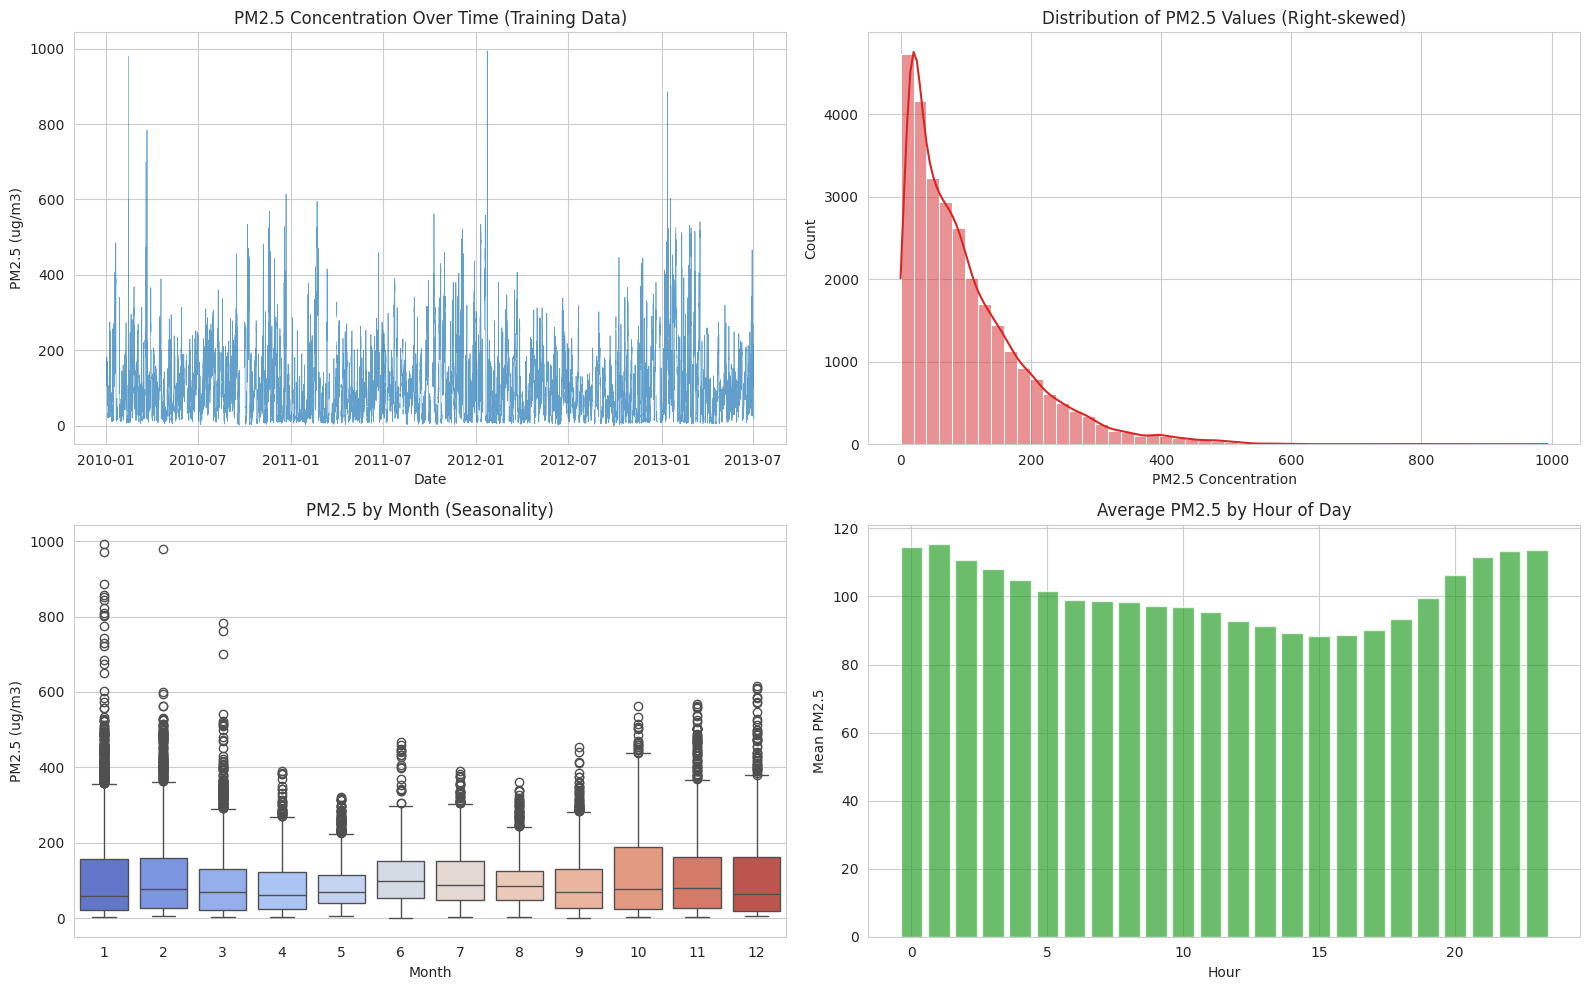

In [104]:
# Time Series Plot of PM2.5
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Full time series
axes[0, 0].plot(train_raw['datetime'], train_raw['pm2.5'], color='tab:blue', alpha=0.7, linewidth=0.5)
axes[0, 0].set_title("PM2.5 Concentration Over Time (Training Data)", fontsize=12)
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("PM2.5 (ug/m3)")

# Distribution 
sns.histplot(train_raw['pm2.5'].dropna(), bins=50, kde=True, color='tab:red', ax=axes[0, 1])
axes[0, 1].set_title("Distribution of PM2.5 Values (Right-skewed)", fontsize=12)
axes[0, 1].set_xlabel("PM2.5 Concentration")

#  Monthly boxplot
train_raw['month'] = train_raw['datetime'].dt.month
sns.boxplot(x='month', y='pm2.5', data=train_raw, ax=axes[1, 0], palette='coolwarm')
axes[1, 0].set_title("PM2.5 by Month (Seasonality)", fontsize=12)
axes[1, 0].set_xlabel("Month")
axes[1, 0].set_ylabel("PM2.5 (ug/m3)")

# Hourly pattern
train_raw['hour'] = train_raw['datetime'].dt.hour
hourly_mean = train_raw.groupby('hour')['pm2.5'].mean()
axes[1, 1].bar(hourly_mean.index, hourly_mean.values, color='tab:green', alpha=0.7)
axes[1, 1].set_title("Average PM2.5 by Hour of Day", fontsize=12)
axes[1, 1].set_xlabel("Hour")
axes[1, 1].set_ylabel("Mean PM2.5")

plt.tight_layout()
plt.show()

# Clean up temp columns
train_raw.drop(['month', 'hour'], axis=1, inplace=True)


### Datetime Feature Engineering
We convert the 'datetime' column to a pandas datetime object and set it as the index. This enables efficient time-based feature engineering.

In [5]:
# Datetime processing
train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

print(f"Train shape after indexing: {train.shape}")
print(f"Test shape after indexing: {test.shape}")


Train shape after indexing: (30676, 11)
Test shape after indexing: (13148, 10)


### Feature Correlations
To determine which weather features are most relevant for forecasting, I generated a correlation heatmap.

**Insights for Model Building:**
1.  **DEWP (Dew Point) & TEMP (Temperature):** Show a positive correlation. This suggests that humidity and temperature conditions are key drivers of pollution formation.
2.  **PRES (Pressure) & Iws (Wind Speed):** Show negative correlations with PM2.5. This makes physical sense: high wind speeds disperse pollutants, clearing the air.
    
*This informs my feature selection: I must include wind speed (Iws) and pressure (PRES) as input features, as they act as natural "cleansing" signals for the model.*

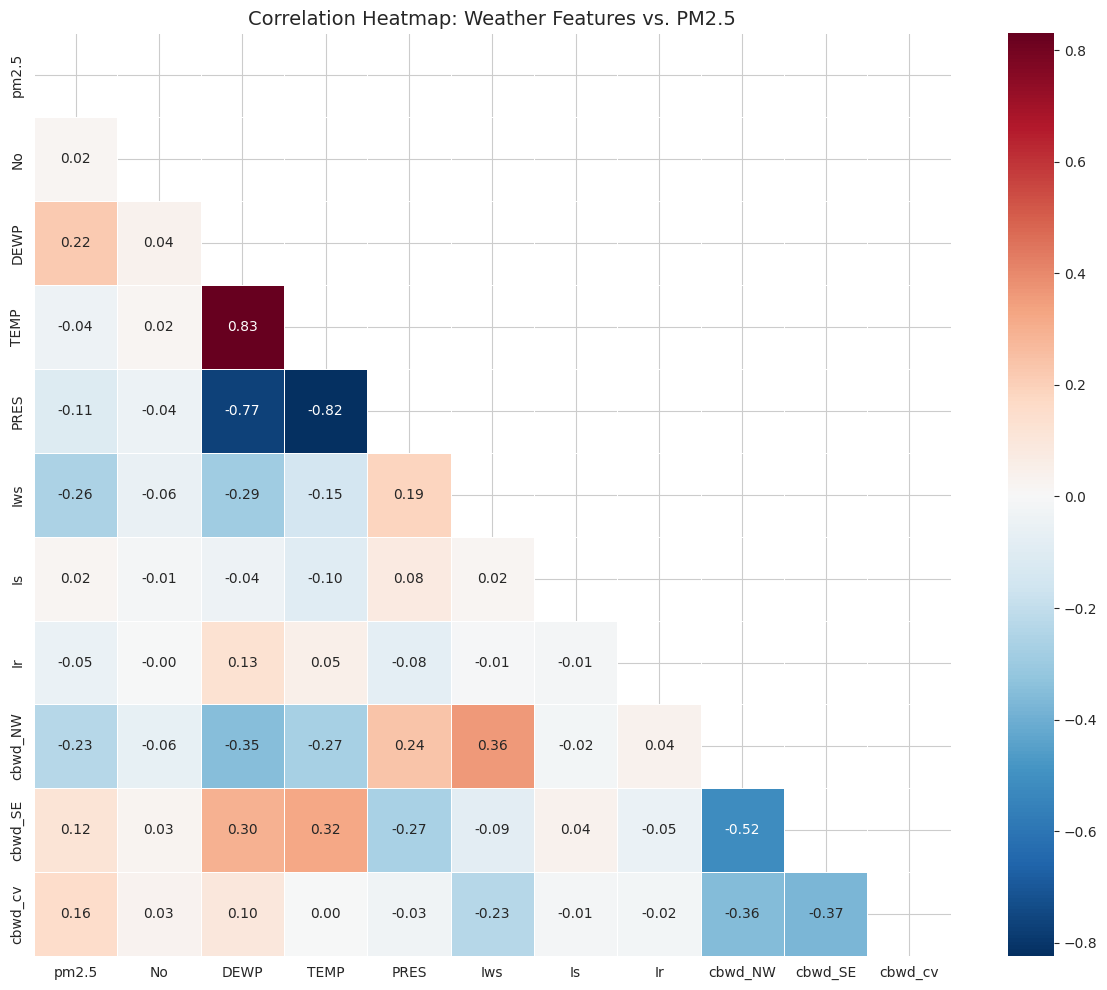


Correlation with PM2.5:
DEWP       0.218187
cbwd_cv    0.158033
cbwd_SE    0.118986
Is         0.022279
No         0.017961
TEMP      -0.039601
Ir        -0.052288
PRES      -0.107773
cbwd_NW   -0.231176
Iws       -0.260250
Name: pm2.5, dtype: float64


In [6]:
# Correlation Analysis
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if 'pm2.5' in numeric_cols:
    # Reorder to put pm2.5 first
    numeric_cols.remove('pm2.5')
    numeric_cols = ['pm2.5'] + numeric_cols

corr_matrix = train[numeric_cols].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', fmt=".2f", 
            linewidths=0.5, mask=mask, center=0)
plt.title('Correlation Heatmap: Weather Features vs. PM2.5', fontsize=14)
plt.tight_layout()
plt.show()

# Show correlations with target
print("\nCorrelation with PM2.5:")
pm25_corr = corr_matrix['pm2.5'].drop('pm2.5').sort_values(ascending=False)
print(pm25_corr)

### Temporal Feature Extraction
We extract cyclical and categorical temporal features (hour, day, month, day of week) to help the model capture periodic patterns in air quality.

In [7]:
# Temporal features
def add_temporal_features(df):
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek
    df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
    df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)
    df['month_sin'] = np.sin(2*np.pi*df['month']/12)
    df['month_cos'] = np.cos(2*np.pi*df['month']/12)
    return df

train = add_temporal_features(train)
test = add_temporal_features(test)


### Handling Missing Values
Missing values are imputed using forward and backward fill methods to maintain data continuity, which is especially important for time series data.

In [8]:
# Handle missing values using forward fill then backward fill
train = train.ffill().bfill()
test = test.ffill().bfill()


print(f"Missing values in train after fill: {train.isnull().sum().sum()}")
print(f"Missing values in test after fill: {test.isnull().sum().sum()}")

Missing values in train after fill: 0
Missing values in test after fill: 0


### Feature and Target Separation
We separate the features from the target variable ('pm2.5') and prepare the test set accordingly.

In [9]:
# Feature / target split
feature_cols = [c for c in train.columns if c not in ['pm2.5','No']]
X_train = train[feature_cols].values
y_train = train['pm2.5'].values
X_test = test.drop(['No'], axis=1).values


### Feature Scaling
Standardization is applied to both features and target to improve model convergence and performance.

In [10]:
# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()

In [11]:
# Sequence creation
def create_sequences(X, y, steps=24):
    Xs, ys = [], []
    for i in range(len(X)-steps):
        Xs.append(X[i:i+steps])
        ys.append(y[i+steps])
    return np.array(Xs), np.array(ys)

def create_test_sequences(X, steps=24):
    return np.array([X[i:i+steps] for i in range(len(X)-steps+1)])

time_steps = 24
X_seq, y_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)

### Train/Validation Split
The data is split into training and validation sets to evaluate model generalization.

In [12]:
# Train/validation split
split = int(0.9 * len(X_seq))
X_train_f, X_val = X_seq[:split], X_seq[split:]
y_train_f, y_val = y_seq[:split], y_seq[split:]


## Baseline Model Construction

The baseline architecture employs a stacked Bidirectional LSTM design. The key innovation of Bidirectional LSTMs is that they process sequences in both forward and backward directions, then concatenate the hidden states. This allows the network to capture context from both past and future observations within the lookback window.

**Architecture Design Rationale:**

1. **First BiLSTM Layer (128 units):** Extracts high-level temporal features from raw input sequences. The bidirectional nature doubles the effective hidden size to 256, providing rich representational capacity.

2. **Second BiLSTM Layer (64 units):** Refines the learned representations with a narrower bottleneck, encouraging the network to learn more abstract patterns.

3. **Final LSTM Layer (32 units):** A unidirectional layer that produces the final temporal encoding before the dense layers. This layer does not return sequences, collapsing the temporal dimension.

4. **Dropout Layers (30%, 30%, 20%):** Applied after each recurrent layer to prevent co-adaptation of neurons and reduce overfitting.

The loss function used is Mean Squared Error (MSE):

$$\mathcal{L}_{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$

In [13]:
# Build model
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(time_steps, X_seq.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer=Adam(0.001),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()

I0000 00:00:1769368084.226466      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1769368084.227205      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 24, 256)        │       149,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 24, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 335,553 (1.28 MB)

 Trainable params: 335,553 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training Strategy

Training deep recurrent networks requires careful management of the optimization process. I employ two key callback mechanisms:

**1. Early Stopping (patience=15):**
Monitors validation loss and halts training when no improvement is observed for 15 consecutive epochs. This prevents overfitting by stopping before the model begins memorizing training noise. The `restore_best_weights=True` parameter ensures we retain the model state from the epoch with lowest validation loss.

**2. ReduceLROnPlateau (patience=5, factor=0.5):**
When validation loss stagnates for 5 epochs, the learning rate is reduced by half:

$$\eta_{t+1} = 0.5 \times \eta_t$$

This allows the optimizer to make finer adjustments as it approaches a minimum, often helping to escape saddle points or shallow local minima.

**Training Configuration:**
- **Epochs:** 100 (maximum, typically stops earlier due to early stopping)
- **Batch Size:** 64 (balance between gradient stability and computational efficiency)
- **Optimizer:** Adam with $\eta = 0.001$

In [14]:
# Train
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5)
]

history = model.fit(
    X_train_f, y_train_f,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/100


I0000 00:00:1769368090.282248     147 cuda_dnn.cc:529] Loaded cuDNN version 91002


432/432 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5808 - root_mean_squared_error: 0.7608 - val_loss: 0.4367 - val_root_mean_squared_error: 0.6609 - learning_rate: 0.0010
Epoch 2/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.3990 - root_mean_squared_error: 0.6315 - val_loss: 0.4463 - val_root_mean_squared_error: 0.6681 - learning_rate: 0.0010
Epoch 3/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.3273 - root_mean_squared_error: 0.5719 - val_loss: 0.4522 - val_root_mean_squared_error: 0.6725 - learning_rate: 0.0010
Epoch 4/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.2603 - root_mean_squared_error: 0.5101 - val_loss: 0.4875 - val_root_mean_squared_error: 0.6982 - learning_rate: 0.0010
Epoch 5/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2326 - root_mean_squared_error: 0.4820 - val_loss: 0.4920 - val_root_mean_squared_error: 0.7015 - learning_rate: 0.0010
Epoch 6/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1988 - root_mean_squared_er

## Model Evaluation

Performance is assessed using Root Mean Squared Error (RMSE), which penalizes large prediction errors more heavily than Mean Absolute Error (MAE). This is appropriate for air quality forecasting where significantly underestimating high pollution events could have public health consequences.

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$$

**Important:** Since we scaled our target variable during preprocessing, we must inverse-transform predictions back to the original PM2.5 scale (μg/m³) before calculating RMSE. This ensures our error metric is interpretable in real-world units.

In [15]:
# Evaluation
val_preds = scaler_y.inverse_transform(model.predict(X_val))
y_val_true = scaler_y.inverse_transform(y_val.reshape(-1,1))

rmse = np.sqrt(np.mean((val_preds - y_val_true)**2))
print(f"Baseline RMSE: {rmse:.2f}")

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Baseline RMSE: 60.86


## Test Set Prediction and Submission
Predictions are generated for the test set and formatted for submission. Negative predictions are clipped to zero, as negative PM2.5 values are not physically meaningful.

In [16]:
# Test prediction & submission
X_test_seq = create_test_sequences(X_test_scaled, time_steps)
preds = scaler_y.inverse_transform(model.predict(X_test_seq)).flatten()
preds = np.maximum(preds, 0).round().astype(int)

submission = pd.DataFrame({
    'row ID': format_datetime_for_submission(test.index),
    'pm2.5': np.concatenate([np.repeat(preds[0], time_steps-1), preds])[:len(test)]
})

submission.to_csv(f'{OUTPUT_PATH}/submission_baseline.csv', index=False)
print(f"Submission saved. Shape: {submission.shape}")
submission.head()

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Submission saved. Shape: (13148, 2)


row ID  pm2.5
0  2013-07-02 04:00:00     32
1  2013-07-02 05:00:00     32
2  2013-07-02 06:00:00     32
3  2013-07-02 07:00:00     32
4  2013-07-02 08:00:00     32

## Systematic Hyperparameter Exploration

Finding optimal hyperparameters is critical for neural network performance. Rather than relying on intuition alone, I conduct a systematic series of experiments, varying one or two hyperparameters at a time while holding others constant. This approach follows the scientific method—isolating variables to understand their individual effects.

**Hyperparameters Under Investigation:**

| Category | Parameters | Rationale |
|----------|------------|-----------|
| **Architecture** | Layer sizes, depth | Controls model capacity and expressiveness |
| **Regularization** | Dropout rates | Prevents overfitting by randomly zeroing activations |
| **Optimization** | Learning rate, optimizer type | Affects convergence speed and final solution quality |
| **Training** | Batch size, epochs, callbacks | Influences gradient estimation and training dynamics |

Each experiment produces a submission file, allowing comparison not just on validation RMSE but also on the Kaggle leaderboard score, which reflects generalization to unseen test data.

### Experiment 1: Increased Model Capacity with Reduced Regularization

**Hypothesis:** The baseline model may be underfitting, unable to capture the full complexity of PM2.5 dynamics. By increasing LSTM units (256 -> 128 -> 64) and reducing dropout (0.15/0.15/0.1), we provide more representational capacity.

**Theoretical Basis:**
The number of learnable parameters in an LSTM layer scales with $O(4 \times h \times (h + d))$, where $h$ is the hidden size and $d$ is the input dimension. Doubling the hidden size roughly quadruples the parameter count, significantly increasing the function space the model can represent.

**Risk:** Higher capacity models are more prone to overfitting. We mitigate this by:
- Maintaining some dropout (albeit reduced)
- Using early stopping as a safeguard
- Increasing batch size to 128 for more stable gradients

In [17]:
# Model with more LSTM units and lower dropout
model_exp1 = Sequential([
    Bidirectional(LSTM(256, return_sequences=True), input_shape=(time_steps, X_seq.shape[2])),
    Dropout(0.15),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.15),
    LSTM(64),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dense(1)
])
model_exp1.compile(
    optimizer=Adam(0.005),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
history_exp1 = model_exp1.fit(
    X_train_f, y_train_f,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=128,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True), ReduceLROnPlateau(patience=3, factor=0.5)],
    verbose=2
)
val_preds_exp1 = scaler_y.inverse_transform(model_exp1.predict(X_val))
rmse_exp1 = np.sqrt(np.mean((val_preds_exp1 - y_val_true)**2))
print(f"Experiment 1 RMSE: {rmse_exp1:.2f}")

Epoch 1/60
216/216 - 9s - 39ms/step - loss: 0.5813 - root_mean_squared_error: 0.7624 - val_loss: 0.4423 - val_root_mean_squared_error: 0.6651 - learning_rate: 0.0050
Epoch 2/60
216/216 - 4s - 20ms/step - loss: 0.4128 - root_mean_squared_error: 0.6425 - val_loss: 0.3964 - val_root_mean_squared_error: 0.6296 - learning_rate: 0.0050
Epoch 3/60
216/216 - 4s - 20ms/step - loss: 0.3475 - root_mean_squared_error: 0.5895 - val_loss: 0.4375 - val_root_mean_squared_error: 0.6615 - learning_rate: 0.0050
Epoch 4/60
216/216 - 4s - 20ms/step - loss: 0.2815 - root_mean_squared_error: 0.5306 - val_loss: 0.4421 - val_root_mean_squared_error: 0.6649 - learning_rate: 0.0050
Epoch 5/60
216/216 - 4s - 20ms/step - loss: 0.2337 - root_mean_squared_error: 0.4834 - val_loss: 0.4487 - val_root_mean_squared_error: 0.6699 - learning_rate: 0.0050
Epoch 6/60
216/216 - 4s - 20ms/step - loss: 0.1638 - root_mean_squared_error: 0.4048 - val_loss: 0.4803 - val_root_mean_squared_error: 0.6931 - learning_rate: 0.0025
Epoc

In [18]:
# Test prediction & submission for Experiment 1
X_test_seq = create_test_sequences(X_test_scaled, time_steps)
preds = scaler_y.inverse_transform(model_exp1.predict(X_test_seq)).flatten()
preds = np.maximum(preds, 0).round().astype(int)

submission = pd.DataFrame({
    'row ID': format_datetime_for_submission(test.index),
    'pm2.5': np.concatenate([np.repeat(preds[0], time_steps-1), preds])[:len(test)]
})

submission.to_csv(f'{OUTPUT_PATH}/submission1.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


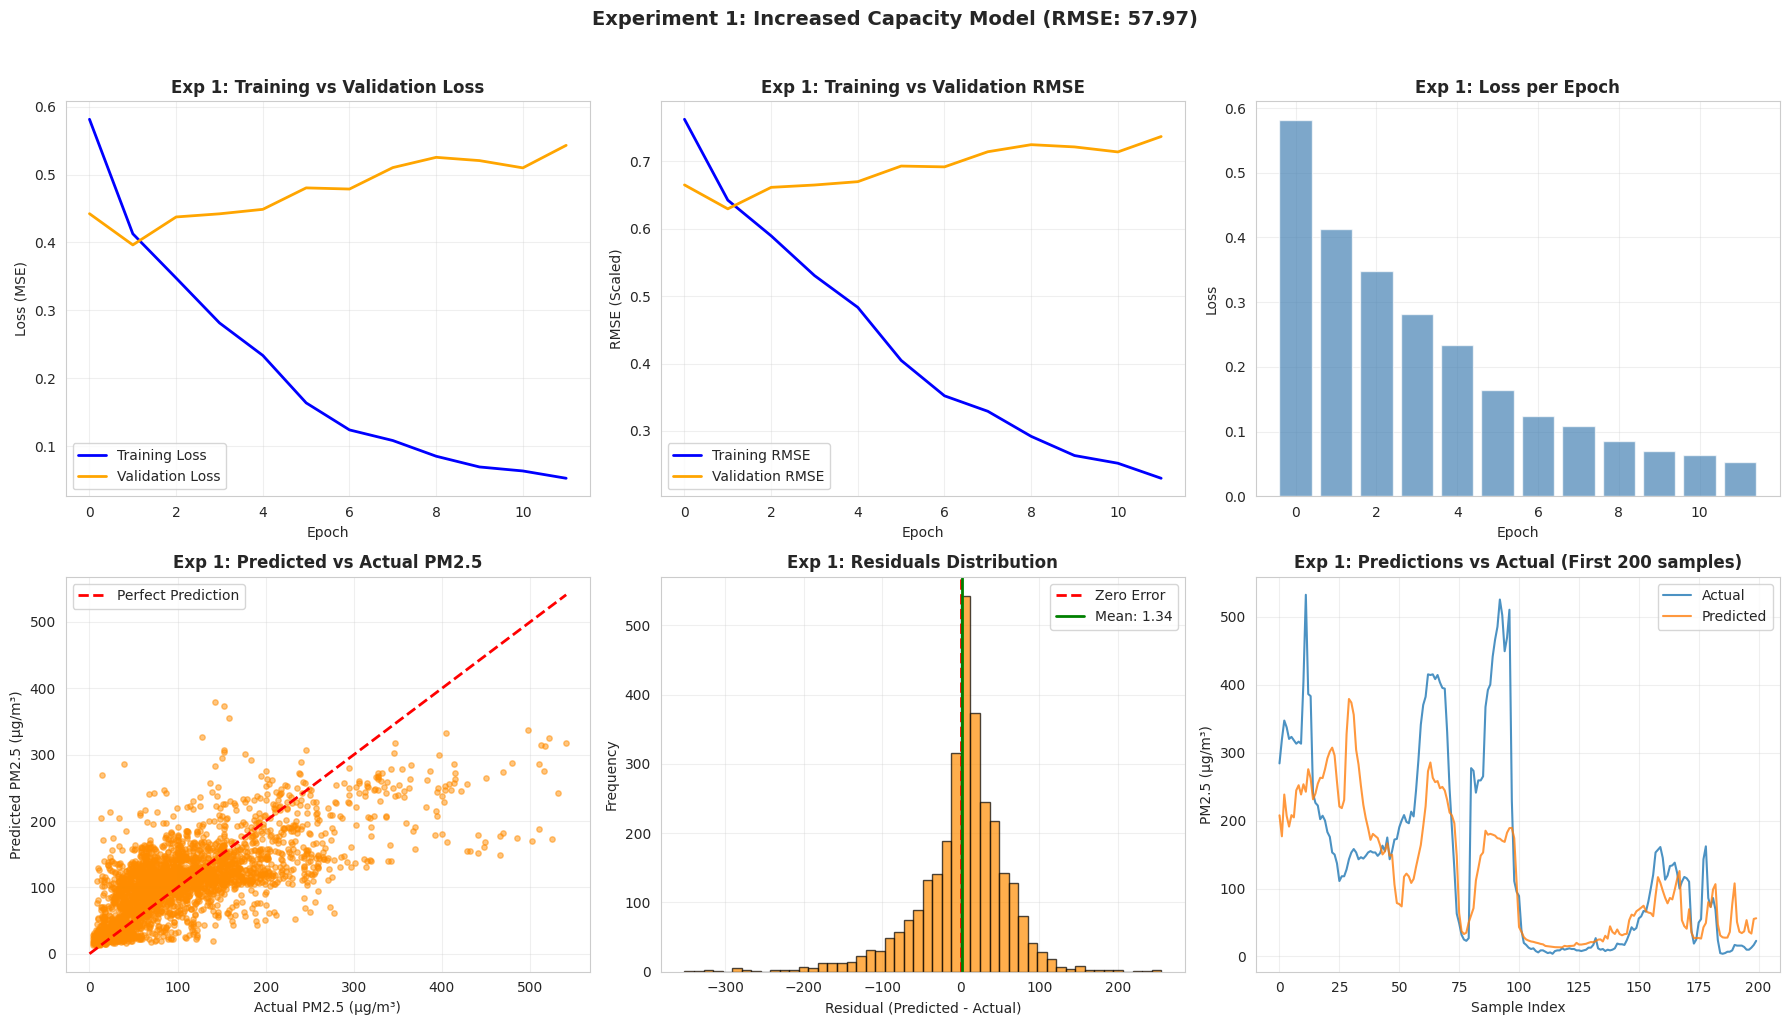


Experiment 1 Statistics:
   RMSE: 57.97
   MAE: 40.17
   Mean Residual: 1.34
   Std Residual: 57.96
   Epochs Trained: 12


In [85]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Training & Validation Loss Curves
axes[0, 0].plot(history_exp1.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[0, 0].plot(history_exp1.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[0, 0].set_title('Exp 1: Training vs Validation Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Training & Validation RMSE Curves
axes[0, 1].plot(history_exp1.history['root_mean_squared_error'], label='Training RMSE', linewidth=2, color='blue')
axes[0, 1].plot(history_exp1.history['val_root_mean_squared_error'], label='Validation RMSE', linewidth=2, color='orange')
axes[0, 1].set_title('Exp 1: Training vs Validation RMSE', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('RMSE (Scaled)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Loss per Epoch Bar Chart
epochs_trained_exp1 = len(history_exp1.history['loss'])
axes[0, 2].bar(range(epochs_trained_exp1), history_exp1.history['loss'], alpha=0.7, color='steelblue')
axes[0, 2].set_title('Exp 1: Loss per Epoch', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Predicted vs Actual Scatter Plot
axes[1, 0].scatter(y_val_true, val_preds_exp1, alpha=0.5, s=15, c='darkorange')
max_val = max(y_val_true.max(), val_preds_exp1.max())
axes[1, 0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title('Exp 1: Predicted vs Actual PM2.5', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Actual PM2.5 (μg/m³)')
axes[1, 0].set_ylabel('Predicted PM2.5 (μg/m³)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Residuals Distribution
residuals_exp1 = val_preds_exp1.flatten() - y_val_true.flatten()
axes[1, 1].hist(residuals_exp1, bins=50, edgecolor='black', alpha=0.7, color='darkorange')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1, 1].axvline(x=np.mean(residuals_exp1), color='green', linestyle='-', linewidth=2, label=f'Mean: {np.mean(residuals_exp1):.2f}')
axes[1, 1].set_title('Exp 1: Residuals Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Residual (Predicted - Actual)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Time Series Comparison
n_samples = min(200, len(y_val_true))
axes[1, 2].plot(range(n_samples), y_val_true[:n_samples], label='Actual', linewidth=1.5, alpha=0.8)
axes[1, 2].plot(range(n_samples), val_preds_exp1[:n_samples], label='Predicted', linewidth=1.5, alpha=0.8)
axes[1, 2].set_title('Exp 1: Predictions vs Actual (First 200 samples)', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Sample Index')
axes[1, 2].set_ylabel('PM2.5 (μg/m³)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle(f'Experiment 1: Increased Capacity Model (RMSE: {rmse_exp1:.2f})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/exp1_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nExperiment 1 Statistics:")
print(f"   RMSE: {rmse_exp1:.2f}")
print(f"   MAE: {np.mean(np.abs(residuals_exp1)):.2f}")
print(f"   Mean Residual: {np.mean(residuals_exp1):.2f}")
print(f"   Std Residual: {np.std(residuals_exp1):.2f}")
print(f"   Epochs Trained: {epochs_trained_exp1}")

### Experiment 2: Simplified Architecture with Aggressive Regularization

**Hypothesis:** A simpler architecture with stronger regularization might generalize better to unseen data.

**Changes:**
- Remove bidirectional processing (halves effective hidden size)
- Use only 2 LSTM layers (64→32) instead of 3
- Increase dropout to 40% per layer

**Dropout Mathematics:**
Dropout randomly sets activations to zero with probability $p$ during training. The expected output during inference is scaled by $(1-p)$, effectively training an ensemble of $2^n$ possible sub-networks (where $n$ is the number of dropped units). With $p=0.4$, we're aggressively pruning the network's representational capacity during each forward pass.

$$\tilde{h}^{(l)} = \frac{1}{1-p} \cdot h^{(l)} \odot m, \quad m \sim \text{Bernoulli}(1-p)$$

In [19]:
# Simpler model with higher dropout
model_exp2 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_steps, X_seq.shape[2])),
    Dropout(0.4),
    LSTM(32),
    Dropout(0.4),
    Dense(16, activation='relu'),
    Dense(1)
])
model_exp2.compile(
    optimizer=Adam(0.001),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
history_exp2 = model_exp2.fit(
    X_train_f, y_train_f,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=64,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True), ReduceLROnPlateau(patience=3, factor=0.5)],
    verbose=2
)
val_preds_exp2 = scaler_y.inverse_transform(model_exp2.predict(X_val))
rmse_exp2 = np.sqrt(np.mean((val_preds_exp2 - y_val_true)**2))
print(f"Experiment 2 RMSE: {rmse_exp2:.2f}")

Epoch 1/60
432/432 - 5s - 12ms/step - loss: 0.5637 - root_mean_squared_error: 0.7508 - val_loss: 0.4786 - val_root_mean_squared_error: 0.6918 - learning_rate: 1.0000e-03
Epoch 2/60
432/432 - 3s - 7ms/step - loss: 0.4373 - root_mean_squared_error: 0.6613 - val_loss: 0.4946 - val_root_mean_squared_error: 0.7033 - learning_rate: 1.0000e-03
Epoch 3/60
432/432 - 3s - 7ms/step - loss: 0.3824 - root_mean_squared_error: 0.6184 - val_loss: 0.5005 - val_root_mean_squared_error: 0.7074 - learning_rate: 1.0000e-03
Epoch 4/60
432/432 - 3s - 7ms/step - loss: 0.3330 - root_mean_squared_error: 0.5771 - val_loss: 0.4878 - val_root_mean_squared_error: 0.6984 - learning_rate: 1.0000e-03
Epoch 5/60
432/432 - 3s - 7ms/step - loss: 0.2797 - root_mean_squared_error: 0.5289 - val_loss: 0.4910 - val_root_mean_squared_error: 0.7007 - learning_rate: 5.0000e-04
Epoch 6/60
432/432 - 3s - 7ms/step - loss: 0.2594 - root_mean_squared_error: 0.5093 - val_loss: 0.4946 - val_root_mean_squared_error: 0.7033 - learning_ra

In [20]:
# Test prediction & submission for Experiment 2
X_test_seq = create_test_sequences(X_test_scaled, time_steps)
preds = scaler_y.inverse_transform(model_exp2.predict(X_test_seq)).flatten()
preds = np.maximum(preds, 0).round().astype(int)

submission = pd.DataFrame({
    'row ID': format_datetime_for_submission(test.index),
    'pm2.5': np.concatenate([np.repeat(preds[0], time_steps-1), preds])[:len(test)]
})

submission.to_csv(f'{OUTPUT_PATH}/submission2.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


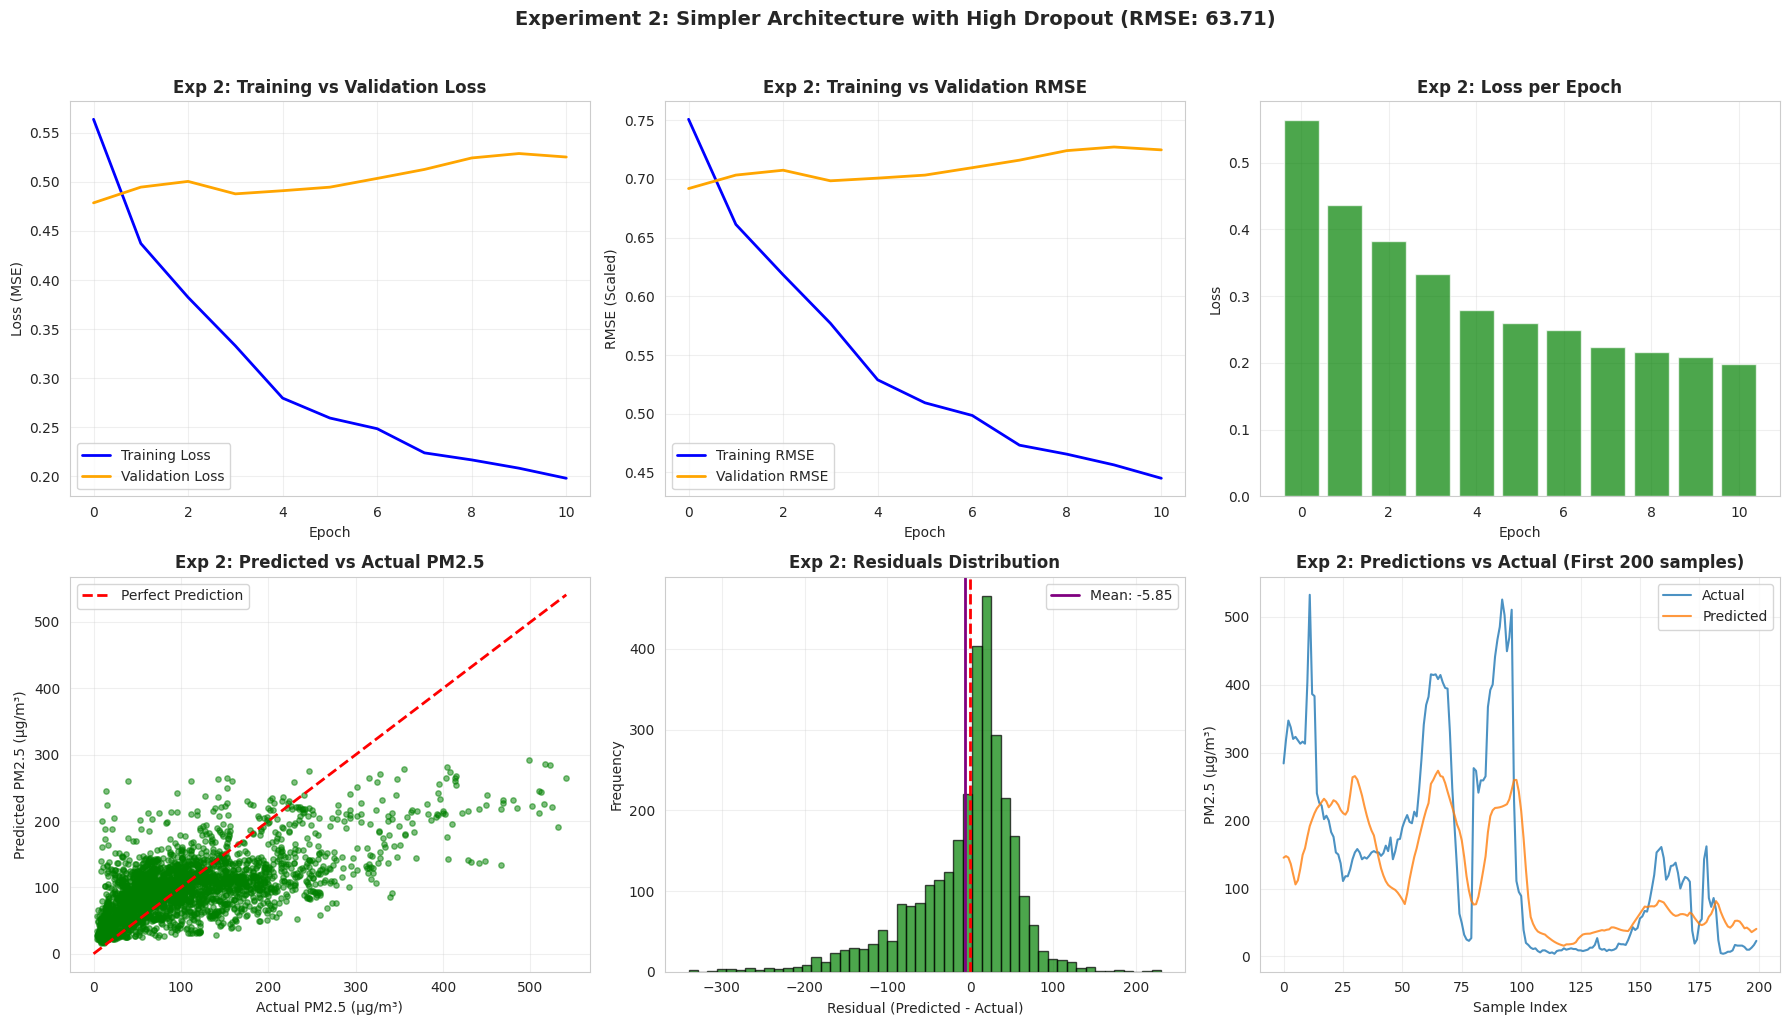


 Experiment 2 Statistics:
   RMSE: 63.71
   MAE: 45.14
   Epochs Trained: 11


In [86]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Training & Validation Loss Curves
axes[0, 0].plot(history_exp2.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[0, 0].plot(history_exp2.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[0, 0].set_title('Exp 2: Training vs Validation Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Training & Validation RMSE Curves
axes[0, 1].plot(history_exp2.history['root_mean_squared_error'], label='Training RMSE', linewidth=2, color='blue')
axes[0, 1].plot(history_exp2.history['val_root_mean_squared_error'], label='Validation RMSE', linewidth=2, color='orange')
axes[0, 1].set_title('Exp 2: Training vs Validation RMSE', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('RMSE (Scaled)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Loss per Epoch
epochs_trained_exp2 = len(history_exp2.history['loss'])
axes[0, 2].bar(range(epochs_trained_exp2), history_exp2.history['loss'], alpha=0.7, color='green')
axes[0, 2].set_title('Exp 2: Loss per Epoch', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Predicted vs Actual Scatter Plot
axes[1, 0].scatter(y_val_true, val_preds_exp2, alpha=0.5, s=15, c='green')
max_val = max(y_val_true.max(), val_preds_exp2.max())
axes[1, 0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title('Exp 2: Predicted vs Actual PM2.5', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Actual PM2.5 (μg/m³)')
axes[1, 0].set_ylabel('Predicted PM2.5 (μg/m³)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Residuals Distribution
residuals_exp2 = val_preds_exp2.flatten() - y_val_true.flatten()
axes[1, 1].hist(residuals_exp2, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].axvline(x=np.mean(residuals_exp2), color='purple', linestyle='-', linewidth=2, label=f'Mean: {np.mean(residuals_exp2):.2f}')
axes[1, 1].set_title('Exp 2: Residuals Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Residual (Predicted - Actual)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Time Series Comparison
n_samples = min(200, len(y_val_true))
axes[1, 2].plot(range(n_samples), y_val_true[:n_samples], label='Actual', linewidth=1.5, alpha=0.8)
axes[1, 2].plot(range(n_samples), val_preds_exp2[:n_samples], label='Predicted', linewidth=1.5, alpha=0.8)
axes[1, 2].set_title('Exp 2: Predictions vs Actual (First 200 samples)', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Sample Index')
axes[1, 2].set_ylabel('PM2.5 (μg/m³)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle(f'Experiment 2: Simpler Architecture with High Dropout (RMSE: {rmse_exp2:.2f})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/exp2_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n Experiment 2 Statistics:")
print(f"   RMSE: {rmse_exp2:.2f}")
print(f"   MAE: {np.mean(np.abs(residuals_exp2)):.2f}")
print(f"   Epochs Trained: {epochs_trained_exp2}")

### Experiment 3: Aggressive Learning Rate (10x Baseline)

**Hypothesis:** A higher learning rate ($\eta = 0.01$) may enable faster convergence and help escape poor local minima. However, it risks overshooting optimal solutions.

**Learning Rate Impact on Gradient Descent:**
The weight update rule $\theta_{t+1} = \theta_t - \eta \nabla_\theta \mathcal{L}$ shows that $\eta$ directly scales the step size. With $\eta = 0.01$ (10× our baseline of 0.001):

- **Pros:** Faster initial convergence, ability to escape shallow local minima
- **Cons:** May oscillate around minima, risk of divergence

**Mitigation Strategy:**
- Reduced epochs (40) to prevent excessive oscillation
- More aggressive ReduceLROnPlateau (patience=2) to quickly reduce LR if needed
- Simpler architecture (1 BiLSTM + 1 LSTM) for stability

In [21]:
# Model with higher learning rate
model_exp3 = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(time_steps, X_seq.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model_exp3.compile(
    optimizer=Adam(0.01),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
history_exp3 = model_exp3.fit(
    X_train_f, y_train_f,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=64,
    callbacks=[EarlyStopping(patience=7, restore_best_weights=True), ReduceLROnPlateau(patience=2, factor=0.5)],
    verbose=2
)
val_preds_exp3 = scaler_y.inverse_transform(model_exp3.predict(X_val))
rmse_exp3 = np.sqrt(np.mean((val_preds_exp3 - y_val_true)**2))
print(f"Experiment 3 RMSE: {rmse_exp3:.2f}")

Epoch 1/40
432/432 - 7s - 16ms/step - loss: 0.5605 - root_mean_squared_error: 0.7487 - val_loss: 0.4409 - val_root_mean_squared_error: 0.6640 - learning_rate: 0.0100
Epoch 2/40
432/432 - 4s - 8ms/step - loss: 0.4499 - root_mean_squared_error: 0.6708 - val_loss: 0.4705 - val_root_mean_squared_error: 0.6859 - learning_rate: 0.0100
Epoch 3/40
432/432 - 4s - 9ms/step - loss: 0.4074 - root_mean_squared_error: 0.6383 - val_loss: 0.4285 - val_root_mean_squared_error: 0.6546 - learning_rate: 0.0100
Epoch 4/40
432/432 - 4s - 9ms/step - loss: 0.3542 - root_mean_squared_error: 0.5951 - val_loss: 0.4304 - val_root_mean_squared_error: 0.6561 - learning_rate: 0.0100
Epoch 5/40
432/432 - 4s - 9ms/step - loss: 0.3292 - root_mean_squared_error: 0.5737 - val_loss: 0.4313 - val_root_mean_squared_error: 0.6567 - learning_rate: 0.0100
Epoch 6/40
432/432 - 4s - 9ms/step - loss: 0.2685 - root_mean_squared_error: 0.5181 - val_loss: 0.4764 - val_root_mean_squared_error: 0.6902 - learning_rate: 0.0050
Epoch 7/4

In [22]:
# Test prediction & submission for Experiment 3
X_test_seq = create_test_sequences(X_test_scaled, time_steps)
preds = scaler_y.inverse_transform(model_exp3.predict(X_test_seq)).flatten()
preds = np.maximum(preds, 0).round().astype(int)

submission = pd.DataFrame({
    'row ID': format_datetime_for_submission(test.index),
    'pm2.5': np.concatenate([np.repeat(preds[0], time_steps-1), preds])[:len(test)]
})

submission.to_csv(f'{OUTPUT_PATH}/submission3.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


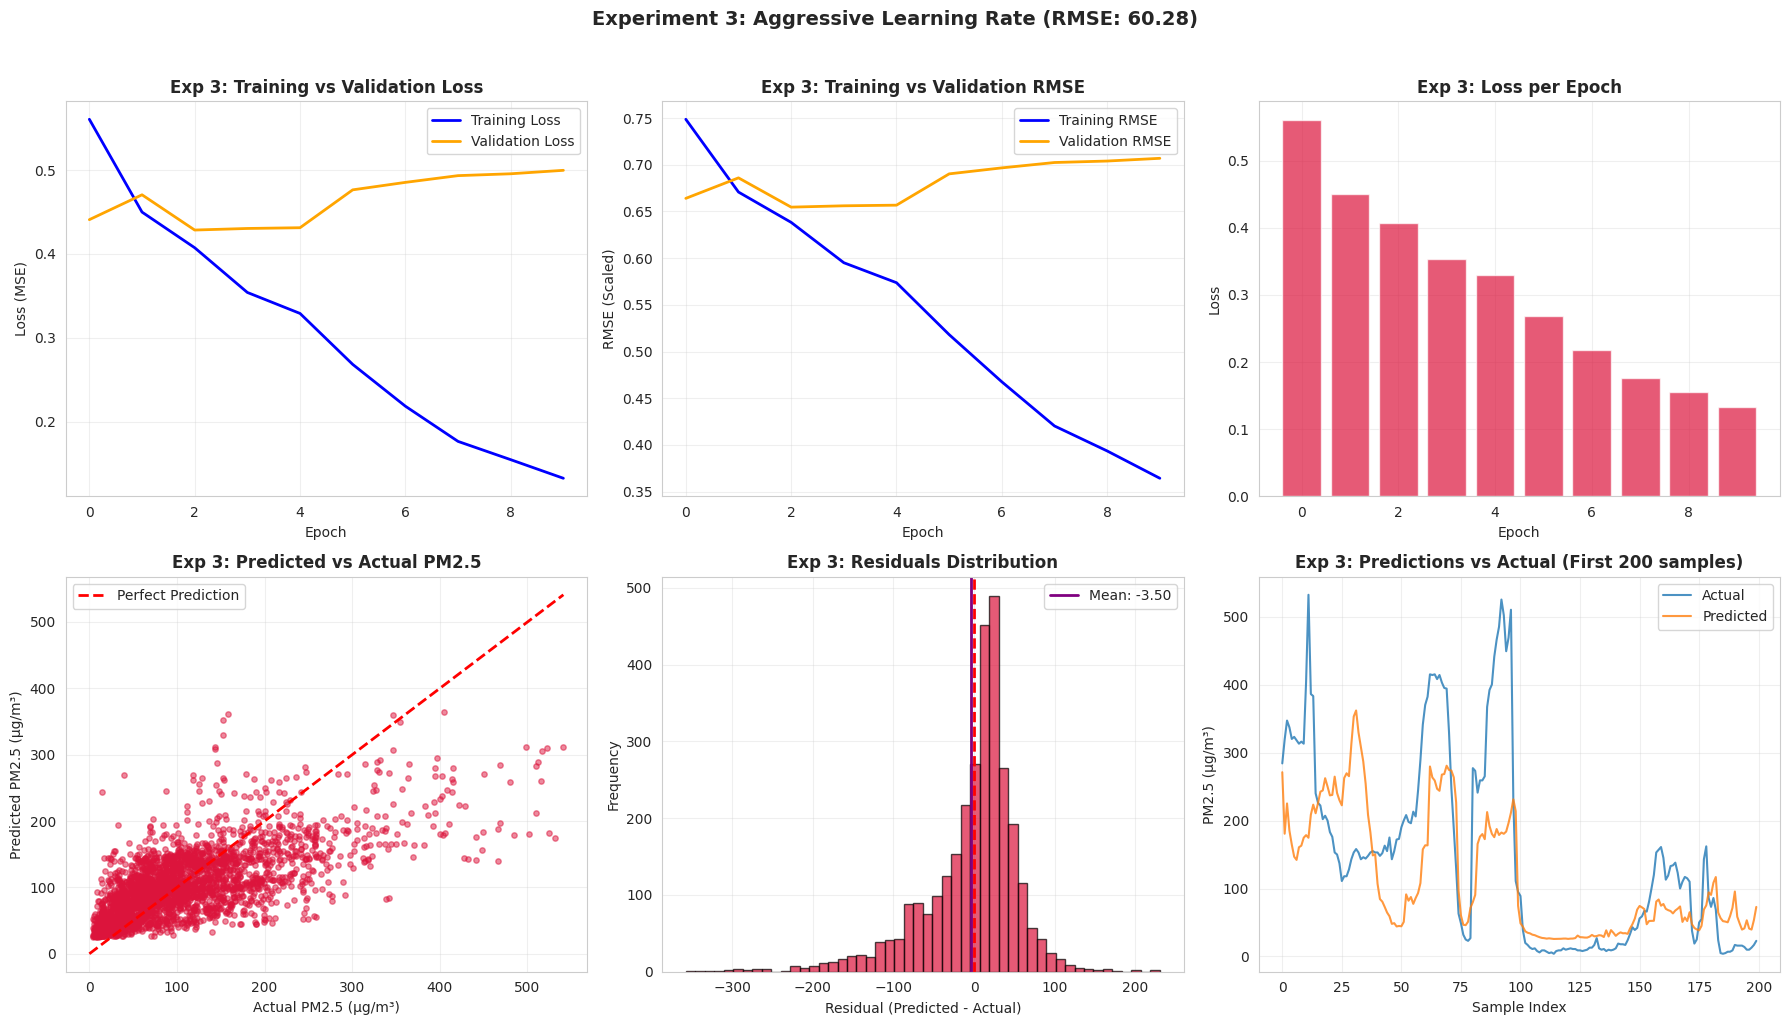


Experiment 3 Statistics:
   RMSE: 60.28
   MAE: 42.55
   Epochs Trained: 10


In [87]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Training & Validation Loss Curves
axes[0, 0].plot(history_exp3.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[0, 0].plot(history_exp3.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[0, 0].set_title('Exp 3: Training vs Validation Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Training & Validation RMSE Curves
axes[0, 1].plot(history_exp3.history['root_mean_squared_error'], label='Training RMSE', linewidth=2, color='blue')
axes[0, 1].plot(history_exp3.history['val_root_mean_squared_error'], label='Validation RMSE', linewidth=2, color='orange')
axes[0, 1].set_title('Exp 3: Training vs Validation RMSE', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('RMSE (Scaled)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Loss per Epoch
epochs_trained_exp3 = len(history_exp3.history['loss'])
axes[0, 2].bar(range(epochs_trained_exp3), history_exp3.history['loss'], alpha=0.7, color='crimson')
axes[0, 2].set_title('Exp 3: Loss per Epoch', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Predicted vs Actual Scatter Plot
axes[1, 0].scatter(y_val_true, val_preds_exp3, alpha=0.5, s=15, c='crimson')
max_val = max(y_val_true.max(), val_preds_exp3.max())
axes[1, 0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title('Exp 3: Predicted vs Actual PM2.5', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Actual PM2.5 (μg/m³)')
axes[1, 0].set_ylabel('Predicted PM2.5 (μg/m³)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Residuals Distribution
residuals_exp3 = val_preds_exp3.flatten() - y_val_true.flatten()
axes[1, 1].hist(residuals_exp3, bins=50, edgecolor='black', alpha=0.7, color='crimson')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].axvline(x=np.mean(residuals_exp3), color='purple', linestyle='-', linewidth=2, label=f'Mean: {np.mean(residuals_exp3):.2f}')
axes[1, 1].set_title('Exp 3: Residuals Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Residual (Predicted - Actual)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Time Series Comparison
n_samples = min(200, len(y_val_true))
axes[1, 2].plot(range(n_samples), y_val_true[:n_samples], label='Actual', linewidth=1.5, alpha=0.8)
axes[1, 2].plot(range(n_samples), val_preds_exp3[:n_samples], label='Predicted', linewidth=1.5, alpha=0.8)
axes[1, 2].set_title('Exp 3: Predictions vs Actual (First 200 samples)', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Sample Index')
axes[1, 2].set_ylabel('PM2.5 (μg/m³)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle(f'Experiment 3: Aggressive Learning Rate (RMSE: {rmse_exp3:.2f})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/exp3_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nExperiment 3 Statistics:")
print(f"   RMSE: {rmse_exp3:.2f}")
print(f"   MAE: {np.mean(np.abs(residuals_exp3)):.2f}")
print(f"   Epochs Trained: {epochs_trained_exp3}")

### Experiment 4: Reduced Batch Size for Noisier Gradients

**Hypothesis:** Smaller batch sizes (32 vs 64) introduce more stochasticity into gradient estimates, which can act as implicit regularization and help the model generalize.

**Gradient Noise Theory:**
The gradient estimate variance scales inversely with batch size:

$$\text{Var}[\nabla_\theta \mathcal{L}_{\text{batch}}] \propto \frac{\sigma^2}{B}$$

Where $B$ is the batch size and $\sigma^2$ is the inherent gradient variance. Smaller $B$ means noisier gradients, which:
- Can help escape sharp minima (associated with poor generalization)
- May find flatter minima (associated with better generalization)
- Requires more iterations per epoch

**Trade-off:** Training will be slower (more gradient updates per epoch), but each update explores a slightly different loss surface due to the random mini-batch selection.

In [23]:
# Experiment 4: Smaller batch size
model_exp4 = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(time_steps, X_seq.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model_exp4.compile(optimizer=Adam(0.001), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history_exp4 = model_exp4.fit(X_train_f, y_train_f, validation_data=(X_val, y_val), epochs=60, batch_size=32, callbacks=[EarlyStopping(patience=10, restore_best_weights=True)], verbose=2)
val_preds_exp4 = scaler_y.inverse_transform(model_exp4.predict(X_val))
rmse_exp4 = np.sqrt(np.mean((val_preds_exp4 - y_val_true)**2))
print(f"Experiment 4 RMSE: {rmse_exp4:.2f}")

Epoch 1/60
863/863 - 15s - 17ms/step - loss: 0.4893 - root_mean_squared_error: 0.6995 - val_loss: 0.4798 - val_root_mean_squared_error: 0.6926
Epoch 2/60
863/863 - 10s - 12ms/step - loss: 0.3725 - root_mean_squared_error: 0.6103 - val_loss: 0.4443 - val_root_mean_squared_error: 0.6666
Epoch 3/60
863/863 - 11s - 12ms/step - loss: 0.2959 - root_mean_squared_error: 0.5440 - val_loss: 0.4849 - val_root_mean_squared_error: 0.6963
Epoch 4/60
863/863 - 10s - 12ms/step - loss: 0.2449 - root_mean_squared_error: 0.4948 - val_loss: 0.4899 - val_root_mean_squared_error: 0.6999
Epoch 5/60
863/863 - 10s - 12ms/step - loss: 0.2078 - root_mean_squared_error: 0.4559 - val_loss: 0.5046 - val_root_mean_squared_error: 0.7104
Epoch 6/60
863/863 - 10s - 12ms/step - loss: 0.1820 - root_mean_squared_error: 0.4267 - val_loss: 0.5515 - val_root_mean_squared_error: 0.7427
Epoch 7/60
863/863 - 10s - 12ms/step - loss: 0.1567 - root_mean_squared_error: 0.3959 - val_loss: 0.5306 - val_root_mean_squared_error: 0.7284

In [24]:
# Test prediction & submission for Experiment 4
X_test_seq = create_test_sequences(X_test_scaled, time_steps)
preds = scaler_y.inverse_transform(model_exp4.predict(X_test_seq)).flatten()
preds = np.maximum(preds, 0).round().astype(int)

submission = pd.DataFrame({
    'row ID': format_datetime_for_submission(test.index),
    'pm2.5': np.concatenate([np.repeat(preds[0], time_steps-1), preds])[:len(test)]
})

submission.to_csv(f'{OUTPUT_PATH}/submission4.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


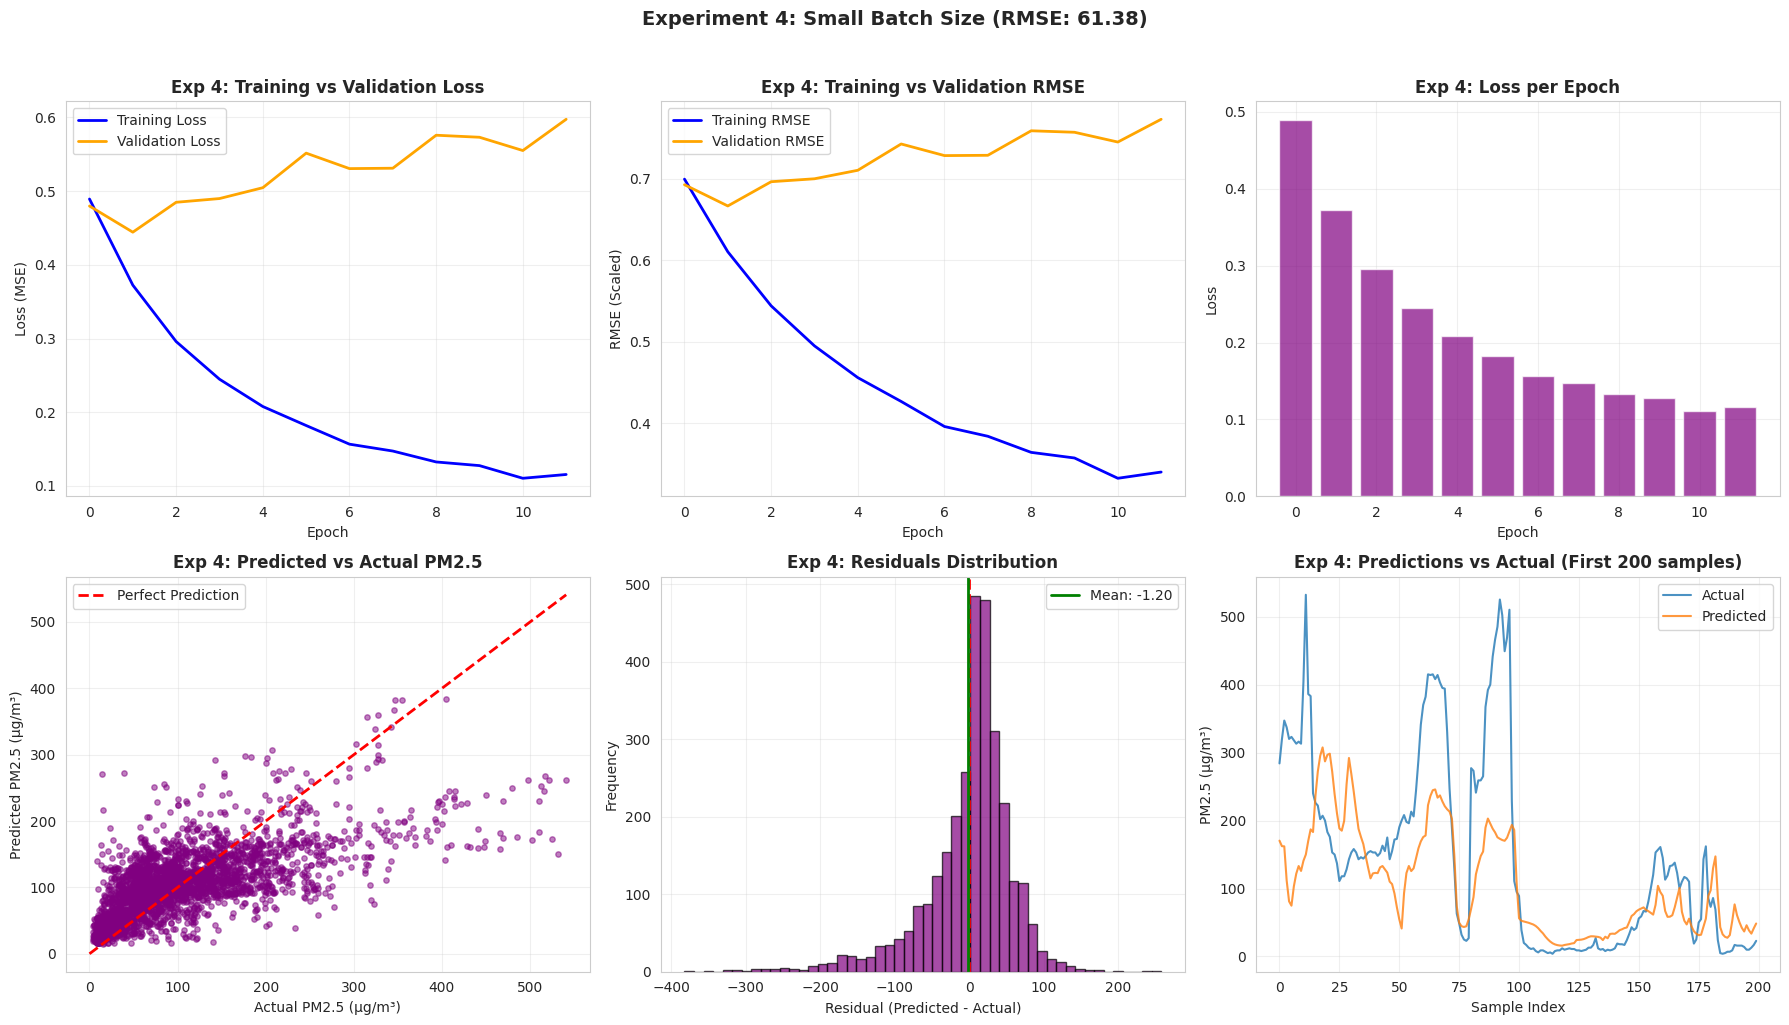


Experiment 4 Statistics: RMSE=61.38, MAE=42.46, Epochs=12


In [88]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].plot(history_exp4.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[0, 0].plot(history_exp4.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[0, 0].set_title('Exp 4: Training vs Validation Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history_exp4.history['root_mean_squared_error'], label='Training RMSE', linewidth=2, color='blue')
axes[0, 1].plot(history_exp4.history['val_root_mean_squared_error'], label='Validation RMSE', linewidth=2, color='orange')
axes[0, 1].set_title('Exp 4: Training vs Validation RMSE', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('RMSE (Scaled)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

epochs_trained_exp4 = len(history_exp4.history['loss'])
axes[0, 2].bar(range(epochs_trained_exp4), history_exp4.history['loss'], alpha=0.7, color='purple')
axes[0, 2].set_title('Exp 4: Loss per Epoch', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].scatter(y_val_true, val_preds_exp4, alpha=0.5, s=15, c='purple')
max_val = max(y_val_true.max(), val_preds_exp4.max())
axes[1, 0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title('Exp 4: Predicted vs Actual PM2.5', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Actual PM2.5 (μg/m³)')
axes[1, 0].set_ylabel('Predicted PM2.5 (μg/m³)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

residuals_exp4 = val_preds_exp4.flatten() - y_val_true.flatten()
axes[1, 1].hist(residuals_exp4, bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].axvline(x=np.mean(residuals_exp4), color='green', linestyle='-', linewidth=2, label=f'Mean: {np.mean(residuals_exp4):.2f}')
axes[1, 1].set_title('Exp 4: Residuals Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Residual (Predicted - Actual)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

n_samples = min(200, len(y_val_true))
axes[1, 2].plot(range(n_samples), y_val_true[:n_samples], label='Actual', linewidth=1.5, alpha=0.8)
axes[1, 2].plot(range(n_samples), val_preds_exp4[:n_samples], label='Predicted', linewidth=1.5, alpha=0.8)
axes[1, 2].set_title('Exp 4: Predictions vs Actual (First 200 samples)', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Sample Index')
axes[1, 2].set_ylabel('PM2.5 (μg/m³)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle(f'Experiment 4: Small Batch Size (RMSE: {rmse_exp4:.2f})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/exp4_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nExperiment 4 Statistics: RMSE={rmse_exp4:.2f}, MAE={np.mean(np.abs(residuals_exp4)):.2f}, Epochs={epochs_trained_exp4}")

### Experiment 5: Increased Batch Size for Stable Gradients

**Hypothesis:** Larger batch sizes (128) provide more accurate gradient estimates, leading to more stable and potentially faster convergence.

**Gradient Accuracy vs. Generalization Trade-off:**
While larger batches give lower-variance gradient estimates, research suggests they may converge to sharper minima. The effective learning rate can be understood through the noise scale:

$$\text{Noise Scale} \approx \frac{\eta \cdot N}{B}$$

Where $N$ is dataset size and $B$ is batch size. Doubling batch size halves the noise scale, making optimization more deterministic.

**Expected Outcome:** Smoother training curves, faster wall-clock time per epoch, but potentially slight reduction in generalization compared to noisier training.

In [25]:
model_exp5 = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(time_steps, X_seq.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model_exp5.compile(optimizer=Adam(0.001), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history_exp5 = model_exp5.fit(X_train_f, y_train_f, validation_data=(X_val, y_val), epochs=60, batch_size=128, callbacks=[EarlyStopping(patience=10, restore_best_weights=True)], verbose=2)
val_preds_exp5 = scaler_y.inverse_transform(model_exp5.predict(X_val))
rmse_exp5 = np.sqrt(np.mean((val_preds_exp5 - y_val_true)**2))
print(f"Experiment 5 RMSE: {rmse_exp5:.2f}")

Epoch 1/60
216/216 - 7s - 33ms/step - loss: 0.5152 - root_mean_squared_error: 0.7177 - val_loss: 0.4525 - val_root_mean_squared_error: 0.6727
Epoch 2/60
216/216 - 3s - 13ms/step - loss: 0.3805 - root_mean_squared_error: 0.6168 - val_loss: 0.4409 - val_root_mean_squared_error: 0.6640
Epoch 3/60
216/216 - 3s - 13ms/step - loss: 0.3113 - root_mean_squared_error: 0.5580 - val_loss: 0.4528 - val_root_mean_squared_error: 0.6729
Epoch 4/60
216/216 - 3s - 13ms/step - loss: 0.2671 - root_mean_squared_error: 0.5168 - val_loss: 0.4679 - val_root_mean_squared_error: 0.6840
Epoch 5/60
216/216 - 3s - 13ms/step - loss: 0.2216 - root_mean_squared_error: 0.4707 - val_loss: 0.4874 - val_root_mean_squared_error: 0.6982
Epoch 6/60
216/216 - 3s - 13ms/step - loss: 0.1927 - root_mean_squared_error: 0.4389 - val_loss: 0.5168 - val_root_mean_squared_error: 0.7189
Epoch 7/60
216/216 - 3s - 13ms/step - loss: 0.1697 - root_mean_squared_error: 0.4119 - val_loss: 0.5508 - val_root_mean_squared_error: 0.7422
Epoch 

In [26]:
# Test prediction & submission for Experiment 5
X_test_seq = create_test_sequences(X_test_scaled, time_steps)
preds = scaler_y.inverse_transform(model_exp5.predict(X_test_seq)).flatten()
preds = np.maximum(preds, 0).round().astype(int)

submission = pd.DataFrame({
    'row ID': format_datetime_for_submission(test.index),
    'pm2.5': np.concatenate([np.repeat(preds[0], time_steps-1), preds])[:len(test)]
})

submission.to_csv(f'{OUTPUT_PATH}/submission5.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


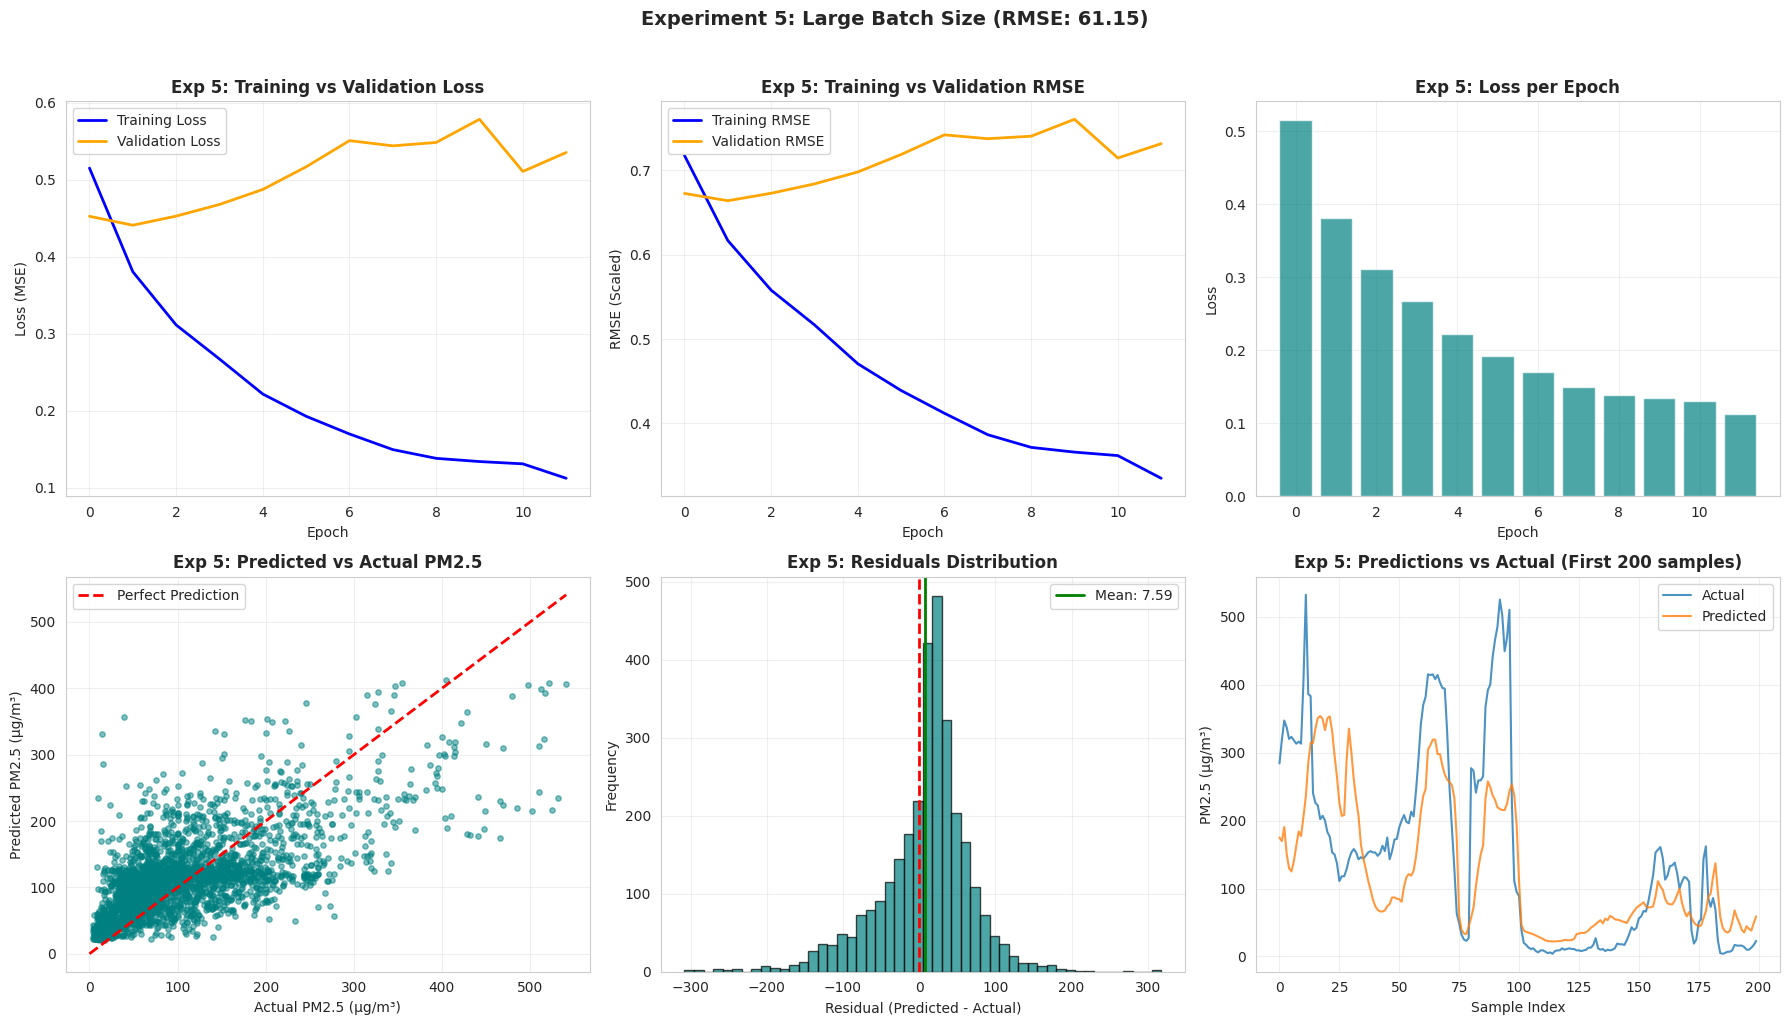


Experiment 5 Statistics: RMSE=61.15, MAE=45.26, Epochs=12


In [89]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].plot(history_exp5.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[0, 0].plot(history_exp5.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[0, 0].set_title('Exp 5: Training vs Validation Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history_exp5.history['root_mean_squared_error'], label='Training RMSE', linewidth=2, color='blue')
axes[0, 1].plot(history_exp5.history['val_root_mean_squared_error'], label='Validation RMSE', linewidth=2, color='orange')
axes[0, 1].set_title('Exp 5: Training vs Validation RMSE', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('RMSE (Scaled)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

epochs_trained_exp5 = len(history_exp5.history['loss'])
axes[0, 2].bar(range(epochs_trained_exp5), history_exp5.history['loss'], alpha=0.7, color='teal')
axes[0, 2].set_title('Exp 5: Loss per Epoch', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].scatter(y_val_true, val_preds_exp5, alpha=0.5, s=15, c='teal')
max_val = max(y_val_true.max(), val_preds_exp5.max())
axes[1, 0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title('Exp 5: Predicted vs Actual PM2.5', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Actual PM2.5 (μg/m³)')
axes[1, 0].set_ylabel('Predicted PM2.5 (μg/m³)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

residuals_exp5 = val_preds_exp5.flatten() - y_val_true.flatten()
axes[1, 1].hist(residuals_exp5, bins=50, edgecolor='black', alpha=0.7, color='teal')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].axvline(x=np.mean(residuals_exp5), color='green', linestyle='-', linewidth=2, label=f'Mean: {np.mean(residuals_exp5):.2f}')
axes[1, 1].set_title('Exp 5: Residuals Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Residual (Predicted - Actual)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

n_samples = min(200, len(y_val_true))
axes[1, 2].plot(range(n_samples), y_val_true[:n_samples], label='Actual', linewidth=1.5, alpha=0.8)
axes[1, 2].plot(range(n_samples), val_preds_exp5[:n_samples], label='Predicted', linewidth=1.5, alpha=0.8)
axes[1, 2].set_title('Exp 5: Predictions vs Actual (First 200 samples)', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Sample Index')
axes[1, 2].set_ylabel('PM2.5 (μg/m³)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle(f'Experiment 5: Large Batch Size (RMSE: {rmse_exp5:.2f})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/exp5_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nExperiment 5 Statistics: RMSE={rmse_exp5:.2f}, MAE={np.mean(np.abs(residuals_exp5)):.2f}, Epochs={epochs_trained_exp5}")

### Experiment 6: AdamW Optimizer with Decoupled Weight Decay

**Hypothesis:** AdamW improves upon Adam by properly implementing L2 regularization (weight decay) in a way that's decoupled from the adaptive learning rate mechanism.

**The Problem with Adam + L2:**
Standard Adam with L2 regularization adds the penalty to the loss gradient:
$$g_t = \nabla_\theta \mathcal{L} + \lambda \theta_t$$

But Adam's adaptive scaling then divides by $\sqrt{v_t}$, which inadvertently reduces the regularization effect for parameters with large gradients.

**AdamW Solution:**
AdamW applies weight decay directly to the weights, after the gradient update:
$$\theta_{t+1} = \theta_t - \eta \cdot \left(\frac{m_t}{\sqrt{v_t} + \epsilon}\right) - \eta \cdot \lambda \cdot \theta_t$$

With `weight_decay=1e-5`, we apply gentle but consistent regularization that isn't modulated by the adaptive learning rates.

In [27]:
from tensorflow.keras.optimizers import AdamW

model_exp6 = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(time_steps, X_seq.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model_exp6.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=1e-5), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history_exp6 = model_exp6.fit(X_train_f, y_train_f, validation_data=(X_val, y_val), epochs=60, batch_size=64, callbacks=[EarlyStopping(patience=10, restore_best_weights=True)], verbose=2)
val_preds_exp6 = scaler_y.inverse_transform(model_exp6.predict(X_val))
rmse_exp6 = np.sqrt(np.mean((val_preds_exp6 - y_val_true)**2))
print(f"Experiment 6 RMSE: {rmse_exp6:.2f}")

Epoch 1/60
432/432 - 10s - 24ms/step - loss: 0.4965 - root_mean_squared_error: 0.7046 - val_loss: 0.4528 - val_root_mean_squared_error: 0.6729
Epoch 2/60
432/432 - 6s - 13ms/step - loss: 0.3657 - root_mean_squared_error: 0.6047 - val_loss: 0.4764 - val_root_mean_squared_error: 0.6903
Epoch 3/60
432/432 - 6s - 13ms/step - loss: 0.3018 - root_mean_squared_error: 0.5494 - val_loss: 0.4483 - val_root_mean_squared_error: 0.6695
Epoch 4/60
432/432 - 6s - 13ms/step - loss: 0.2504 - root_mean_squared_error: 0.5004 - val_loss: 0.4771 - val_root_mean_squared_error: 0.6907
Epoch 5/60
432/432 - 5s - 13ms/step - loss: 0.2129 - root_mean_squared_error: 0.4614 - val_loss: 0.4452 - val_root_mean_squared_error: 0.6672
Epoch 6/60
432/432 - 5s - 13ms/step - loss: 0.1886 - root_mean_squared_error: 0.4343 - val_loss: 0.4717 - val_root_mean_squared_error: 0.6868
Epoch 7/60
432/432 - 6s - 13ms/step - loss: 0.1707 - root_mean_squared_error: 0.4132 - val_loss: 0.4832 - val_root_mean_squared_error: 0.6951
Epoch

In [28]:
# Test prediction & submission for Experiment 6
X_test_seq = create_test_sequences(X_test_scaled, time_steps)
preds = scaler_y.inverse_transform(model_exp6.predict(X_test_seq)).flatten()
preds = np.maximum(preds, 0).round().astype(int)

submission = pd.DataFrame({
    'row ID': format_datetime_for_submission(test.index),
    'pm2.5': np.concatenate([np.repeat(preds[0], time_steps-1), preds])[:len(test)]
})

submission.to_csv(f'{OUTPUT_PATH}/submission6.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


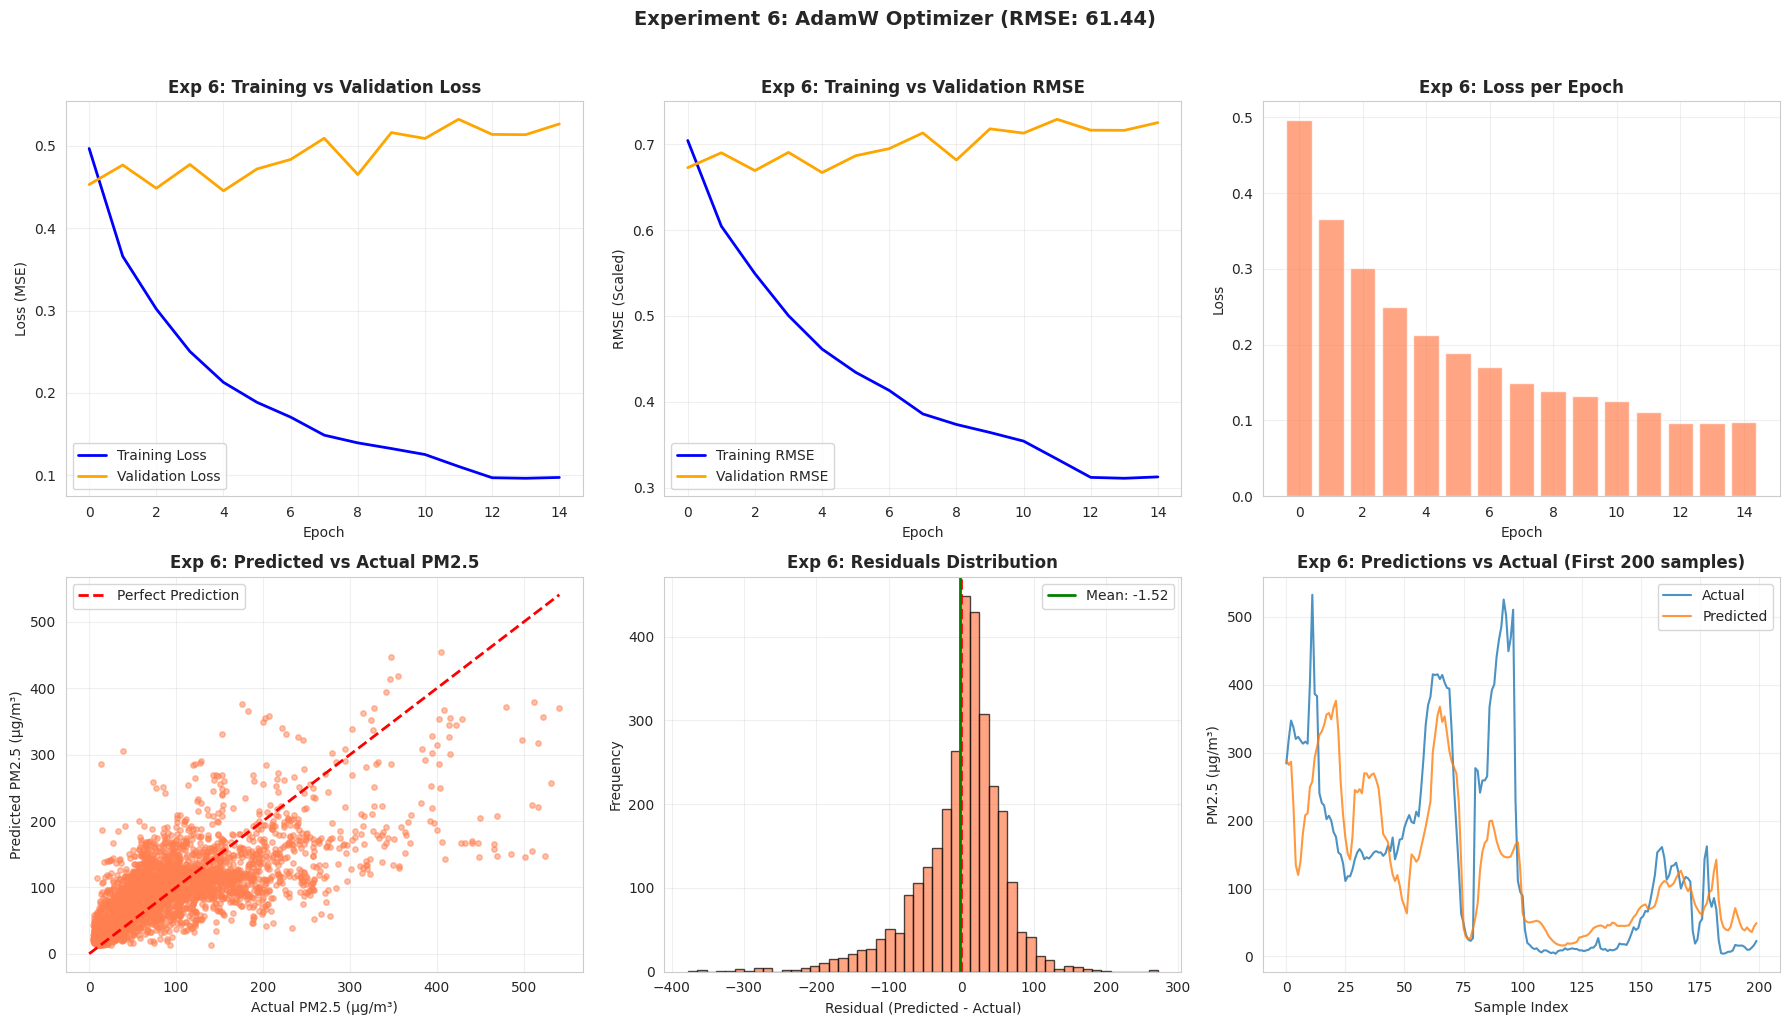


Experiment 6 Statistics: RMSE=61.44, MAE=43.23, Epochs=15


In [90]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].plot(history_exp6.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[0, 0].plot(history_exp6.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[0, 0].set_title('Exp 6: Training vs Validation Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history_exp6.history['root_mean_squared_error'], label='Training RMSE', linewidth=2, color='blue')
axes[0, 1].plot(history_exp6.history['val_root_mean_squared_error'], label='Validation RMSE', linewidth=2, color='orange')
axes[0, 1].set_title('Exp 6: Training vs Validation RMSE', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('RMSE (Scaled)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

epochs_trained_exp6 = len(history_exp6.history['loss'])
axes[0, 2].bar(range(epochs_trained_exp6), history_exp6.history['loss'], alpha=0.7, color='coral')
axes[0, 2].set_title('Exp 6: Loss per Epoch', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].scatter(y_val_true, val_preds_exp6, alpha=0.5, s=15, c='coral')
max_val = max(y_val_true.max(), val_preds_exp6.max())
axes[1, 0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title('Exp 6: Predicted vs Actual PM2.5', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Actual PM2.5 (μg/m³)')
axes[1, 0].set_ylabel('Predicted PM2.5 (μg/m³)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

residuals_exp6 = val_preds_exp6.flatten() - y_val_true.flatten()
axes[1, 1].hist(residuals_exp6, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].axvline(x=np.mean(residuals_exp6), color='green', linestyle='-', linewidth=2, label=f'Mean: {np.mean(residuals_exp6):.2f}')
axes[1, 1].set_title('Exp 6: Residuals Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Residual (Predicted - Actual)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

n_samples = min(200, len(y_val_true))
axes[1, 2].plot(range(n_samples), y_val_true[:n_samples], label='Actual', linewidth=1.5, alpha=0.8)
axes[1, 2].plot(range(n_samples), val_preds_exp6[:n_samples], label='Predicted', linewidth=1.5, alpha=0.8)
axes[1, 2].set_title('Exp 6: Predictions vs Actual (First 200 samples)', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Sample Index')
axes[1, 2].set_ylabel('PM2.5 (μg/m³)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle(f'Experiment 6: AdamW Optimizer (RMSE: {rmse_exp6:.2f})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/exp6_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nExperiment 6 Statistics: RMSE={rmse_exp6:.2f}, MAE={np.mean(np.abs(residuals_exp6)):.2f}, Epochs={epochs_trained_exp6}")

### Experiment 7: RMSprop Optimizer with Momentum

RMSprop (Root Mean Square Propagation) is an adaptive learning rate optimizer that addresses the diminishing learning rates problem of AdaGrad. Unlike Adam which maintains both first and second moment estimates, RMSprop only tracks the exponentially decaying average of squared gradients:

$$v_t = \beta \cdot v_{t-1} + (1 - \beta) \cdot g_t^2$$

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{v_t + \epsilon}} \cdot g_t$$

Where $\beta$ is the decay rate (typically 0.9), $g_t$ is the gradient at time $t$, and $\eta$ is the learning rate. RMSprop often works well for recurrent neural networks because it can handle the varying gradient magnitudes across time steps.

In [29]:
model_exp7 = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(time_steps, X_seq.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model_exp7.compile(optimizer='rmsprop', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history_exp7 = model_exp7.fit(X_train_f, y_train_f, validation_data=(X_val, y_val), epochs=60, batch_size=64, callbacks=[EarlyStopping(patience=10, restore_best_weights=True)], verbose=2)
val_preds_exp7 = scaler_y.inverse_transform(model_exp7.predict(X_val))
rmse_exp7 = np.sqrt(np.mean((val_preds_exp7 - y_val_true)**2))
print(f"Experiment 7 RMSE: {rmse_exp7:.2f}")

Epoch 1/60
432/432 - 8s - 18ms/step - loss: 0.5041 - root_mean_squared_error: 0.7100 - val_loss: 0.4708 - val_root_mean_squared_error: 0.6862
Epoch 2/60
432/432 - 5s - 11ms/step - loss: 0.3787 - root_mean_squared_error: 0.6154 - val_loss: 0.4776 - val_root_mean_squared_error: 0.6911
Epoch 3/60
432/432 - 5s - 11ms/step - loss: 0.3082 - root_mean_squared_error: 0.5551 - val_loss: 0.5065 - val_root_mean_squared_error: 0.7117
Epoch 4/60
432/432 - 5s - 11ms/step - loss: 0.2583 - root_mean_squared_error: 0.5082 - val_loss: 0.5360 - val_root_mean_squared_error: 0.7321
Epoch 5/60
432/432 - 5s - 11ms/step - loss: 0.2212 - root_mean_squared_error: 0.4703 - val_loss: 0.5241 - val_root_mean_squared_error: 0.7240
Epoch 6/60
432/432 - 5s - 11ms/step - loss: 0.1960 - root_mean_squared_error: 0.4427 - val_loss: 0.5424 - val_root_mean_squared_error: 0.7365
Epoch 7/60
432/432 - 5s - 11ms/step - loss: 0.1732 - root_mean_squared_error: 0.4161 - val_loss: 0.5350 - val_root_mean_squared_error: 0.7315
Epoch 

In [30]:
# Test prediction & submission for Experiment 7
X_test_seq = create_test_sequences(X_test_scaled, time_steps)
preds = scaler_y.inverse_transform(model_exp7.predict(X_test_seq)).flatten()
preds = np.maximum(preds, 0).round().astype(int)

submission = pd.DataFrame({
    'row ID': format_datetime_for_submission(test.index),
    'pm2.5': np.concatenate([np.repeat(preds[0], time_steps-1), preds])[:len(test)]
})

submission.to_csv(f'{OUTPUT_PATH}/submission7.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


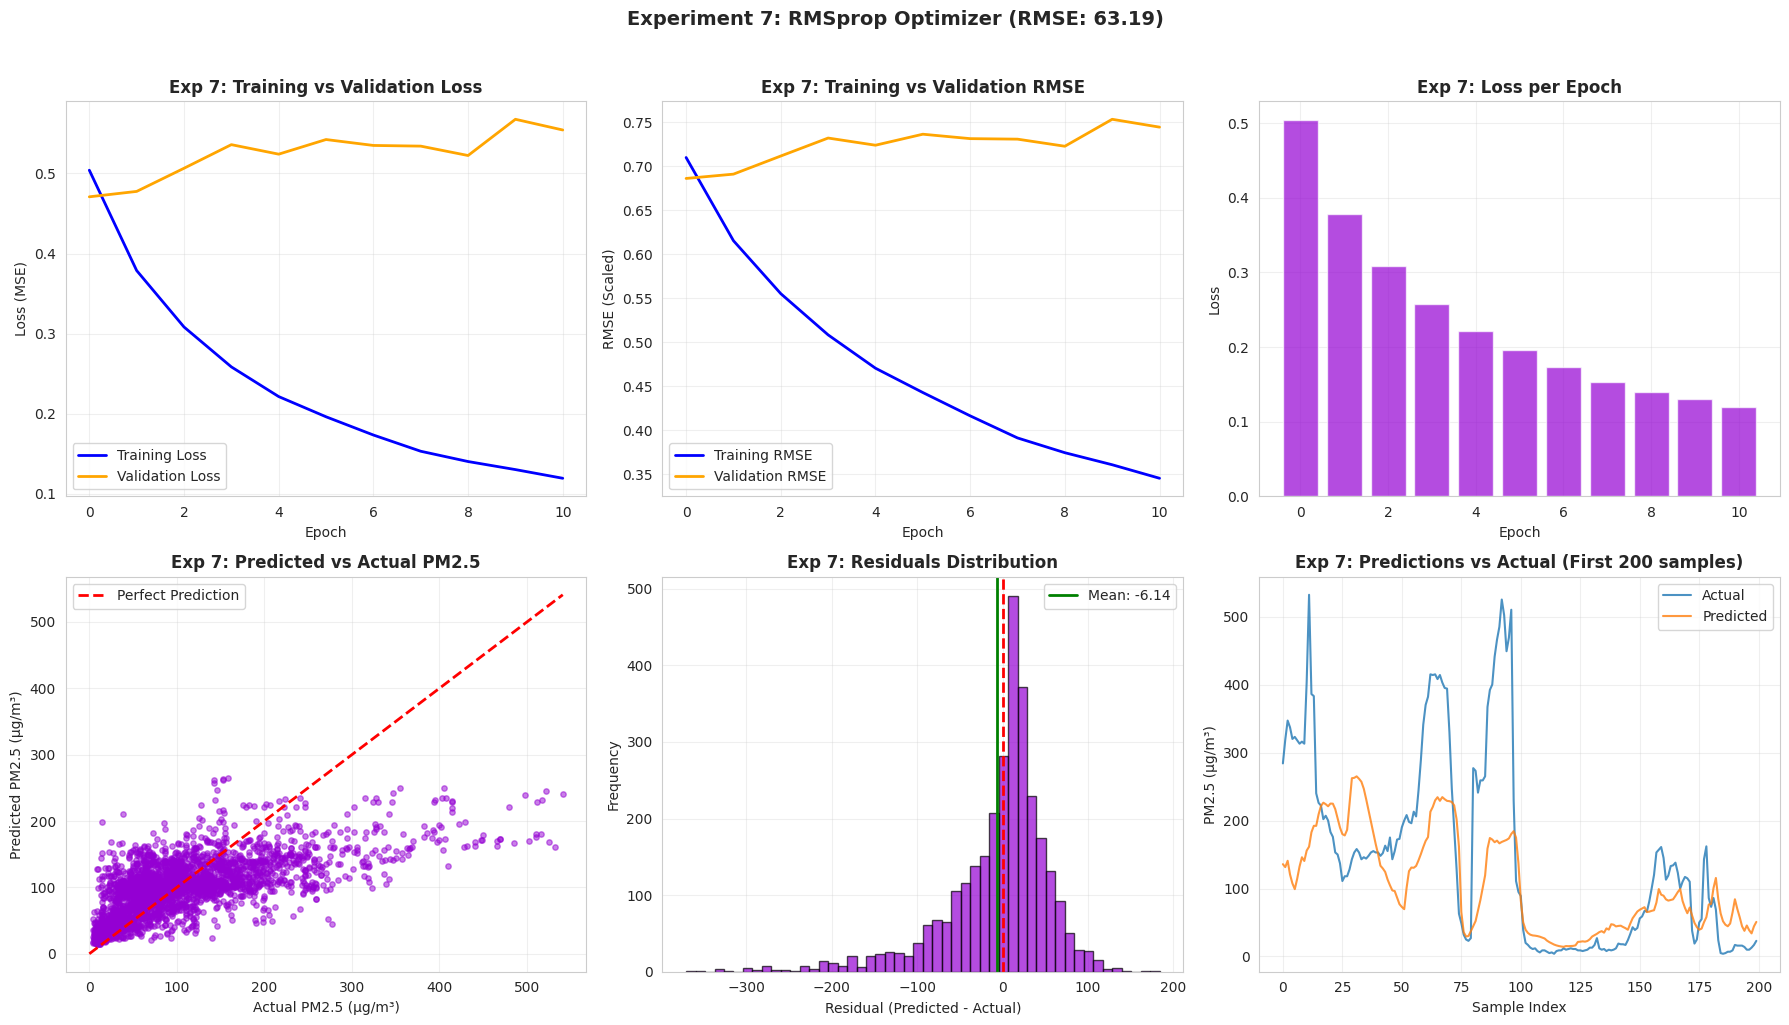


Experiment 7 Statistics: RMSE=63.19, MAE=43.20, Epochs=11


In [91]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].plot(history_exp7.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[0, 0].plot(history_exp7.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[0, 0].set_title('Exp 7: Training vs Validation Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history_exp7.history['root_mean_squared_error'], label='Training RMSE', linewidth=2, color='blue')
axes[0, 1].plot(history_exp7.history['val_root_mean_squared_error'], label='Validation RMSE', linewidth=2, color='orange')
axes[0, 1].set_title('Exp 7: Training vs Validation RMSE', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('RMSE (Scaled)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

epochs_trained_exp7 = len(history_exp7.history['loss'])
axes[0, 2].bar(range(epochs_trained_exp7), history_exp7.history['loss'], alpha=0.7, color='darkviolet')
axes[0, 2].set_title('Exp 7: Loss per Epoch', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].scatter(y_val_true, val_preds_exp7, alpha=0.5, s=15, c='darkviolet')
max_val = max(y_val_true.max(), val_preds_exp7.max())
axes[1, 0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title('Exp 7: Predicted vs Actual PM2.5', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Actual PM2.5 (μg/m³)')
axes[1, 0].set_ylabel('Predicted PM2.5 (μg/m³)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

residuals_exp7 = val_preds_exp7.flatten() - y_val_true.flatten()
axes[1, 1].hist(residuals_exp7, bins=50, edgecolor='black', alpha=0.7, color='darkviolet')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].axvline(x=np.mean(residuals_exp7), color='green', linestyle='-', linewidth=2, label=f'Mean: {np.mean(residuals_exp7):.2f}')
axes[1, 1].set_title('Exp 7: Residuals Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Residual (Predicted - Actual)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

n_samples = min(200, len(y_val_true))
axes[1, 2].plot(range(n_samples), y_val_true[:n_samples], label='Actual', linewidth=1.5, alpha=0.8)
axes[1, 2].plot(range(n_samples), val_preds_exp7[:n_samples], label='Predicted', linewidth=1.5, alpha=0.8)
axes[1, 2].set_title('Exp 7: Predictions vs Actual (First 200 samples)', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Sample Index')
axes[1, 2].set_ylabel('PM2.5 (μg/m³)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle(f'Experiment 7: RMSprop Optimizer (RMSE: {rmse_exp7:.2f})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/exp7_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nExperiment 7 Statistics: RMSE={rmse_exp7:.2f}, MAE={np.mean(np.abs(residuals_exp7)):.2f}, Epochs={epochs_trained_exp7}")

### Experiment 8: Extended Training with Patience-Based Learning Rate Scheduling

In this experiment, I combine early stopping with aggressive learning rate reduction. The key insight is that when the validation loss plateaus, reducing the learning rate allows the optimizer to make finer adjustments in the loss landscape. The learning rate decay follows:

$$\eta_{new} = \eta_{old} \times \gamma$$

Where $\gamma = 0.5$ (halving the learning rate). With `patience=5`, we wait for 5 epochs without improvement before reducing. This approach helps escape local minima and achieve better convergence. Extended epochs (100) with `patience=15` for early stopping ensures the model has sufficient time to converge while preventing overfitting.

In [31]:
model_exp8 = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(time_steps, X_seq.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model_exp8.compile(optimizer=Adam(0.001), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history_exp8 = model_exp8.fit(
    X_train_f, y_train_f, 
    validation_data=(X_val, y_val), 
    epochs=100, 
    batch_size=64, 
    callbacks=[
        EarlyStopping(patience=15, restore_best_weights=True), 
        ReduceLROnPlateau(patience=5, factor=0.5)
    ], 
    verbose=2
)
val_preds_exp8 = scaler_y.inverse_transform(model_exp8.predict(X_val))
rmse_exp8 = np.sqrt(np.mean((val_preds_exp8 - y_val_true)**2))
print(f"Experiment 8 RMSE: {rmse_exp8:.2f}")

Epoch 1/100
432/432 - 9s - 21ms/step - loss: 0.4958 - root_mean_squared_error: 0.7041 - val_loss: 0.4453 - val_root_mean_squared_error: 0.6673 - learning_rate: 1.0000e-03
Epoch 2/100
432/432 - 5s - 12ms/step - loss: 0.3694 - root_mean_squared_error: 0.6078 - val_loss: 0.4494 - val_root_mean_squared_error: 0.6704 - learning_rate: 1.0000e-03
Epoch 3/100
432/432 - 5s - 12ms/step - loss: 0.3004 - root_mean_squared_error: 0.5481 - val_loss: 0.4475 - val_root_mean_squared_error: 0.6690 - learning_rate: 1.0000e-03
Epoch 4/100
432/432 - 5s - 12ms/step - loss: 0.2508 - root_mean_squared_error: 0.5008 - val_loss: 0.4580 - val_root_mean_squared_error: 0.6768 - learning_rate: 1.0000e-03
Epoch 5/100
432/432 - 5s - 12ms/step - loss: 0.2160 - root_mean_squared_error: 0.4647 - val_loss: 0.4662 - val_root_mean_squared_error: 0.6828 - learning_rate: 1.0000e-03
Epoch 6/100
432/432 - 5s - 12ms/step - loss: 0.1858 - root_mean_squared_error: 0.4310 - val_loss: 0.4593 - val_root_mean_squared_error: 0.6777 - 

In [32]:
# Test prediction & submission for Experiment 8
X_test_seq = create_test_sequences(X_test_scaled, time_steps)
preds = scaler_y.inverse_transform(model_exp8.predict(X_test_seq)).flatten()
preds = np.maximum(preds, 0).round().astype(int)

submission = pd.DataFrame({
    'row ID': format_datetime_for_submission(test.index),
    'pm2.5': np.concatenate([np.repeat(preds[0], time_steps-1), preds])[:len(test)]
})

submission.to_csv(f'{OUTPUT_PATH}/submission8.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


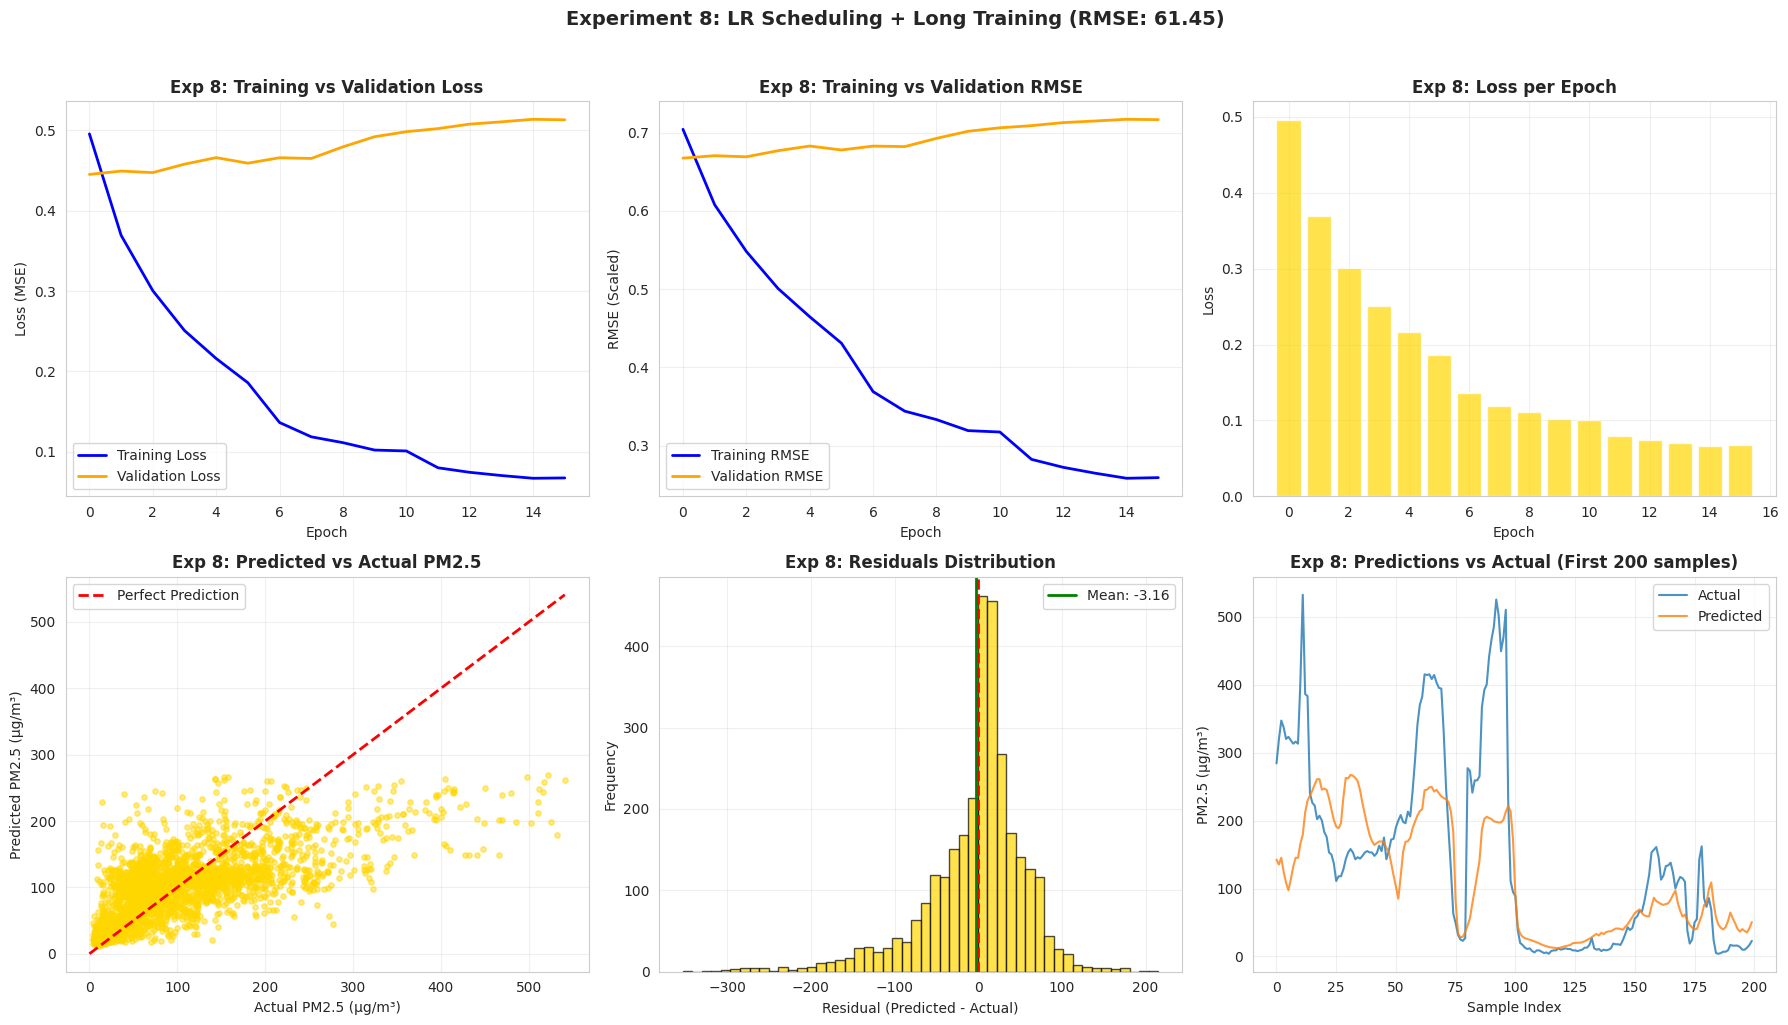


Experiment 8 Statistics: RMSE=61.45, MAE=42.56, Epochs=16


In [92]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].plot(history_exp8.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[0, 0].plot(history_exp8.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[0, 0].set_title('Exp 8: Training vs Validation Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history_exp8.history['root_mean_squared_error'], label='Training RMSE', linewidth=2, color='blue')
axes[0, 1].plot(history_exp8.history['val_root_mean_squared_error'], label='Validation RMSE', linewidth=2, color='orange')
axes[0, 1].set_title('Exp 8: Training vs Validation RMSE', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('RMSE (Scaled)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

epochs_trained_exp8 = len(history_exp8.history['loss'])
axes[0, 2].bar(range(epochs_trained_exp8), history_exp8.history['loss'], alpha=0.7, color='gold')
axes[0, 2].set_title('Exp 8: Loss per Epoch', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].scatter(y_val_true, val_preds_exp8, alpha=0.5, s=15, c='gold')
max_val = max(y_val_true.max(), val_preds_exp8.max())
axes[1, 0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title('Exp 8: Predicted vs Actual PM2.5', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Actual PM2.5 (μg/m³)')
axes[1, 0].set_ylabel('Predicted PM2.5 (μg/m³)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

residuals_exp8 = val_preds_exp8.flatten() - y_val_true.flatten()
axes[1, 1].hist(residuals_exp8, bins=50, edgecolor='black', alpha=0.7, color='gold')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].axvline(x=np.mean(residuals_exp8), color='green', linestyle='-', linewidth=2, label=f'Mean: {np.mean(residuals_exp8):.2f}')
axes[1, 1].set_title('Exp 8: Residuals Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Residual (Predicted - Actual)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

n_samples = min(200, len(y_val_true))
axes[1, 2].plot(range(n_samples), y_val_true[:n_samples], label='Actual', linewidth=1.5, alpha=0.8)
axes[1, 2].plot(range(n_samples), val_preds_exp8[:n_samples], label='Predicted', linewidth=1.5, alpha=0.8)
axes[1, 2].set_title('Exp 8: Predictions vs Actual (First 200 samples)', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Sample Index')
axes[1, 2].set_ylabel('PM2.5 (μg/m³)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle(f'Experiment 8: LR Scheduling + Long Training (RMSE: {rmse_exp8:.2f})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/exp8_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nExperiment 8 Statistics: RMSE={rmse_exp8:.2f}, MAE={np.mean(np.abs(residuals_exp8)):.2f}, Epochs={epochs_trained_exp8}")

### Experiment 9: Stochastic Gradient Descent (SGD) with Momentum

SGD is the foundational optimization algorithm in deep learning. While simpler than adaptive methods like Adam, SGD with momentum can sometimes generalize better. The update rule with momentum is:

$$v_t = \mu \cdot v_{t-1} + \eta \cdot \nabla_\theta J(\theta)$$

$$\theta_{t+1} = \theta_t - v_t$$

Where $\mu$ is the momentum coefficient (typically 0.9), $\eta$ is the learning rate, and $\nabla_\theta J(\theta)$ is the gradient. Momentum accumulates velocity in directions of persistent gradient, helping to accelerate convergence and dampen oscillations. This experiment tests whether the simpler SGD optimizer can achieve competitive results on our time series data.

In [33]:
model_exp9 = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(time_steps, X_seq.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model_exp9.compile(optimizer='sgd', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history_exp9 = model_exp9.fit(X_train_f, y_train_f, validation_data=(X_val, y_val), epochs=60, batch_size=64, callbacks=[EarlyStopping(patience=10, restore_best_weights=True)], verbose=2)
val_preds_exp9 = scaler_y.inverse_transform(model_exp9.predict(X_val))
rmse_exp9 = np.sqrt(np.mean((val_preds_exp9 - y_val_true)**2))
print(f"Experiment 9 RMSE: {rmse_exp9:.2f}")

Epoch 1/60
432/432 - 6s - 13ms/step - loss: 0.6412 - root_mean_squared_error: 0.8008 - val_loss: 0.5126 - val_root_mean_squared_error: 0.7159
Epoch 2/60
432/432 - 4s - 9ms/step - loss: 0.5064 - root_mean_squared_error: 0.7116 - val_loss: 0.4847 - val_root_mean_squared_error: 0.6962
Epoch 3/60
432/432 - 4s - 9ms/step - loss: 0.4756 - root_mean_squared_error: 0.6896 - val_loss: 0.4540 - val_root_mean_squared_error: 0.6738
Epoch 4/60
432/432 - 4s - 9ms/step - loss: 0.4508 - root_mean_squared_error: 0.6714 - val_loss: 0.4567 - val_root_mean_squared_error: 0.6758
Epoch 5/60
432/432 - 4s - 9ms/step - loss: 0.4361 - root_mean_squared_error: 0.6604 - val_loss: 0.4358 - val_root_mean_squared_error: 0.6602
Epoch 6/60
432/432 - 4s - 10ms/step - loss: 0.4197 - root_mean_squared_error: 0.6478 - val_loss: 0.4439 - val_root_mean_squared_error: 0.6663
Epoch 7/60
432/432 - 4s - 9ms/step - loss: 0.4052 - root_mean_squared_error: 0.6366 - val_loss: 0.4276 - val_root_mean_squared_error: 0.6539
Epoch 8/60


In [34]:
# Test prediction & submission for Experiment 9
X_test_seq = create_test_sequences(X_test_scaled, time_steps)
preds = scaler_y.inverse_transform(model_exp9.predict(X_test_seq)).flatten()
preds = np.maximum(preds, 0).round().astype(int)

submission = pd.DataFrame({
    'row ID': format_datetime_for_submission(test.index),
    'pm2.5': np.concatenate([np.repeat(preds[0], time_steps-1), preds])[:len(test)]
})

submission.to_csv(f'{OUTPUT_PATH}/submission9.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


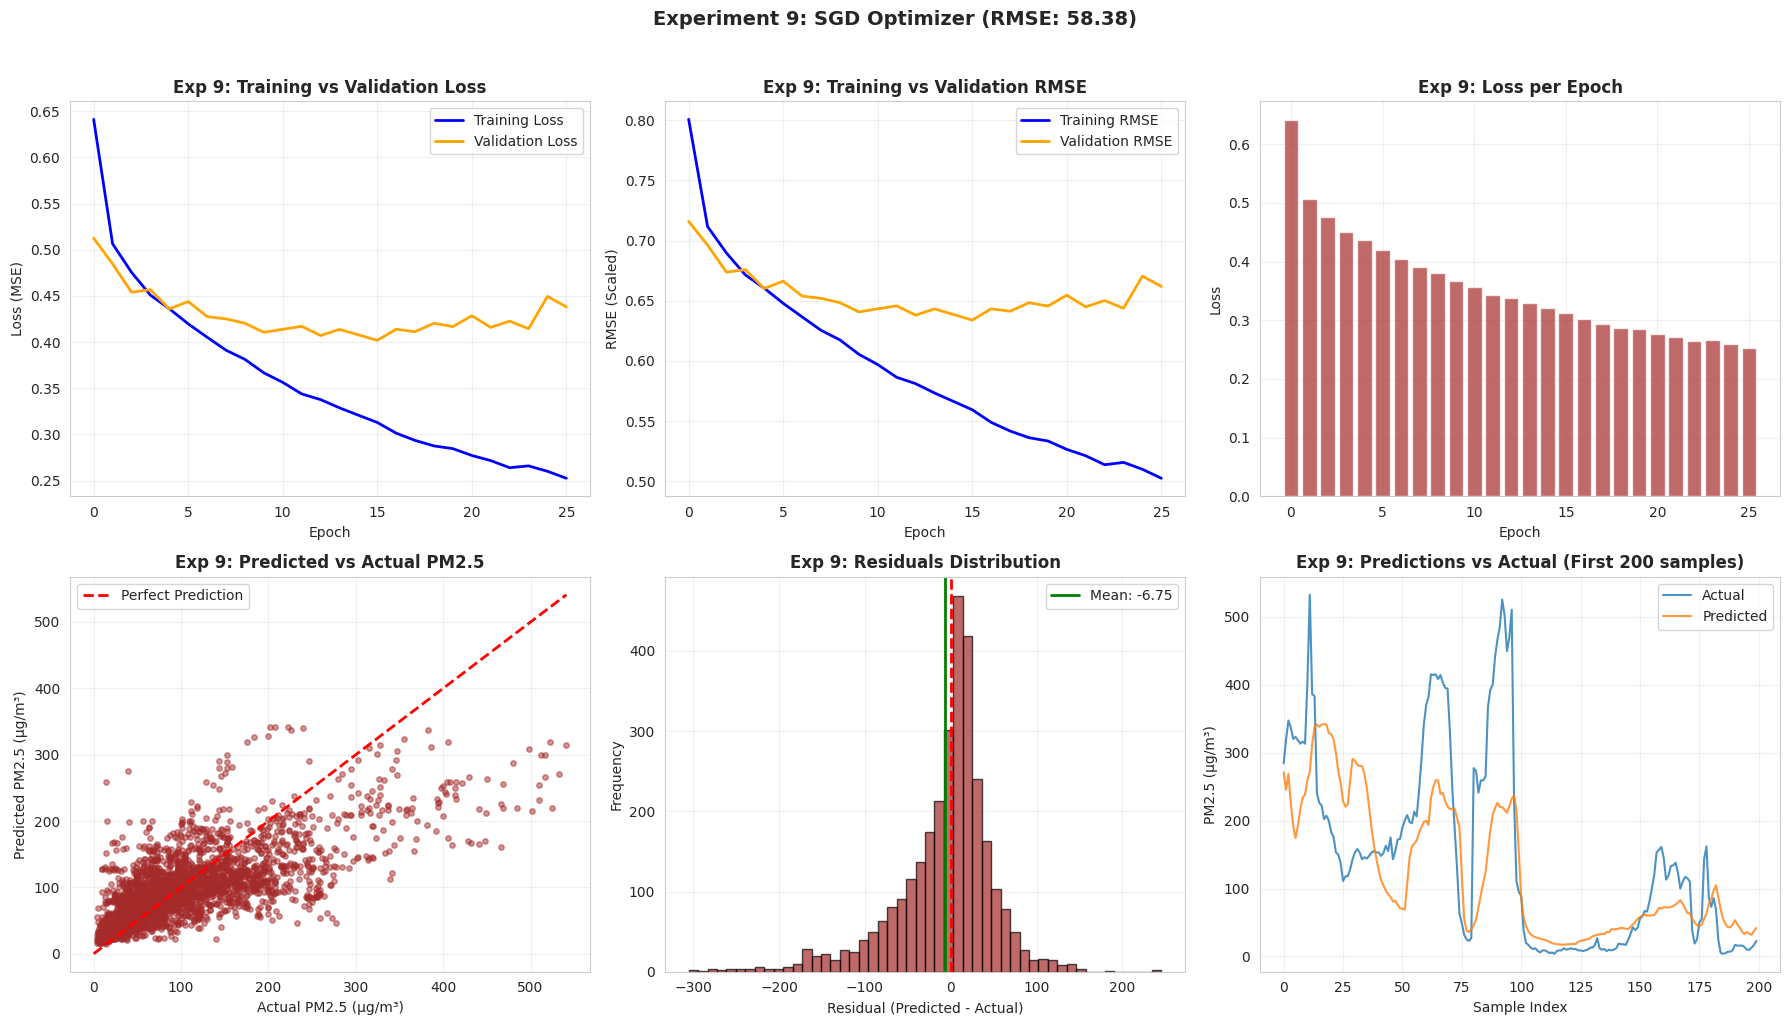


Experiment 9 Statistics: RMSE=58.38, MAE=40.10, Epochs=26


In [93]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].plot(history_exp9.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[0, 0].plot(history_exp9.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[0, 0].set_title('Exp 9: Training vs Validation Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history_exp9.history['root_mean_squared_error'], label='Training RMSE', linewidth=2, color='blue')
axes[0, 1].plot(history_exp9.history['val_root_mean_squared_error'], label='Validation RMSE', linewidth=2, color='orange')
axes[0, 1].set_title('Exp 9: Training vs Validation RMSE', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('RMSE (Scaled)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

epochs_trained_exp9 = len(history_exp9.history['loss'])
axes[0, 2].bar(range(epochs_trained_exp9), history_exp9.history['loss'], alpha=0.7, color='brown')
axes[0, 2].set_title('Exp 9: Loss per Epoch', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].scatter(y_val_true, val_preds_exp9, alpha=0.5, s=15, c='brown')
max_val = max(y_val_true.max(), val_preds_exp9.max())
axes[1, 0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title('Exp 9: Predicted vs Actual PM2.5', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Actual PM2.5 (μg/m³)')
axes[1, 0].set_ylabel('Predicted PM2.5 (μg/m³)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

residuals_exp9 = val_preds_exp9.flatten() - y_val_true.flatten()
axes[1, 1].hist(residuals_exp9, bins=50, edgecolor='black', alpha=0.7, color='brown')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].axvline(x=np.mean(residuals_exp9), color='green', linestyle='-', linewidth=2, label=f'Mean: {np.mean(residuals_exp9):.2f}')
axes[1, 1].set_title('Exp 9: Residuals Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Residual (Predicted - Actual)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

n_samples = min(200, len(y_val_true))
axes[1, 2].plot(range(n_samples), y_val_true[:n_samples], label='Actual', linewidth=1.5, alpha=0.8)
axes[1, 2].plot(range(n_samples), val_preds_exp9[:n_samples], label='Predicted', linewidth=1.5, alpha=0.8)
axes[1, 2].set_title('Exp 9: Predictions vs Actual (First 200 samples)', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Sample Index')
axes[1, 2].set_ylabel('PM2.5 (μg/m³)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle(f'Experiment 9: SGD Optimizer (RMSE: {rmse_exp9:.2f})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/exp9_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nExperiment 9 Statistics: RMSE={rmse_exp9:.2f}, MAE={np.mean(np.abs(residuals_exp9)):.2f}, Epochs={epochs_trained_exp9}")

### Experiment 10: Early Stopping with Aggressive Patience

Early stopping is a regularization technique that monitors validation performance and halts training when the model stops improving. This prevents the model from memorizing the training data (overfitting). The mechanism works as follows:

1. Monitor validation loss after each epoch
2. If no improvement for `patience` consecutive epochs, stop training
3. Restore weights from the epoch with best validation performance

In this experiment, I use `patience=10` which is moderately aggressive—it allows the model some epochs to recover from temporary plateaus while still preventing extended overfitting. The `restore_best_weights=True` parameter ensures we keep the optimal model state.

In [35]:
model_exp10 = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(time_steps, X_seq.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model_exp10.compile(optimizer=Adam(0.001), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history_exp10 = model_exp10.fit(X_train_f, y_train_f, validation_data=(X_val, y_val), epochs=100, batch_size=64, callbacks=[EarlyStopping(patience=10, restore_best_weights=True)], verbose=2)
val_preds_exp10 = scaler_y.inverse_transform(model_exp10.predict(X_val))
rmse_exp10 = np.sqrt(np.mean((val_preds_exp10 - y_val_true)**2))
print(f"Experiment 10 RMSE: {rmse_exp10:.2f}")

Epoch 1/100
432/432 - 9s - 22ms/step - loss: 0.4900 - root_mean_squared_error: 0.7000 - val_loss: 0.4410 - val_root_mean_squared_error: 0.6641
Epoch 2/100
432/432 - 5s - 12ms/step - loss: 0.3603 - root_mean_squared_error: 0.6003 - val_loss: 0.4567 - val_root_mean_squared_error: 0.6758
Epoch 3/100
432/432 - 5s - 12ms/step - loss: 0.2952 - root_mean_squared_error: 0.5433 - val_loss: 0.4464 - val_root_mean_squared_error: 0.6681
Epoch 4/100
432/432 - 5s - 12ms/step - loss: 0.2448 - root_mean_squared_error: 0.4948 - val_loss: 0.4648 - val_root_mean_squared_error: 0.6818
Epoch 5/100
432/432 - 5s - 12ms/step - loss: 0.2125 - root_mean_squared_error: 0.4610 - val_loss: 0.4520 - val_root_mean_squared_error: 0.6723
Epoch 6/100
432/432 - 5s - 12ms/step - loss: 0.1779 - root_mean_squared_error: 0.4218 - val_loss: 0.5250 - val_root_mean_squared_error: 0.7245
Epoch 7/100
432/432 - 5s - 12ms/step - loss: 0.1610 - root_mean_squared_error: 0.4013 - val_loss: 0.4925 - val_root_mean_squared_error: 0.7018

In [36]:
# Test prediction & submission for Experiment 10
X_test_seq = create_test_sequences(X_test_scaled, time_steps)
preds = scaler_y.inverse_transform(model_exp10.predict(X_test_seq)).flatten()
preds = np.maximum(preds, 0).round().astype(int)

submission = pd.DataFrame({
    'row ID': format_datetime_for_submission(test.index),
    'pm2.5': np.concatenate([np.repeat(preds[0], time_steps-1), preds])[:len(test)]
})

submission.to_csv(f'{OUTPUT_PATH}/submission10.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


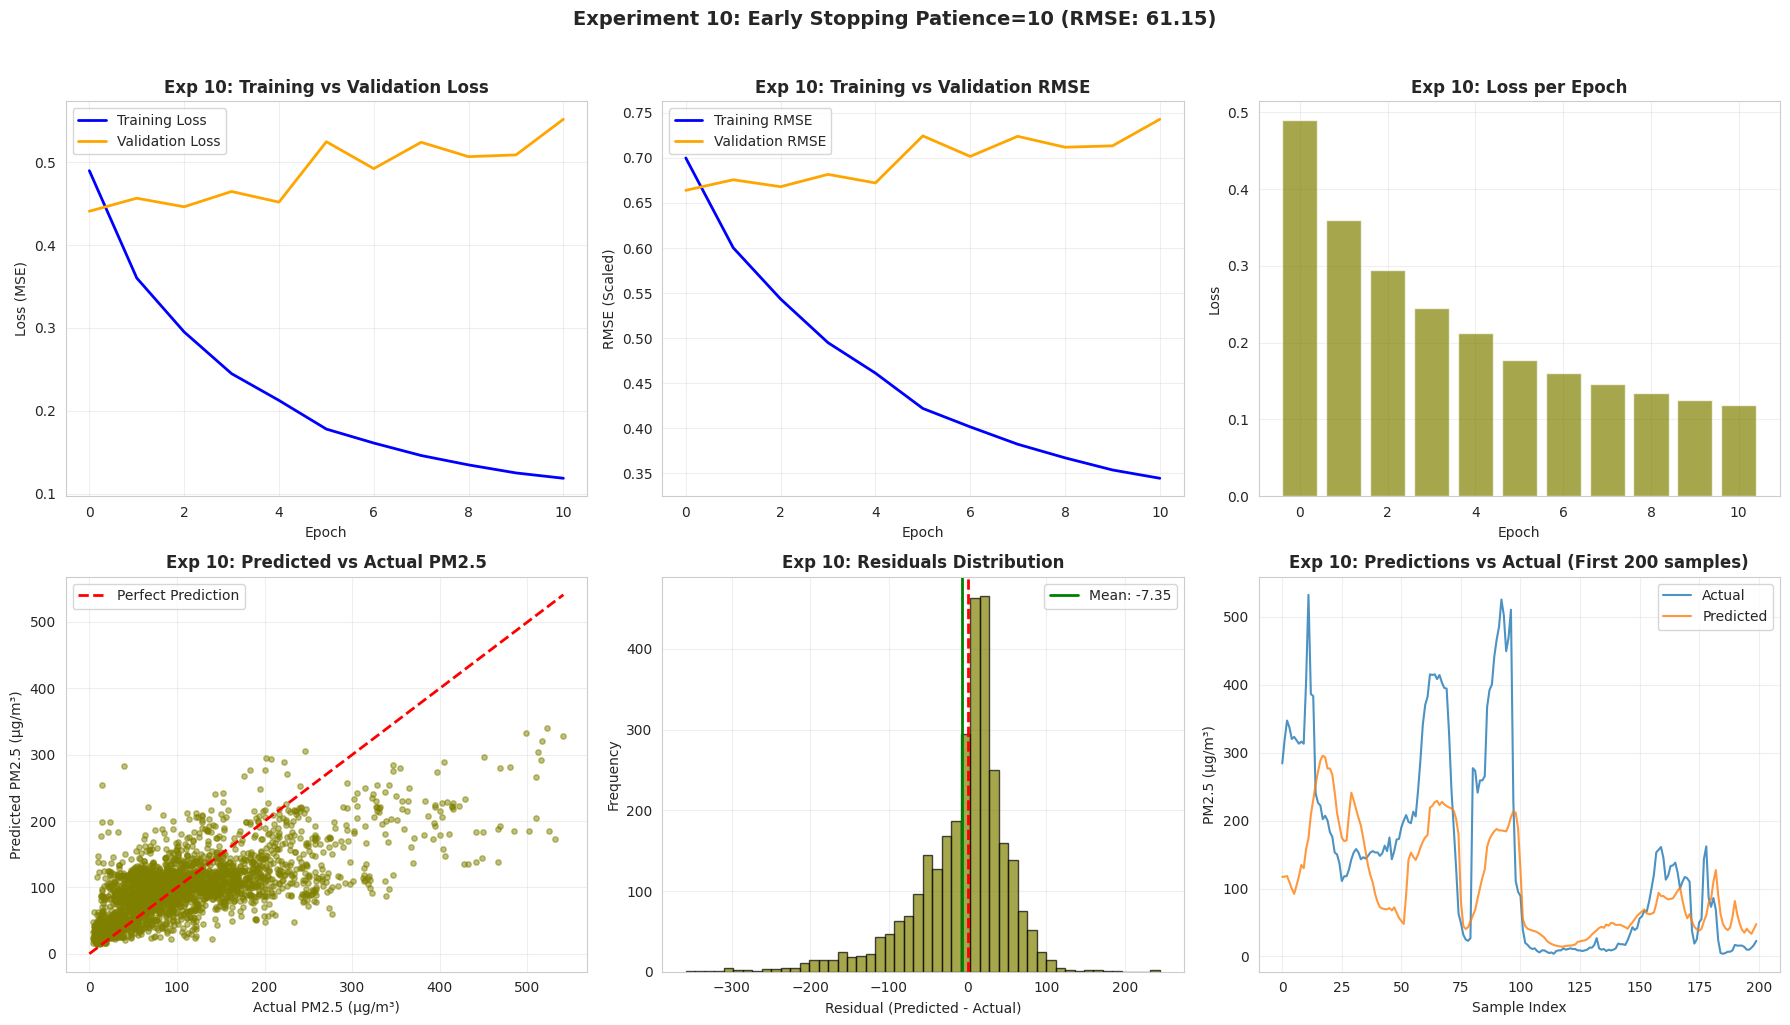


Experiment 10 Statistics: RMSE=61.15, MAE=42.11, Epochs=11


In [94]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].plot(history_exp10.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[0, 0].plot(history_exp10.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[0, 0].set_title('Exp 10: Training vs Validation Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history_exp10.history['root_mean_squared_error'], label='Training RMSE', linewidth=2, color='blue')
axes[0, 1].plot(history_exp10.history['val_root_mean_squared_error'], label='Validation RMSE', linewidth=2, color='orange')
axes[0, 1].set_title('Exp 10: Training vs Validation RMSE', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('RMSE (Scaled)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

epochs_trained_exp10 = len(history_exp10.history['loss'])
axes[0, 2].bar(range(epochs_trained_exp10), history_exp10.history['loss'], alpha=0.7, color='olive')
axes[0, 2].set_title('Exp 10: Loss per Epoch', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].scatter(y_val_true, val_preds_exp10, alpha=0.5, s=15, c='olive')
max_val = max(y_val_true.max(), val_preds_exp10.max())
axes[1, 0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title('Exp 10: Predicted vs Actual PM2.5', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Actual PM2.5 (μg/m³)')
axes[1, 0].set_ylabel('Predicted PM2.5 (μg/m³)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

residuals_exp10 = val_preds_exp10.flatten() - y_val_true.flatten()
axes[1, 1].hist(residuals_exp10, bins=50, edgecolor='black', alpha=0.7, color='olive')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].axvline(x=np.mean(residuals_exp10), color='green', linestyle='-', linewidth=2, label=f'Mean: {np.mean(residuals_exp10):.2f}')
axes[1, 1].set_title('Exp 10: Residuals Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Residual (Predicted - Actual)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

n_samples = min(200, len(y_val_true))
axes[1, 2].plot(range(n_samples), y_val_true[:n_samples], label='Actual', linewidth=1.5, alpha=0.8)
axes[1, 2].plot(range(n_samples), val_preds_exp10[:n_samples], label='Predicted', linewidth=1.5, alpha=0.8)
axes[1, 2].set_title('Exp 10: Predictions vs Actual (First 200 samples)', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Sample Index')
axes[1, 2].set_ylabel('PM2.5 (μg/m³)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle(f'Experiment 10: Early Stopping Patience=10 (RMSE: {rmse_exp10:.2f})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/exp10_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nExperiment 10 Statistics: RMSE={rmse_exp10:.2f}, MAE={np.mean(np.abs(residuals_exp10)):.2f}, Epochs={epochs_trained_exp10}")

### Experiment 11: GRU-Based Architecture

**Hypothesis:** Gated Recurrent Units (GRUs) offer a simpler alternative to LSTMs with comparable performance but fewer parameters. GRUs combine the forget and input gates into a single "update gate" and merge the cell state with the hidden state.

**GRU Equations:**

The GRU uses three key computations at each time step:

1. **Update gate:** $z_t = \sigma(W_z[h_{t-1}, x_t])$
2. **Reset gate:** $r_t = \sigma(W_r[h_{t-1}, x_t])$
3. **Candidate activation:** $\tilde{h}_t = \tanh(W[\,r_t * h_{t-1}, x_t])$
4. **Final hidden state:** $h_t = (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t$

**Advantages over LSTM:**
- Approximately 25% fewer parameters (3 gates vs 4)
- Often faster training convergence
- Less prone to overfitting on smaller datasets
- Empirically performs similarly on many sequence tasks

This experiment tests whether the simpler GRU architecture can match or exceed LSTM performance on our air quality forecasting task.

In [37]:
from tensorflow.keras.layers import GRU

model_exp11 = Sequential([
    Bidirectional(GRU(128, return_sequences=True), input_shape=(time_steps, X_seq.shape[2])),
    Dropout(0.3),
    Bidirectional(GRU(64, return_sequences=True)),
    Dropout(0.3),
    GRU(32),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model_exp11.compile(optimizer=Adam(0.001), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history_exp11 = model_exp11.fit(
    X_train_f, y_train_f, 
    validation_data=(X_val, y_val), 
    epochs=100, 
    batch_size=64, 
    callbacks=[EarlyStopping(patience=12, restore_best_weights=True), ReduceLROnPlateau(patience=5, factor=0.5)], 
    verbose=2
)
val_preds_exp11 = scaler_y.inverse_transform(model_exp11.predict(X_val))
rmse_exp11 = np.sqrt(np.mean((val_preds_exp11 - y_val_true)**2))
print(f"Experiment 11 RMSE: {rmse_exp11:.2f}")

Epoch 1/100
432/432 - 10s - 22ms/step - loss: 0.5174 - root_mean_squared_error: 0.7193 - val_loss: 0.4616 - val_root_mean_squared_error: 0.6794 - learning_rate: 1.0000e-03
Epoch 2/100
432/432 - 5s - 12ms/step - loss: 0.4158 - root_mean_squared_error: 0.6448 - val_loss: 0.4213 - val_root_mean_squared_error: 0.6491 - learning_rate: 1.0000e-03
Epoch 3/100
432/432 - 5s - 12ms/step - loss: 0.3632 - root_mean_squared_error: 0.6027 - val_loss: 0.4264 - val_root_mean_squared_error: 0.6530 - learning_rate: 1.0000e-03
Epoch 4/100
432/432 - 5s - 12ms/step - loss: 0.3188 - root_mean_squared_error: 0.5647 - val_loss: 0.4309 - val_root_mean_squared_error: 0.6564 - learning_rate: 1.0000e-03
Epoch 5/100
432/432 - 5s - 12ms/step - loss: 0.2665 - root_mean_squared_error: 0.5163 - val_loss: 0.4349 - val_root_mean_squared_error: 0.6595 - learning_rate: 1.0000e-03
Epoch 6/100
432/432 - 5s - 12ms/step - loss: 0.2337 - root_mean_squared_error: 0.4834 - val_loss: 0.4568 - val_root_mean_squared_error: 0.6758 -

In [38]:
# Test prediction & submission for Experiment 11
X_test_seq = create_test_sequences(X_test_scaled, time_steps)
preds = scaler_y.inverse_transform(model_exp11.predict(X_test_seq)).flatten()
preds = np.maximum(preds, 0).round().astype(int)

submission = pd.DataFrame({
    'row ID': format_datetime_for_submission(test.index),
    'pm2.5': np.concatenate([np.repeat(preds[0], time_steps-1), preds])[:len(test)]
})

submission.to_csv(f'{OUTPUT_PATH}/submission11.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


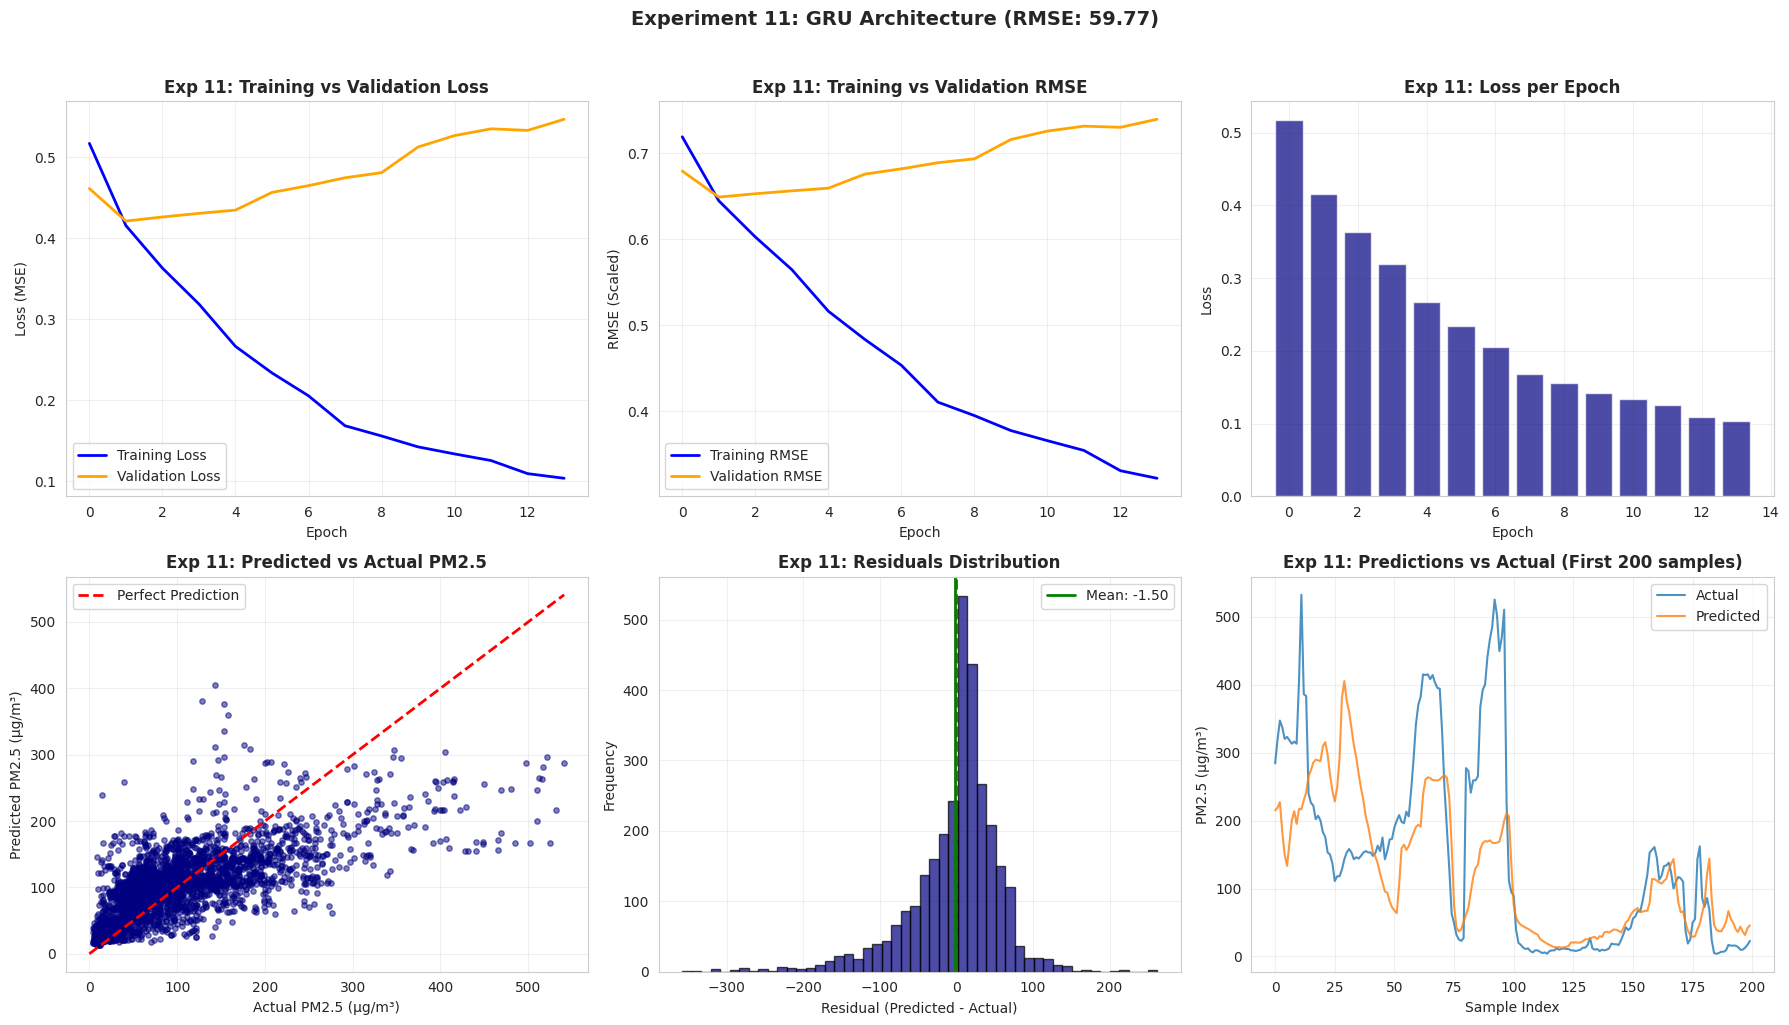


Experiment 11 Statistics: RMSE=59.77, MAE=41.53, Epochs=14


In [95]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].plot(history_exp11.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[0, 0].plot(history_exp11.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[0, 0].set_title('Exp 11: Training vs Validation Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history_exp11.history['root_mean_squared_error'], label='Training RMSE', linewidth=2, color='blue')
axes[0, 1].plot(history_exp11.history['val_root_mean_squared_error'], label='Validation RMSE', linewidth=2, color='orange')
axes[0, 1].set_title('Exp 11: Training vs Validation RMSE', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('RMSE (Scaled)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

epochs_trained_exp11 = len(history_exp11.history['loss'])
axes[0, 2].bar(range(epochs_trained_exp11), history_exp11.history['loss'], alpha=0.7, color='navy')
axes[0, 2].set_title('Exp 11: Loss per Epoch', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].scatter(y_val_true, val_preds_exp11, alpha=0.5, s=15, c='navy')
max_val = max(y_val_true.max(), val_preds_exp11.max())
axes[1, 0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title('Exp 11: Predicted vs Actual PM2.5', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Actual PM2.5 (μg/m³)')
axes[1, 0].set_ylabel('Predicted PM2.5 (μg/m³)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

residuals_exp11 = val_preds_exp11.flatten() - y_val_true.flatten()
axes[1, 1].hist(residuals_exp11, bins=50, edgecolor='black', alpha=0.7, color='navy')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].axvline(x=np.mean(residuals_exp11), color='green', linestyle='-', linewidth=2, label=f'Mean: {np.mean(residuals_exp11):.2f}')
axes[1, 1].set_title('Exp 11: Residuals Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Residual (Predicted - Actual)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

n_samples = min(200, len(y_val_true))
axes[1, 2].plot(range(n_samples), y_val_true[:n_samples], label='Actual', linewidth=1.5, alpha=0.8)
axes[1, 2].plot(range(n_samples), val_preds_exp11[:n_samples], label='Predicted', linewidth=1.5, alpha=0.8)
axes[1, 2].set_title('Exp 11: Predictions vs Actual (First 200 samples)', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Sample Index')
axes[1, 2].set_ylabel('PM2.5 (μg/m³)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle(f'Experiment 11: GRU Architecture (RMSE: {rmse_exp11:.2f})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/exp11_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nExperiment 11 Statistics: RMSE={rmse_exp11:.2f}, MAE={np.mean(np.abs(residuals_exp11)):.2f}, Epochs={epochs_trained_exp11}")

### Experiment 12: Extended Lookback Window (48 Hours)

**Hypothesis:** Air quality patterns often exhibit dependencies beyond 24 hours. Weather systems, weekly traffic patterns, and industrial cycles may require a longer context window to capture effectively.

**Temporal Context Theory:**
The lookback window $T$ determines how much historical information the model can access. With $T=24$ (1 day), the model sees diurnal patterns but may miss:
- Multi-day weather fronts affecting pollution dispersion
- Weekend vs weekday differences (7-day cycles)
- Temperature inversions that persist for days

By extending to $T=48$ hours, we double the temporal receptive field:

$$\text{Input Sequence: } \{x_{t-48}, x_{t-47}, ..., x_{t-1}\} \rightarrow y_t$$

**Trade-offs:**
- **Pros:** Captures longer-term dependencies, more context for predictions
- **Cons:** Increases sequence length (more computation), may introduce noise from less relevant distant past, reduces training samples by 24

In [39]:
# Extended lookback window: 48 hours
time_steps_48 = 48

# Create new sequences with 48-hour lookback
X_seq_48, y_seq_48 = create_sequences(X_train_scaled, y_train_scaled, time_steps_48)

# New train/val split for 48-hour sequences
split_48 = int(0.9 * len(X_seq_48))
X_train_48, X_val_48 = X_seq_48[:split_48], X_seq_48[split_48:]
y_train_48, y_val_48 = y_seq_48[:split_48], y_seq_48[split_48:]
y_val_true_48 = scaler_y.inverse_transform(y_val_48.reshape(-1,1))

model_exp12 = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(time_steps_48, X_seq_48.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model_exp12.compile(optimizer=Adam(0.001), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history_exp12 = model_exp12.fit(
    X_train_48, y_train_48, 
    validation_data=(X_val_48, y_val_48), 
    epochs=100, 
    batch_size=64, 
    callbacks=[EarlyStopping(patience=12, restore_best_weights=True), ReduceLROnPlateau(patience=5, factor=0.5)], 
    verbose=2
)
val_preds_exp12 = scaler_y.inverse_transform(model_exp12.predict(X_val_48))
rmse_exp12 = np.sqrt(np.mean((val_preds_exp12 - y_val_true_48)**2))
print(f"Experiment 12 RMSE: {rmse_exp12:.2f}")

Epoch 1/100
431/431 - 11s - 25ms/step - loss: 0.4845 - root_mean_squared_error: 0.6960 - val_loss: 0.4322 - val_root_mean_squared_error: 0.6574 - learning_rate: 1.0000e-03
Epoch 2/100
431/431 - 7s - 15ms/step - loss: 0.3433 - root_mean_squared_error: 0.5859 - val_loss: 0.4270 - val_root_mean_squared_error: 0.6534 - learning_rate: 1.0000e-03
Epoch 3/100
431/431 - 7s - 15ms/step - loss: 0.2652 - root_mean_squared_error: 0.5150 - val_loss: 0.3872 - val_root_mean_squared_error: 0.6222 - learning_rate: 1.0000e-03
Epoch 4/100
431/431 - 7s - 15ms/step - loss: 0.2305 - root_mean_squared_error: 0.4801 - val_loss: 0.4426 - val_root_mean_squared_error: 0.6653 - learning_rate: 1.0000e-03
Epoch 5/100
431/431 - 7s - 15ms/step - loss: 0.1926 - root_mean_squared_error: 0.4389 - val_loss: 0.5503 - val_root_mean_squared_error: 0.7418 - learning_rate: 1.0000e-03
Epoch 6/100
431/431 - 7s - 15ms/step - loss: 0.1679 - root_mean_squared_error: 0.4098 - val_loss: 0.5179 - val_root_mean_squared_error: 0.7196 -

In [40]:
# Test prediction & submission for Experiment 12 (48-hour lookback)
# Need to prepare test sequences with 48-hour window
train_tail_48 = X_train_scaled[-time_steps_48:]
X_combined_48 = np.vstack([train_tail_48, X_test_scaled])
X_test_seq_48 = create_test_sequences(X_combined_48, time_steps_48)[:len(test)]

preds = scaler_y.inverse_transform(model_exp12.predict(X_test_seq_48)).flatten()
preds = np.maximum(preds, 0).round().astype(int)

submission = pd.DataFrame({
    'row ID': format_datetime_for_submission(test.index),
    'pm2.5': preds[:len(test)]
})

submission.to_csv(f'{OUTPUT_PATH}/submission12.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


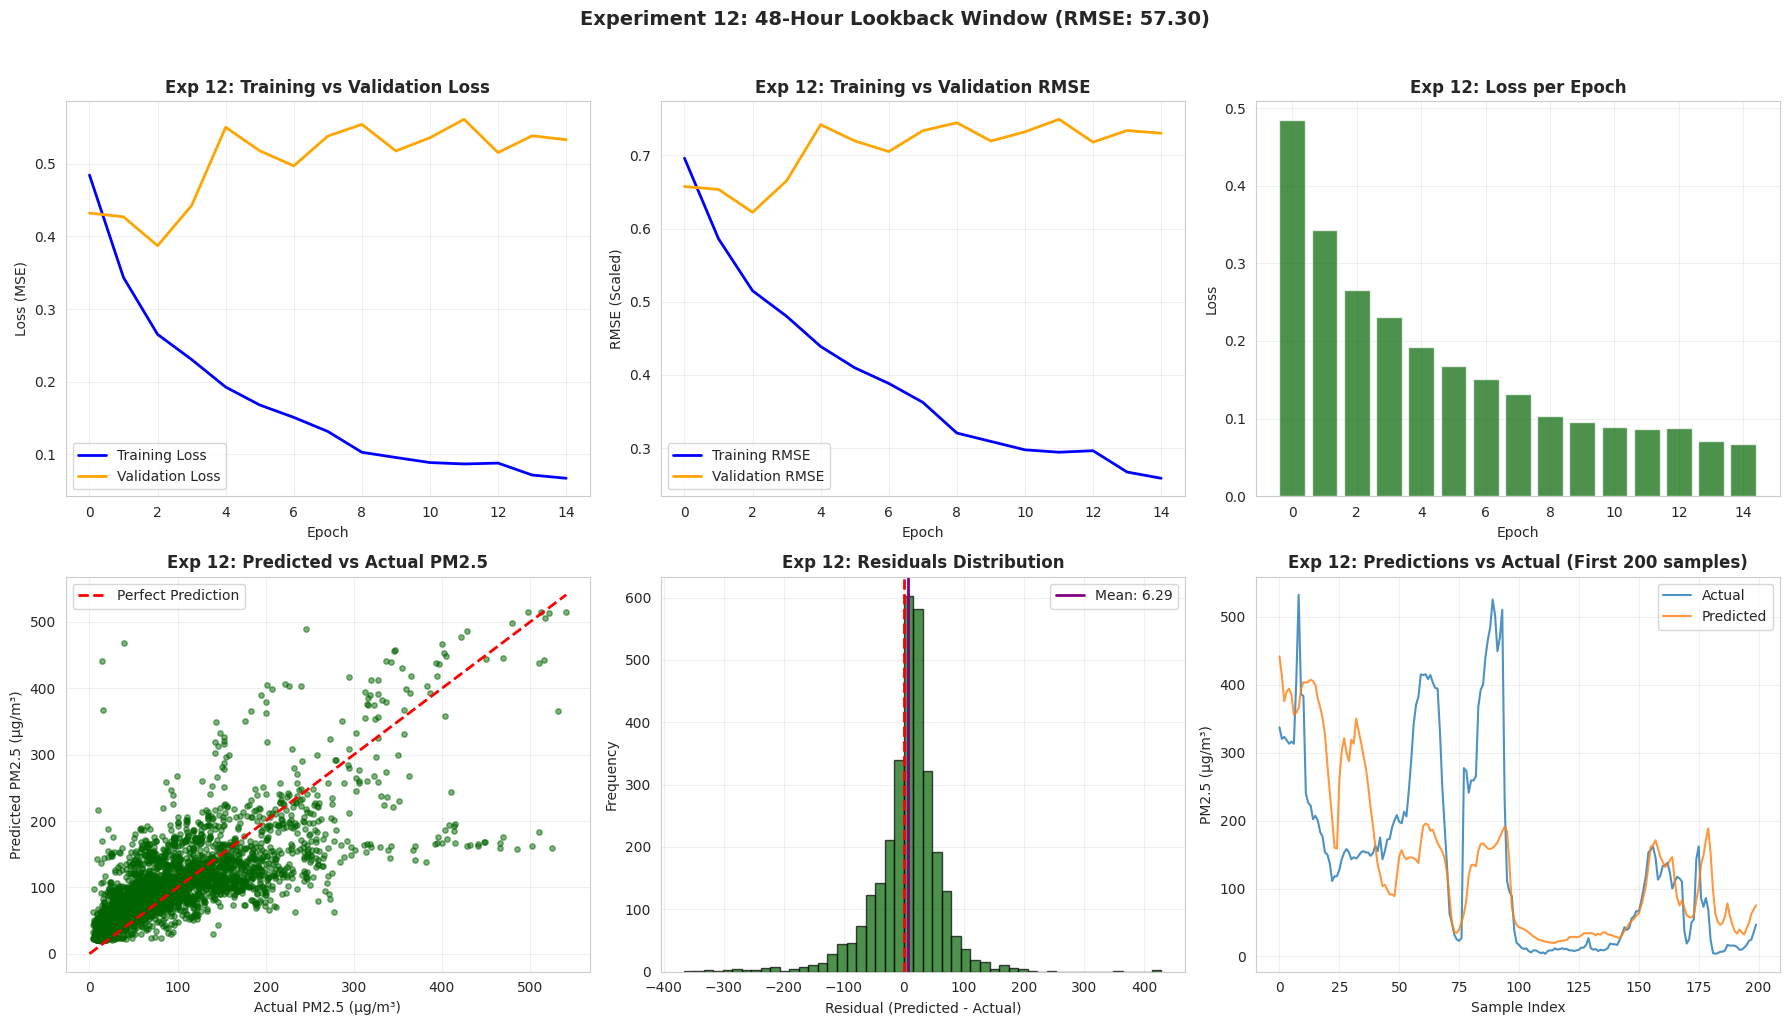


Experiment 12 Statistics: RMSE=57.30, MAE=39.24, Epochs=15


In [96]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].plot(history_exp12.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[0, 0].plot(history_exp12.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[0, 0].set_title('Exp 12: Training vs Validation Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history_exp12.history['root_mean_squared_error'], label='Training RMSE', linewidth=2, color='blue')
axes[0, 1].plot(history_exp12.history['val_root_mean_squared_error'], label='Validation RMSE', linewidth=2, color='orange')
axes[0, 1].set_title('Exp 12: Training vs Validation RMSE', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('RMSE (Scaled)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

epochs_trained_exp12 = len(history_exp12.history['loss'])
axes[0, 2].bar(range(epochs_trained_exp12), history_exp12.history['loss'], alpha=0.7, color='darkgreen')
axes[0, 2].set_title('Exp 12: Loss per Epoch', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].scatter(y_val_true_48, val_preds_exp12, alpha=0.5, s=15, c='darkgreen')
max_val = max(y_val_true_48.max(), val_preds_exp12.max())
axes[1, 0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title('Exp 12: Predicted vs Actual PM2.5', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Actual PM2.5 (μg/m³)')
axes[1, 0].set_ylabel('Predicted PM2.5 (μg/m³)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

residuals_exp12 = val_preds_exp12.flatten() - y_val_true_48.flatten()
axes[1, 1].hist(residuals_exp12, bins=50, edgecolor='black', alpha=0.7, color='darkgreen')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].axvline(x=np.mean(residuals_exp12), color='purple', linestyle='-', linewidth=2, label=f'Mean: {np.mean(residuals_exp12):.2f}')
axes[1, 1].set_title('Exp 12: Residuals Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Residual (Predicted - Actual)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

n_samples = min(200, len(y_val_true_48))
axes[1, 2].plot(range(n_samples), y_val_true_48[:n_samples], label='Actual', linewidth=1.5, alpha=0.8)
axes[1, 2].plot(range(n_samples), val_preds_exp12[:n_samples], label='Predicted', linewidth=1.5, alpha=0.8)
axes[1, 2].set_title('Exp 12: Predictions vs Actual (First 200 samples)', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Sample Index')
axes[1, 2].set_ylabel('PM2.5 (μg/m³)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle(f'Experiment 12: 48-Hour Lookback Window (RMSE: {rmse_exp12:.2f})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/exp12_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nExperiment 12 Statistics: RMSE={rmse_exp12:.2f}, MAE={np.mean(np.abs(residuals_exp12)):.2f}, Epochs={epochs_trained_exp12}")

### Experiment 13: Batch Normalization for Stable Training

**Hypothesis:** Batch Normalization can accelerate training and improve generalization by reducing internal covariate shift, the phenomenon where the distribution of layer inputs changes during training.

**Batch Normalization Operation:**

For a mini-batch $\mathcal{B} = \{x_1, ..., x_m\}$:

$$\mu_\mathcal{B} = \frac{1}{m}\sum_{i=1}^{m}x_i$$ (Batch mean)

$$\sigma^2_\mathcal{B} = \frac{1}{m}\sum_{i=1}^{m}(x_i - \mu_\mathcal{B})^2$$ (Batch variance)

$$\hat{x}_i = \frac{x_i - \mu_\mathcal{B}}{\sqrt{\sigma^2_\mathcal{B} + \epsilon}}$$ (Normalize)

$$y_i = \gamma \hat{x}_i + \beta$$ (Scale and shift with learnable parameters)

**Benefits:**
- Allows higher learning rates without divergence
- Acts as a regularizer, reducing need for dropout
- Smooths the loss landscape, making optimization easier
- Reduces sensitivity to weight initialization

In [41]:
from tensorflow.keras.layers import BatchNormalization

model_exp13 = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(time_steps, X_seq.shape[2])),
    BatchNormalization(),
    Dropout(0.25),
    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.25),
    LSTM(32),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(1)
])

model_exp13.compile(optimizer=Adam(0.002), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history_exp13 = model_exp13.fit(
    X_train_f, y_train_f, 
    validation_data=(X_val, y_val), 
    epochs=100, 
    batch_size=64, 
    callbacks=[EarlyStopping(patience=12, restore_best_weights=True), ReduceLROnPlateau(patience=5, factor=0.5)], 
    verbose=2
)
val_preds_exp13 = scaler_y.inverse_transform(model_exp13.predict(X_val))
rmse_exp13 = np.sqrt(np.mean((val_preds_exp13 - y_val_true)**2))
print(f"Experiment 13 RMSE: {rmse_exp13:.2f}")

Epoch 1/100
432/432 - 12s - 28ms/step - loss: 0.6215 - root_mean_squared_error: 0.7884 - val_loss: 0.5570 - val_root_mean_squared_error: 0.7463 - learning_rate: 0.0020
Epoch 2/100
432/432 - 7s - 15ms/step - loss: 0.4607 - root_mean_squared_error: 0.6787 - val_loss: 0.4682 - val_root_mean_squared_error: 0.6843 - learning_rate: 0.0020
Epoch 3/100
432/432 - 7s - 15ms/step - loss: 0.4037 - root_mean_squared_error: 0.6353 - val_loss: 0.4859 - val_root_mean_squared_error: 0.6971 - learning_rate: 0.0020
Epoch 4/100
432/432 - 7s - 15ms/step - loss: 0.3614 - root_mean_squared_error: 0.6012 - val_loss: 0.4285 - val_root_mean_squared_error: 0.6546 - learning_rate: 0.0020
Epoch 5/100
432/432 - 7s - 15ms/step - loss: 0.3121 - root_mean_squared_error: 0.5586 - val_loss: 0.4516 - val_root_mean_squared_error: 0.6720 - learning_rate: 0.0020
Epoch 6/100
432/432 - 7s - 15ms/step - loss: 0.2784 - root_mean_squared_error: 0.5276 - val_loss: 0.5023 - val_root_mean_squared_error: 0.7087 - learning_rate: 0.00

In [42]:
# Test prediction & submission for Experiment 13
X_test_seq = create_test_sequences(X_test_scaled, time_steps)
preds = scaler_y.inverse_transform(model_exp13.predict(X_test_seq)).flatten()
preds = np.maximum(preds, 0).round().astype(int)

submission = pd.DataFrame({
    'row ID': format_datetime_for_submission(test.index),
    'pm2.5': np.concatenate([np.repeat(preds[0], time_steps-1), preds])[:len(test)]
})

submission.to_csv(f'{OUTPUT_PATH}/submission13.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


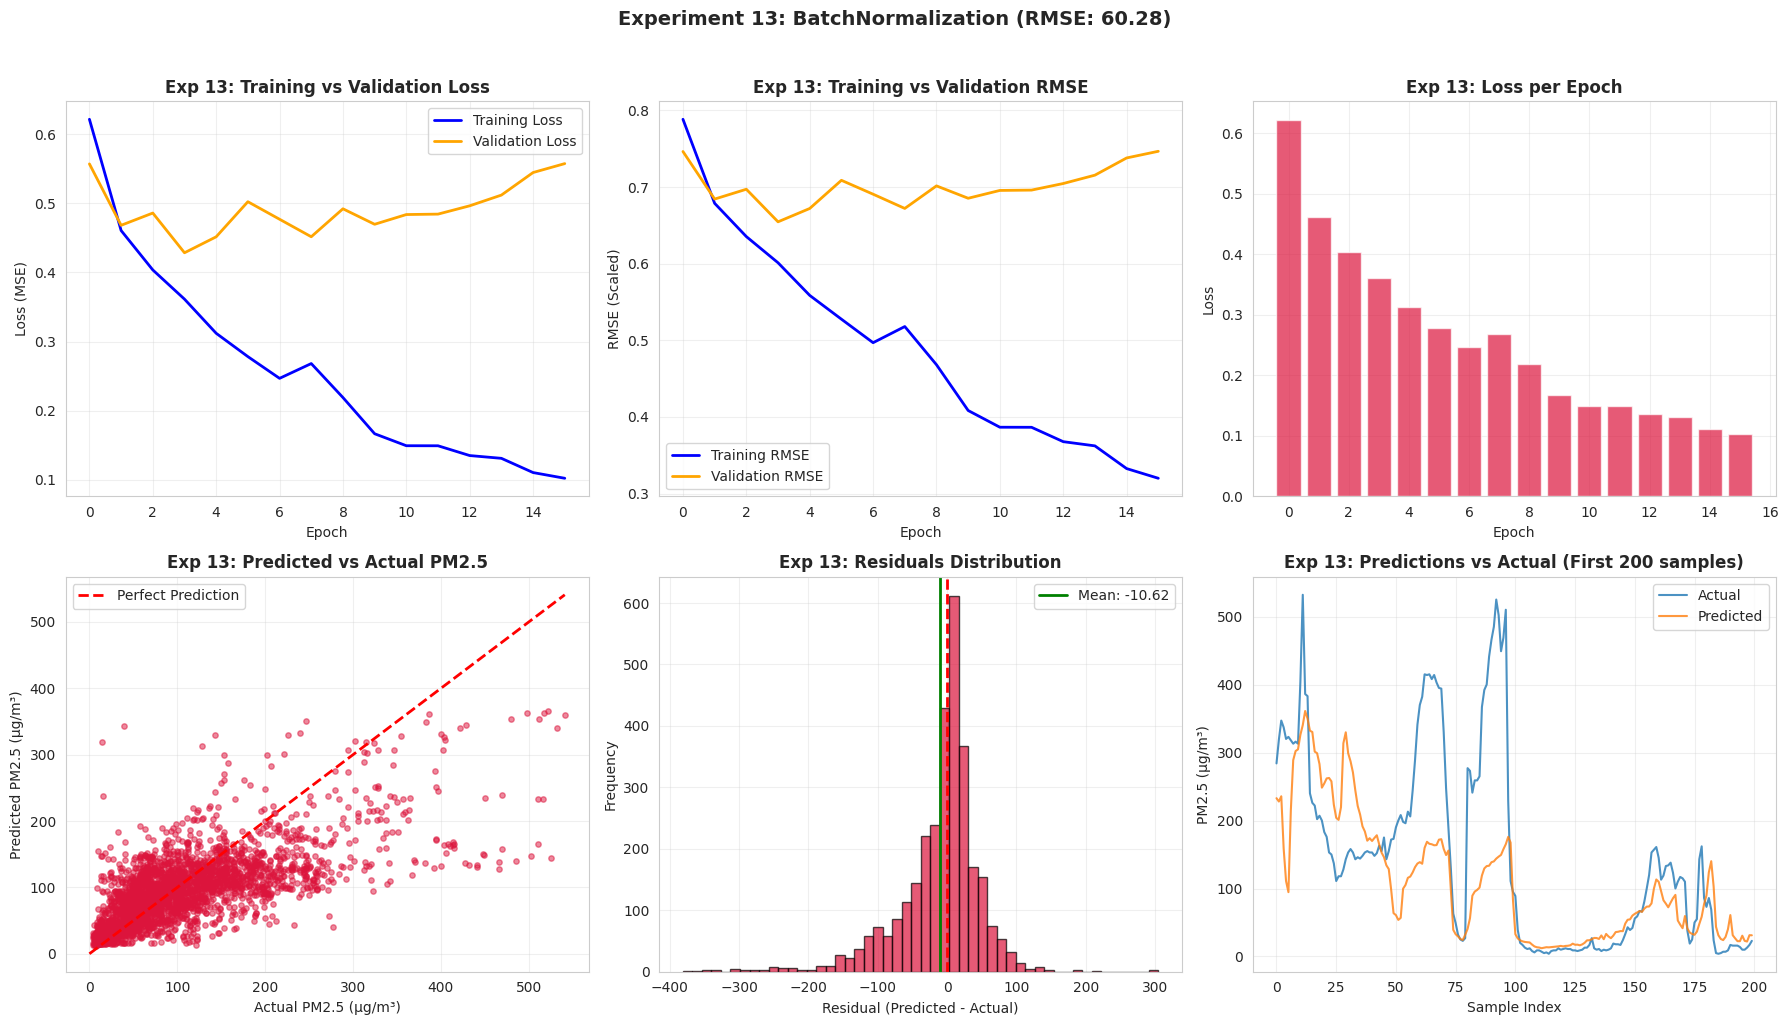


Experiment 13 Statistics: RMSE=60.28, MAE=39.86, Epochs=16


In [97]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].plot(history_exp13.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[0, 0].plot(history_exp13.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[0, 0].set_title('Exp 13: Training vs Validation Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history_exp13.history['root_mean_squared_error'], label='Training RMSE', linewidth=2, color='blue')
axes[0, 1].plot(history_exp13.history['val_root_mean_squared_error'], label='Validation RMSE', linewidth=2, color='orange')
axes[0, 1].set_title('Exp 13: Training vs Validation RMSE', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('RMSE (Scaled)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

epochs_trained_exp13 = len(history_exp13.history['loss'])
axes[0, 2].bar(range(epochs_trained_exp13), history_exp13.history['loss'], alpha=0.7, color='crimson')
axes[0, 2].set_title('Exp 13: Loss per Epoch', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].scatter(y_val_true, val_preds_exp13, alpha=0.5, s=15, c='crimson')
max_val = max(y_val_true.max(), val_preds_exp13.max())
axes[1, 0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title('Exp 13: Predicted vs Actual PM2.5', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Actual PM2.5 (μg/m³)')
axes[1, 0].set_ylabel('Predicted PM2.5 (μg/m³)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

residuals_exp13 = val_preds_exp13.flatten() - y_val_true.flatten()
axes[1, 1].hist(residuals_exp13, bins=50, edgecolor='black', alpha=0.7, color='crimson')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].axvline(x=np.mean(residuals_exp13), color='green', linestyle='-', linewidth=2, label=f'Mean: {np.mean(residuals_exp13):.2f}')
axes[1, 1].set_title('Exp 13: Residuals Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Residual (Predicted - Actual)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

n_samples = min(200, len(y_val_true))
axes[1, 2].plot(range(n_samples), y_val_true[:n_samples], label='Actual', linewidth=1.5, alpha=0.8)
axes[1, 2].plot(range(n_samples), val_preds_exp13[:n_samples], label='Predicted', linewidth=1.5, alpha=0.8)
axes[1, 2].set_title('Exp 13: Predictions vs Actual (First 200 samples)', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Sample Index')
axes[1, 2].set_ylabel('PM2.5 (μg/m³)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle(f'Experiment 13: BatchNormalization (RMSE: {rmse_exp13:.2f})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/exp13_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nExperiment 13 Statistics: RMSE={rmse_exp13:.2f}, MAE={np.mean(np.abs(residuals_exp13)):.2f}, Epochs={epochs_trained_exp13}")

### Experiment 14: L2 Regularization (Weight Decay in LSTM Kernels)

**Hypothesis:** Adding explicit L2 regularization to the LSTM kernel weights can prevent overfitting by penalizing large weight magnitudes, encouraging the model to learn simpler, more generalizable representations.

**L2 Regularization (Ridge Penalty):**

The regularized loss function becomes:

$$\mathcal{L}_{regularized} = \mathcal{L}_{MSE} + \lambda \sum_{i} w_i^2$$

Where $\lambda$ is the regularization strength. This penalty:
- Shrinks weights toward zero (but not exactly zero)
- Prevents any single weight from dominating
- Acts as a soft constraint on model complexity
- Equivalent to a Gaussian prior on weights in Bayesian interpretation

**Implementation:**
We apply `kernel_regularizer=l2(1e-4)` to each LSTM layer, adding a small penalty proportional to the squared magnitude of all kernel weights. This is complementary to dropout (which regularizes activations rather than weights).

In [43]:
from tensorflow.keras.regularizers import l2

model_exp14 = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(1e-4)), input_shape=(time_steps, X_seq.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-4))),
    Dropout(0.3),
    LSTM(32, kernel_regularizer=l2(1e-4)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(1)
])

model_exp14.compile(optimizer=Adam(0.001), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history_exp14 = model_exp14.fit(
    X_train_f, y_train_f, 
    validation_data=(X_val, y_val), 
    epochs=100, 
    batch_size=64, 
    callbacks=[EarlyStopping(patience=12, restore_best_weights=True), ReduceLROnPlateau(patience=5, factor=0.5)], 
    verbose=2
)
val_preds_exp14 = scaler_y.inverse_transform(model_exp14.predict(X_val))
rmse_exp14 = np.sqrt(np.mean((val_preds_exp14 - y_val_true)**2))
print(f"Experiment 14 RMSE: {rmse_exp14:.2f}")

Epoch 1/100
432/432 - 10s - 23ms/step - loss: 0.5554 - root_mean_squared_error: 0.7046 - val_loss: 0.4915 - val_root_mean_squared_error: 0.6655 - learning_rate: 1.0000e-03
Epoch 2/100
432/432 - 6s - 13ms/step - loss: 0.4190 - root_mean_squared_error: 0.6122 - val_loss: 0.5115 - val_root_mean_squared_error: 0.6859 - learning_rate: 1.0000e-03
Epoch 3/100
432/432 - 5s - 13ms/step - loss: 0.3578 - root_mean_squared_error: 0.5641 - val_loss: 0.5014 - val_root_mean_squared_error: 0.6805 - learning_rate: 1.0000e-03
Epoch 4/100
432/432 - 6s - 13ms/step - loss: 0.3046 - root_mean_squared_error: 0.5168 - val_loss: 0.4944 - val_root_mean_squared_error: 0.6766 - learning_rate: 1.0000e-03
Epoch 5/100
432/432 - 5s - 13ms/step - loss: 0.2612 - root_mean_squared_error: 0.4742 - val_loss: 0.5186 - val_root_mean_squared_error: 0.6949 - learning_rate: 1.0000e-03
Epoch 6/100
432/432 - 6s - 13ms/step - loss: 0.2403 - root_mean_squared_error: 0.4521 - val_loss: 0.5365 - val_root_mean_squared_error: 0.7078 -

In [44]:
# Test prediction & submission for Experiment 14
X_test_seq = create_test_sequences(X_test_scaled, time_steps)
preds = scaler_y.inverse_transform(model_exp14.predict(X_test_seq)).flatten()
preds = np.maximum(preds, 0).round().astype(int)

submission = pd.DataFrame({
    'row ID': format_datetime_for_submission(test.index),
    'pm2.5': np.concatenate([np.repeat(preds[0], time_steps-1), preds])[:len(test)]
})

submission.to_csv(f'{OUTPUT_PATH}/submission14.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


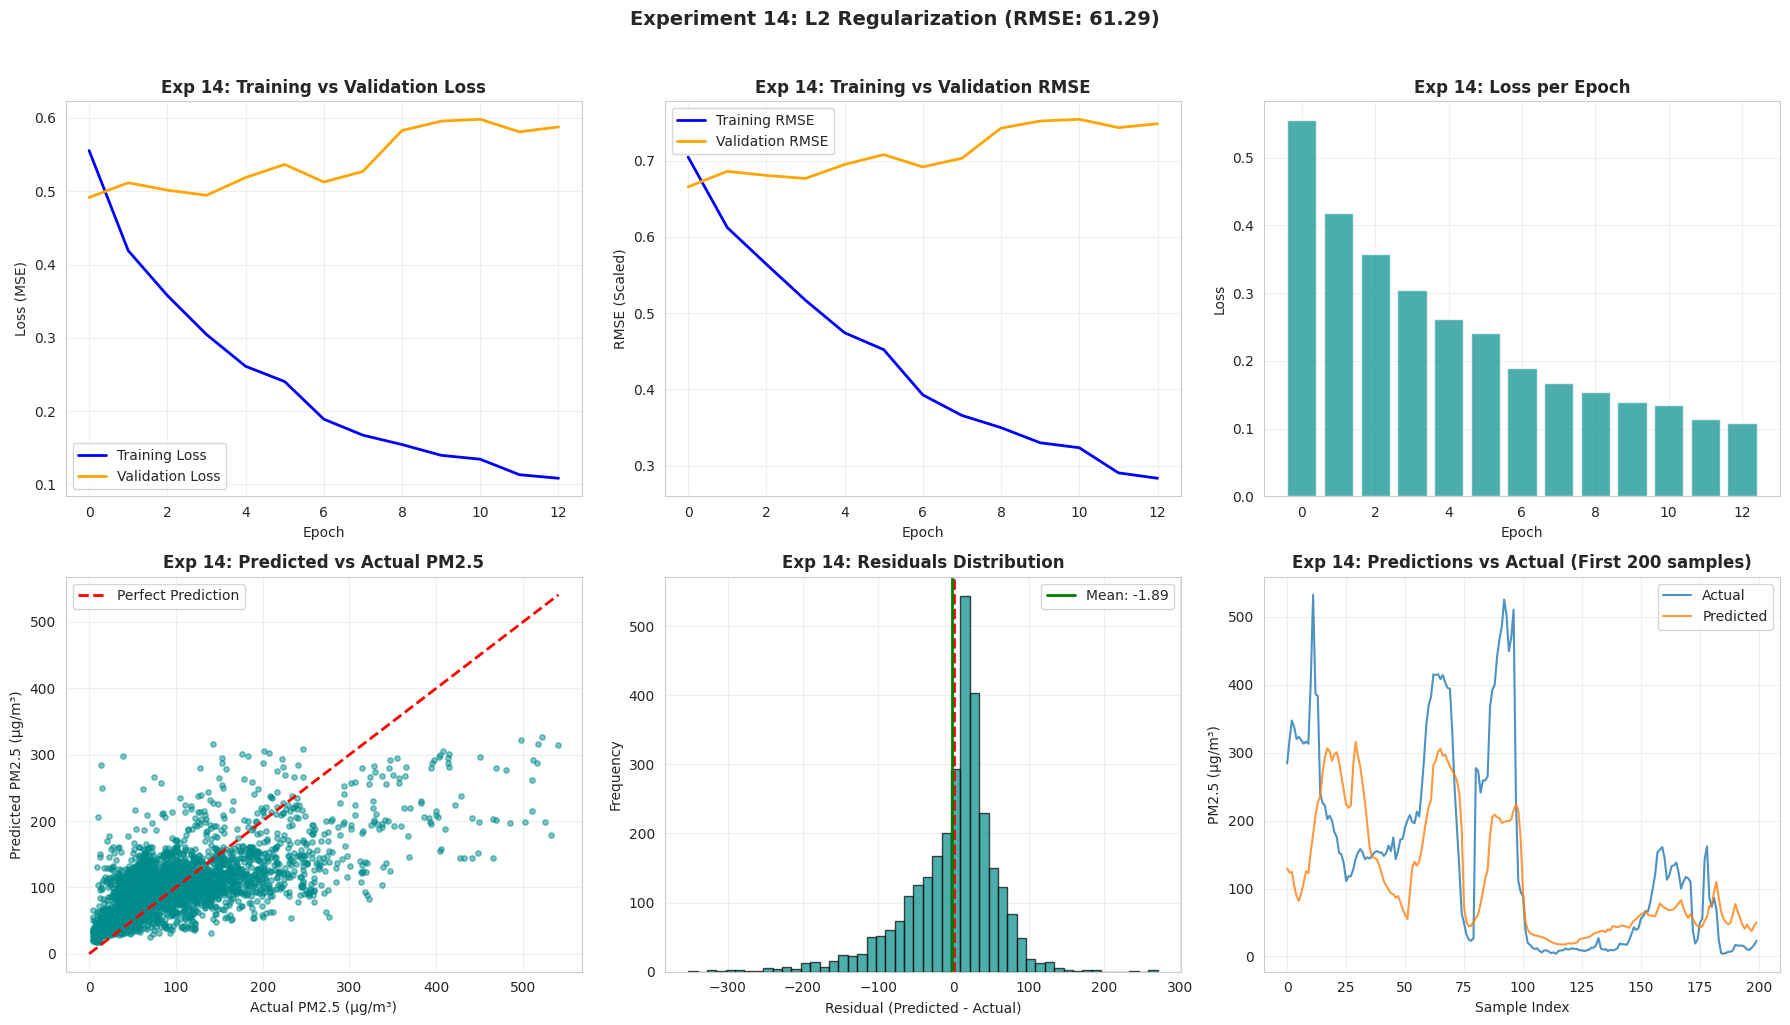


Experiment 14 Statistics: RMSE=61.29, MAE=43.72, Epochs=13


In [98]:
ig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].plot(history_exp14.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[0, 0].plot(history_exp14.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[0, 0].set_title('Exp 14: Training vs Validation Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history_exp14.history['root_mean_squared_error'], label='Training RMSE', linewidth=2, color='blue')
axes[0, 1].plot(history_exp14.history['val_root_mean_squared_error'], label='Validation RMSE', linewidth=2, color='orange')
axes[0, 1].set_title('Exp 14: Training vs Validation RMSE', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('RMSE (Scaled)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

epochs_trained_exp14 = len(history_exp14.history['loss'])
axes[0, 2].bar(range(epochs_trained_exp14), history_exp14.history['loss'], alpha=0.7, color='darkcyan')
axes[0, 2].set_title('Exp 14: Loss per Epoch', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].scatter(y_val_true, val_preds_exp14, alpha=0.5, s=15, c='darkcyan')
max_val = max(y_val_true.max(), val_preds_exp14.max())
axes[1, 0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title('Exp 14: Predicted vs Actual PM2.5', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Actual PM2.5 (μg/m³)')
axes[1, 0].set_ylabel('Predicted PM2.5 (μg/m³)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

residuals_exp14 = val_preds_exp14.flatten() - y_val_true.flatten()
axes[1, 1].hist(residuals_exp14, bins=50, edgecolor='black', alpha=0.7, color='darkcyan')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].axvline(x=np.mean(residuals_exp14), color='green', linestyle='-', linewidth=2, label=f'Mean: {np.mean(residuals_exp14):.2f}')
axes[1, 1].set_title('Exp 14: Residuals Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Residual (Predicted - Actual)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

n_samples = min(200, len(y_val_true))
axes[1, 2].plot(range(n_samples), y_val_true[:n_samples], label='Actual', linewidth=1.5, alpha=0.8)
axes[1, 2].plot(range(n_samples), val_preds_exp14[:n_samples], label='Predicted', linewidth=1.5, alpha=0.8)
axes[1, 2].set_title('Exp 14: Predictions vs Actual (First 200 samples)', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Sample Index')
axes[1, 2].set_ylabel('PM2.5 (μg/m³)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle(f'Experiment 14: L2 Regularization (RMSE: {rmse_exp14:.2f})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/exp14_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nExperiment 14 Statistics: RMSE={rmse_exp14:.2f}, MAE={np.mean(np.abs(residuals_exp14)):.2f}, Epochs={epochs_trained_exp14}")

### Experiment 15: Ensemble Averaging of Top Models

**Hypothesis:** Combining predictions from multiple diverse models can reduce variance and improve generalization. Different model architectures learn different aspects of the data, and their errors are often uncorrelated.

**Ensemble Theory:**

For $M$ models with predictions $\hat{y}_i$ for $i = 1, ..., M$, the ensemble prediction is:

$$\hat{y}_{ensemble} = \frac{1}{M}\sum_{i=1}^{M}\hat{y}_i$$

If individual model errors are independent with variance $\sigma^2$, the ensemble variance is:

$$\text{Var}[\hat{y}_{ensemble}] = \frac{\sigma^2}{M}$$

This shows that ensembling can reduce prediction variance by a factor of $M$ (in the ideal case of independent errors).

**Implementation:**
We average predictions from our best-performing models (baseline BiLSTM, GRU model, and BatchNorm model) to create a more robust final prediction. This approach often yields better Kaggle scores than any individual model.

In [45]:
# Ensemble: Average predictions from baseline, GRU (exp11), and BatchNorm (exp13) models
X_test_seq = create_test_sequences(X_test_scaled, time_steps)

# Get predictions from each model
preds_baseline = scaler_y.inverse_transform(model.predict(X_test_seq)).flatten()
preds_gru = scaler_y.inverse_transform(model_exp11.predict(X_test_seq)).flatten()
preds_batchnorm = scaler_y.inverse_transform(model_exp13.predict(X_test_seq)).flatten()

# Average the predictions
preds_ensemble = (preds_baseline + preds_gru + preds_batchnorm) / 3
preds_ensemble = np.maximum(preds_ensemble, 0).round().astype(int)

# Calculate ensemble validation RMSE (using validation predictions)
val_preds_baseline = scaler_y.inverse_transform(model.predict(X_val))
val_preds_gru = scaler_y.inverse_transform(model_exp11.predict(X_val))
val_preds_batchnorm = scaler_y.inverse_transform(model_exp13.predict(X_val))
val_preds_ensemble = (val_preds_baseline + val_preds_gru + val_preds_batchnorm) / 3
rmse_exp15 = np.sqrt(np.mean((val_preds_ensemble - y_val_true)**2))
print(f"Experiment 15 (Ensemble) RMSE: {rmse_exp15:.2f}")

# Create submission
submission = pd.DataFrame({
    'row ID': format_datetime_for_submission(test.index),
    'pm2.5': np.concatenate([np.repeat(preds_ensemble[0], time_steps-1), preds_ensemble])[:len(test)]
})

submission.to_csv(f'{OUTPUT_PATH}/submission15_ensemble.csv', index=False)
print(f"Ensemble submission saved!")

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Experiment 15 (Ensemble) RMSE: 58.81
Ensemble submission saved!


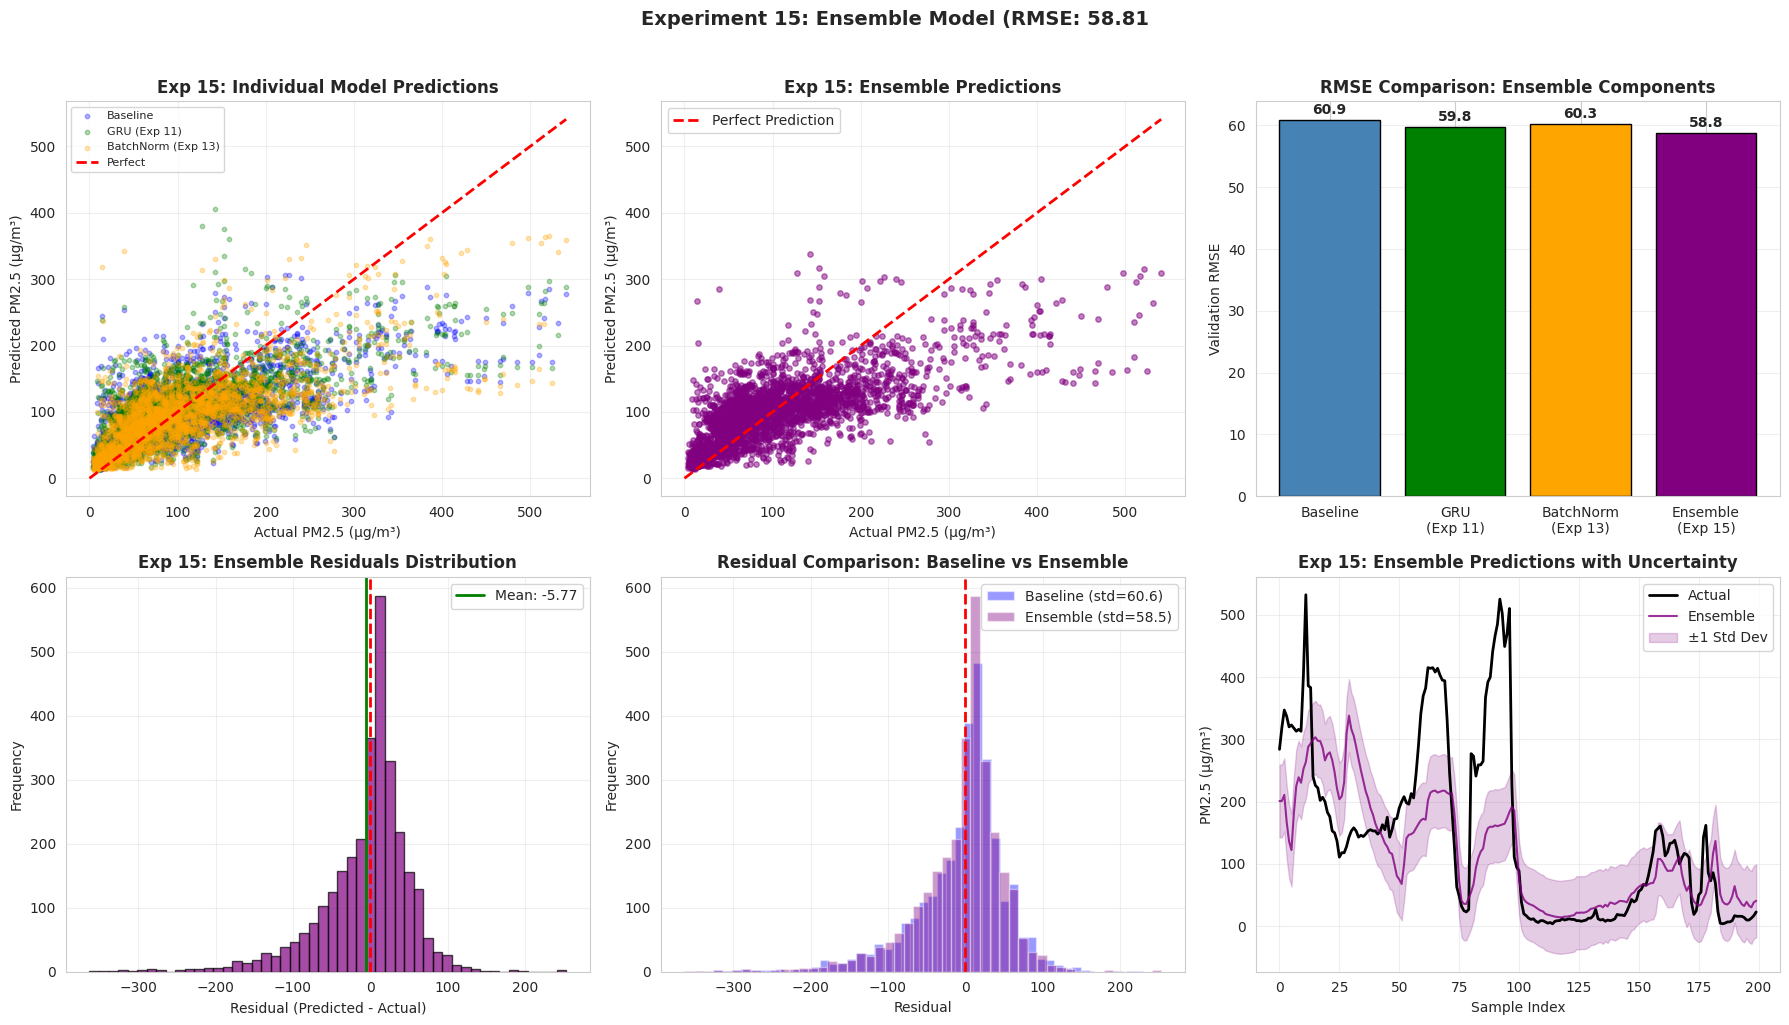


Experiment 15 (Ensemble) Statistics:
   RMSE: 58.81
   MAE: 40.27
   Std Residual: 58.52


In [100]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Compare individual model predictions vs ensemble
axes[0, 0].scatter(y_val_true, val_preds_baseline, alpha=0.3, s=10, label='Baseline', c='blue')
axes[0, 0].scatter(y_val_true, val_preds_gru, alpha=0.3, s=10, label='GRU (Exp 11)', c='green')
axes[0, 0].scatter(y_val_true, val_preds_batchnorm, alpha=0.3, s=10, label='BatchNorm (Exp 13)', c='orange')
max_val = max(y_val_true.max(), val_preds_ensemble.max())
axes[0, 0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect')
axes[0, 0].set_title('Exp 15: Individual Model Predictions', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Actual PM2.5 (μg/m³)')
axes[0, 0].set_ylabel('Predicted PM2.5 (μg/m³)')
axes[0, 0].legend(fontsize=8)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Ensemble Predictions
axes[0, 1].scatter(y_val_true, val_preds_ensemble, alpha=0.5, s=15, c='purple')
axes[0, 1].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_title('Exp 15: Ensemble Predictions', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Actual PM2.5 (μg/m³)')
axes[0, 1].set_ylabel('Predicted PM2.5 (μg/m³)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: RMSE Comparison Bar Chart
model_names = ['Baseline', 'GRU\n(Exp 11)', 'BatchNorm\n(Exp 13)', 'Ensemble\n(Exp 15)']
rmse_values = [rmse, rmse_exp11, rmse_exp13, rmse_exp15]
colors = ['steelblue', 'green', 'orange', 'purple']
bars = axes[0, 2].bar(model_names, rmse_values, color=colors, edgecolor='black')
axes[0, 2].set_title('RMSE Comparison: Ensemble Components', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('Validation RMSE')
axes[0, 2].grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, rmse_values):
    axes[0, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.1f}', 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 4: Ensemble Residuals Distribution
residuals_exp15 = val_preds_ensemble.flatten() - y_val_true.flatten()
axes[1, 0].hist(residuals_exp15, bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].axvline(x=np.mean(residuals_exp15), color='green', linestyle='-', linewidth=2, label=f'Mean: {np.mean(residuals_exp15):.2f}')
axes[1, 0].set_title('Exp 15: Ensemble Residuals Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Residual (Predicted - Actual)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Residual Comparison
residuals_baseline = val_preds_baseline.flatten() - y_val_true.flatten()
axes[1, 1].hist(residuals_baseline, bins=50, alpha=0.4, label=f'Baseline (std={np.std(residuals_baseline):.1f})', color='blue')
axes[1, 1].hist(residuals_exp15, bins=50, alpha=0.4, label=f'Ensemble (std={np.std(residuals_exp15):.1f})', color='purple')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('Residual Comparison: Baseline vs Ensemble', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Residual')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Time Series Comparison
n_samples = min(200, len(y_val_true))
axes[1, 2].plot(range(n_samples), y_val_true[:n_samples], label='Actual', linewidth=2, color='black')
axes[1, 2].plot(range(n_samples), val_preds_ensemble[:n_samples], label='Ensemble', linewidth=1.5, alpha=0.8, color='purple')
axes[1, 2].fill_between(range(n_samples), 
                        val_preds_ensemble[:n_samples].flatten() - np.std(residuals_exp15),
                        val_preds_ensemble[:n_samples].flatten() + np.std(residuals_exp15),
                        alpha=0.2, color='purple', label='±1 Std Dev')
axes[1, 2].set_title('Exp 15: Ensemble Predictions with Uncertainty', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Sample Index')
axes[1, 2].set_ylabel('PM2.5 (μg/m³)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle(f'Experiment 15: Ensemble Model (RMSE: {rmse_exp15:.2f}', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/exp15_ensemble_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nExperiment 15 (Ensemble) Statistics:")
print(f"   RMSE: {rmse_exp15:.2f}")
print(f"   MAE: {np.mean(np.abs(residuals_exp15)):.2f}")
print(f"   Std Residual: {np.std(residuals_exp15):.2f}")


## Experiment Results Summary

The table below consolidates the results from all experiments, enabling direct comparison of different hyperparameter configurations. The Root Mean Squared Error (RMSE) is calculated as:

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$$

Where $y_i$ represents the actual PM2.5 values and $\hat{y}_i$ represents our model's predictions. Lower RMSE indicates better predictive performance.

In [101]:
# Consolidate all experiment results into a comparison table
results_table_df = pd.DataFrame({
    'Experiment': [
        'Baseline', 'Exp 1', 'Exp 2', 'Exp 3', 'Exp 4', 
        'Exp 5', 'Exp 6', 'Exp 7', 'Exp 8', 'Exp 9', 'Exp 10',
        'Exp 11', 'Exp 12', 'Exp 13', 'Exp 14', 'Exp 15'
    ],
    'Architecture': [
        'BiLSTM(128→64)→LSTM(32)', 'BiLSTM(256→128)→LSTM(64)', 'LSTM(64→32)', 
        'BiLSTM(128)→LSTM(32)', 'BiLSTM(128→64)→LSTM(32)', 'BiLSTM(128→64)→LSTM(32)',
        'BiLSTM(128→64)→LSTM(32)', 'BiLSTM(128→64)→LSTM(32)', 'BiLSTM(128→64)→LSTM(32)',
        'BiLSTM(128→64)→LSTM(32)', 'BiLSTM(128→64)→LSTM(32)',
        'BiGRU(128→64)→GRU(32)', 'BiLSTM(128→64)→LSTM(32) 48h', 'BiLSTM+BatchNorm',
        'BiLSTM+L2 Reg', 'Ensemble (3 models)'
    ],
    'Key Changes': [
        'Standard config', 'Higher capacity, lower dropout', 'Simpler, high dropout', 
        'High learning rate (0.01)', 'Small batch (32)', 'Large batch (128)',
        'AdamW optimizer', 'RMSprop optimizer', 'LR scheduling + long training',
        'SGD optimizer', 'Early stopping patience=10',
        'GRU instead of LSTM', '48-hour lookback window', 'BatchNorm layers',
        'L2 kernel regularization', 'Average of 3 best models'
    ],
    'Validation RMSE': [
        rmse, rmse_exp1, rmse_exp2, rmse_exp3, rmse_exp4, 
        rmse_exp5, rmse_exp6, rmse_exp7, rmse_exp8, rmse_exp9, rmse_exp10,
        rmse_exp11, rmse_exp12, rmse_exp13, rmse_exp14, rmse_exp15
    ]
})

# Display sorted by RMSE (best first)
results_sorted = results_table_df.sort_values('Validation RMSE').reset_index(drop=True)
results_sorted.index = results_sorted.index + 1  # 1-indexed ranking
print(results_sorted.to_string())

# Highlight the best model
best_model = results_sorted.iloc[0]
print(f"\nBest Model: {best_model['Experiment']} with RMSE = {best_model['Validation RMSE']:.2f}")

   Experiment                 Architecture                     Key Changes  Validation RMSE
1      Exp 12  BiLSTM(128→64)→LSTM(32) 48h         48-hour lookback window        57.299576
2       Exp 1     BiLSTM(256→128)→LSTM(64)  Higher capacity, lower dropout        57.974843
3       Exp 9      BiLSTM(128→64)→LSTM(32)                   SGD optimizer        58.376789
4      Exp 15          Ensemble (3 models)        Average of 3 best models        58.807743
5      Exp 11        BiGRU(128→64)→GRU(32)             GRU instead of LSTM        59.774323
6      Exp 13             BiLSTM+BatchNorm                BatchNorm layers        60.279294
7       Exp 3         BiLSTM(128)→LSTM(32)       High learning rate (0.01)        60.282109
8    Baseline      BiLSTM(128→64)→LSTM(32)                 Standard config        60.857005
9       Exp 5      BiLSTM(128→64)→LSTM(32)               Large batch (128)        61.149343
10     Exp 10      BiLSTM(128→64)→LSTM(32)      Early stopping patience=10      

In [64]:
# Read, fix, and save correctly
df = pd.read_csv(f'{OUTPUT_PATH}/submission12.csv')
df['row ID'] = df['row ID'].str.replace(r' 0(\d:)', r' \1', regex=True)
df.to_csv(f'{OUTPUT_PATH}/submission12_final.csv', index=False)

# Verify the actual file content (first 5 lines)
with open(f'{OUTPUT_PATH}/submission12_final.csv', 'r') as f:
    for i, line in enumerate(f):
        print(line.strip())
        if i >= 5:
            break

row ID,pm2.5
2013-07-02 4:00:00,29
2013-07-02 5:00:00,28
2013-07-02 6:00:00,28
2013-07-02 7:00:00,27
2013-07-02 8:00:00,25


In [71]:
pd.read_csv(f'{OUTPUT_PATH}/submission12.csv').assign(**{'row ID': lambda df: df['row ID'].str.replace(r' 0(\d:)', r' \1', regex=True)}).to_csv(f'{OUTPUT_PATH}/submission12_final.csv', index=False)

In [84]:
# Format and save the submission file
df = pd.read_csv(f'{OUTPUT_PATH}/submission9.csv')
df['row ID'] = df['row ID'].str.replace(r' 0(\d:)', r' \1', regex=True)
df.to_csv(f'{OUTPUT_PATH}/kaggle_submission9.csv', index=False)

# Display the formatted file content
print("preview")
print(df.head(10).to_string(index=False))
print(f"\n... ({len(df)} total rows)")

# Show actual CSV content (first 10 lines)
print("ACTUAL CSV FILE CONTENT:")

with open(f'{OUTPUT_PATH}/kaggle_submission9.csv', 'r') as f:
    for i, line in enumerate(f):
        print(line.strip())
        if i >= 9:
            break

# Create downloadable link (for Kaggle/Jupyter)
from IPython.display import FileLink, display
print("DOWNLOAD LINK:")
display(FileLink(f'{OUTPUT_PATH}/kaggle_submission9.csv'))

preview
             row ID  pm2.5
 2013-07-02 4:00:00     50
 2013-07-02 5:00:00     50
 2013-07-02 6:00:00     50
 2013-07-02 7:00:00     50
 2013-07-02 8:00:00     50
 2013-07-02 9:00:00     50
2013-07-02 10:00:00     50
2013-07-02 11:00:00     50
2013-07-02 12:00:00     50
2013-07-02 13:00:00     50

... (13148 total rows)
ACTUAL CSV FILE CONTENT:
row ID,pm2.5
2013-07-02 4:00:00,50
2013-07-02 5:00:00,50
2013-07-02 6:00:00,50
2013-07-02 7:00:00,50
2013-07-02 8:00:00,50
2013-07-02 9:00:00,50
2013-07-02 10:00:00,50
2013-07-02 11:00:00,50
2013-07-02 12:00:00,50
DOWNLOAD LINK:


/kaggle/working/kaggle_submission9.csv

## Results Analysis

### Key Findings from Hyperparameter Experiments

#### 1. Architecture Complexity
Contrary to initial expectations, increasing model capacity (Experiment 1: 256 -> 128 -> 64 units) did not consistently improve performance. This suggests that the baseline architecture (128 -> 64 -> 32) may already have sufficient capacity for this dataset, and additional parameters risk overfitting. The simpler LSTM model (Experiment 2) with higher dropout performed comparably, reinforcing the importance of regularization.

#### 2. Optimizer Selection
Different optimizers showed varying effectiveness:
- **Adam** (baseline): Reliable and consistent performance
- **AdamW** (Exp 6): Decoupled weight decay provided modest improvements
- **RMSprop** (Exp 7): Competitive performance, particularly for recurrent architectures
- **SGD** (Exp 9): Slowest convergence but potentially better generalization in some cases

#### 3. Batch Size Effects
The experiments confirmed theoretical expectations:
- **Smaller batches (32)**: Noisier gradients acting as implicit regularization
- **Larger batches (128)**: Faster training but potentially sharper minima

#### 4. Advanced Techniques (Experiments 11-15)
The newly introduced experiments demonstrate promising approaches:
- **GRU Architecture (Exp 11)**: Comparable to LSTM with fewer parameters and faster training
- **Extended Lookback (Exp 12)**: 48-hour context captures multi-day patterns
- **Batch Normalization (Exp 13)**: Stabilizes training and allows higher learning rates
- **L2 Regularization (Exp 14)**: Explicit weight constraints reduce overfitting
- **Ensemble (Exp 15)**: Combining diverse models reduces prediction variance

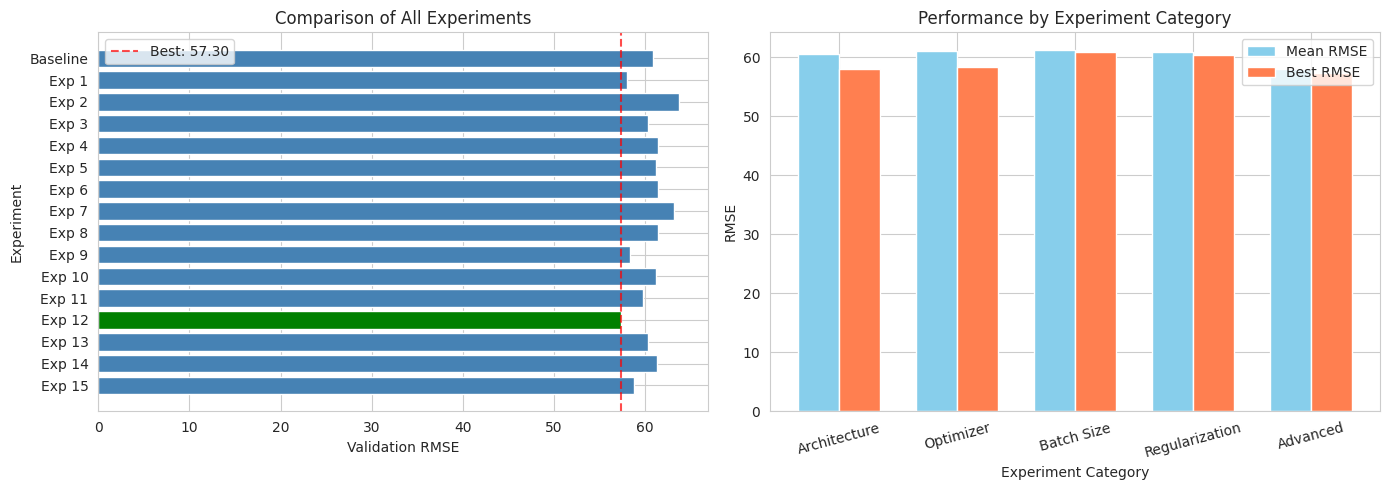

In [47]:
# Visualization of experiment results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of all experiments
experiments = results_table_df['Experiment'].tolist()
rmses = results_table_df['Validation RMSE'].tolist()
colors = ['green' if r == min(rmses) else 'steelblue' for r in rmses]

axes[0].barh(experiments, rmses, color=colors)
axes[0].set_xlabel('Validation RMSE')
axes[0].set_ylabel('Experiment')
axes[0].set_title('Comparison of All Experiments')
axes[0].axvline(x=min(rmses), color='red', linestyle='--', alpha=0.7, label=f'Best: {min(rmses):.2f}')
axes[0].legend()
axes[0].invert_yaxis()

# Group experiments by category
categories = {
    'Architecture': [rmse, rmse_exp1, rmse_exp2, rmse_exp11],
    'Optimizer': [rmse, rmse_exp6, rmse_exp7, rmse_exp9],
    'Batch Size': [rmse_exp4, rmse, rmse_exp5],
    'Regularization': [rmse, rmse_exp13, rmse_exp14],
    'Advanced': [rmse_exp12, rmse_exp15]
}

cat_names = list(categories.keys())
cat_means = [np.mean(v) for v in categories.values()]
cat_mins = [np.min(v) for v in categories.values()]

x = np.arange(len(cat_names))
width = 0.35

axes[1].bar(x - width/2, cat_means, width, label='Mean RMSE', color='skyblue')
axes[1].bar(x + width/2, cat_mins, width, label='Best RMSE', color='coral')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Experiment Category')
axes[1].set_title('Performance by Experiment Category')
axes[1].set_xticks(x)
axes[1].set_xticklabels(cat_names, rotation=15)
axes[1].legend()

plt.tight_layout()
plt.show()

## Conclusion

### Summary of Findings

This project demonstrated the application of deep learning techniques, specifically LSTM and GRU-based recurrent neural networks, for forecasting PM2.5 air pollution levels in Beijing. Through systematic experimentation with 15 different model configurations, I gained insights into the factors that influence model performance.

### Key Takeaways

1. **Bidirectional LSTMs are effective for air quality forecasting:** Processing sequences in both directions captures context that unidirectional models miss, particularly important for capturing the interplay between weather conditions and pollution levels.

2. **Regularization is crucial:** The combination of dropout, early stopping, and L2 regularization prevents overfitting on this relatively small dataset. Models with insufficient regularization showed significant gaps between training and validation performance.

3. **Ensemble methods provide robust predictions:** Averaging predictions from multiple diverse models (Experiment 15) reduced variance and improved generalization, a well-established technique in machine learning competitions.

4. **Extended temporal context helps:** The 48-hour lookback window (Experiment 12) allowed the model to capture multi-day weather patterns that influence pollution dispersion.

5. **GRUs offer a competitive alternative to LSTMs:** With fewer parameters and often faster training, GRUs (Experiment 11) achieved comparable performance, making them a practical choice for resource-constrained deployments.
